# Case 102 AY3H 9-5 BHA1  : Generalization at different locations
### LINK for Case : https://sintef.sharepoint.com/:f:/r/teams/work-8763/Shared Documents/Shared_with_students/Data_and_Code/SimulationsHFM/Case101 branch2 BHA3?csf=1&web=1&e=2cz999

The goal of this notebook is to develop Rolling and Non rolling LSTM for predicting errors between HAM predictions.
and to test its performance on (a) Spatial extrapolation, and (b) temporal extrapolation and interpolation.

What is needed
- 1: Data file (supposed to be a pickle file generated by the pre-processing flow)
- 2: Model file (3 csv files generated by the model: time series, time series Obs and Depth files)
- 3 Additional information:
    - Time stamps limiting HFM limitations


## Imports

In [1]:
# In case of reloading functions
%load_ext autoreload
%autoreload 2

# System
import copy
import sys
import time,datetime
from datetime import datetime
import os
import gc
import pickle
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


# Mathematical operations / data manipulations
import numpy as np
import pandas as pd
import scipy as sc

# Graphics
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib as mpl
import matplotlib.dates as mdates


# Deep learning / ML part
import tensorflow as tf

from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.layers import Dropout,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.losses import mse
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, constraints, initializers, activations
from tensorflow.keras.layers import InputSpec

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib
# Local functions and primitives
#sys.path.append('..\\dataprocessing')
# For plotting
#import plotfunctions as plfun
# For data pre-processing and QC
#from lstm_scripts import  prepare_dataset, create_model, mae, feature_perm_importance

In [2]:
with open('model_z_df_1_Case102_AY3H_9-5_BHA1.pickle','rb') as f:
    (results_z,columns,conc_val_cutting)=pickle.load(f) #
    print('File 1 loaded')

with open('model_t_df_Case102_AY3H_9-5_BHA1.pickle','rb') as f:
    model_t_df_reinterp=pickle.load(f)
    print('File 2 loaded')

with open('model_t_obs_df_Case102_AY3H_9-5_BHA1.pickle','rb') as f:
    model_t_obs_df_reinterp=pickle.load(f)
    print('File 3 loaded - simulation observation')

#with open('model_z_df_2_Case102_AY3H_9-5_BHA1.pickle','rb') as f:
 #   (results_z2,columns,conc_val_cutting2)=pickle.load(f)
 #   print('File 2 loaded')

 

File 1 loaded
File 2 loaded
File 3 loaded - simulation observation


In [3]:
print(columns)
print(results_z.shape)

['time', 'loc', 'mdOut', 'mdIn', 'pOut/pBar', 'ecdOut', 'dpf', 'reyn', 'tayl', 'shieldsNum', 'rouseNum', 'avgDensity', 'mudMass', 'cuttMass']
(14, 11999, 356)


## Input variables



In [3]:
# Data path for pre-processed data
# datapath = "C:/Users/mandart/SINTEF/KPN Hole cleaning and hybrid methods - Documents/Shared_with_students/Data_and_Code/Data/case102/"
datapath ="C:/Users/mandart/SINTEF/KPN Anomaly detection in drilling with hybrid methods - Documents/Shared_with_students/Data_and_Code/Data/case102/"

# Data path for modeled data
modelpathbase = "C:/Users/mandart/SINTEF/KPN Anomaly detection in drilling with hybrid methods - Documents/Arbeid/Philippe/Simulations KIM/AY3H BHA1/"
#'C:/Users/mandart/SINTEF/KPN Hole cleaning and hybrid methods - Documents/Arbeid/Philippe/Simulations KIM/AY3H BHA1/'


# Time stamps
tstamp_min = '2020-08-13 16:20:00+00:00'
tstamp_max = '2020-08-15 01:40:00+00:00'

# Interval characteristics
List_interval = pd.DataFrame([['0_933',0.,933.,1.1,1.55],
                              ['933_1233',933.,1233.,1.1,1.5],
                              ['1233_2000',1233.,2000.,1.1,1.45],
                              #['2566_6180',2566.,6180.,.95,1.23]
                              #['2500_2835',2500.,2835.,1.,1.3],
                              #['2835_4165',2835.,4165.,.95,1.25]
                             ],
                             columns=['name','tmin','tmax','Xfactor','DSXFactor'])
#List_interval = pd.DataFrame([['0_380',0.,380.,1.3,1.3],
#                              ['380_800',380.,800.,1.5,1.27],
#                              ['800_1280',800.,1280.,1.5,1.22],
#                              ['1280_1750',1280.,1750.,1.5,1.19],
#                              ['1750_2250',1750.,2250.,1.5,1.15],
#                              ['2250_4050',2250.,4050.,1.5,1.15],
#                              ['4050_4650',4050.,4650.,1.7,1.15],
#                              ['4650_7078',4650.,7078.,2,1.15]
#                             ],
#                             columns=['name','tmin','tmax','Xfactor','DSXFactor'])
#
# Columns from model depth data
columns = ['time', 'loc', 'mdOut', 'mdIn', 'pOut/pBar', 'ecdOut', 'dpf', 'reyn', 'tayl', 'shieldsNum', 'rouseNum', 'avgDensity', 'mudMass', 'cuttMass']


## Reading files

Data are pickle files that require a little bit of pre-processing. Model files are time series generated by the Fortran Model

##### Data time series

In [4]:
# Data

data_df = pd.read_csv(datapath + 'case102_10_seconds.csv',sep=',',skiprows=[1],index_col='TIME')
#with open(datafile,'rb') as f:
#    ((data_1_df, data_2_df, data_3_df),(mean_df,std1_df)) = pickle.load(f)
    
#data_df = pd.concat([data_1_df,data_2_df,data_3_df],axis=0)

In [5]:
data_df.index

Index(['2020-07-07 17:05:40+00:00', '2020-07-07 17:05:50+00:00',
       '2020-07-07 17:06:00+00:00', '2020-07-07 17:06:10+00:00',
       '2020-07-07 17:06:20+00:00', '2020-07-07 17:06:30+00:00',
       '2020-07-07 17:06:40+00:00', '2020-07-07 17:06:50+00:00',
       '2020-07-07 17:07:00+00:00', '2020-07-07 17:07:10+00:00',
       ...
       '2020-09-04 06:31:00+00:00', '2020-09-04 06:31:10+00:00',
       '2020-09-04 06:31:20+00:00', '2020-09-04 06:31:30+00:00',
       '2020-09-04 06:31:40+00:00', '2020-09-04 06:31:50+00:00',
       '2020-09-04 06:32:00+00:00', '2020-09-04 06:32:10+00:00',
       '2020-09-04 06:32:20+00:00', '2020-09-04 06:32:30+00:00'],
      dtype='object', name='TIME', length=211555)

##### Model time and depth series

In [6]:
# Model time series:
for i in range(List_interval.shape[0]):
    model_t_file = modelpathbase + List_interval.name.iloc[i] + '/TimeSeries.out' 
    model_t_temp_df = pd.read_csv(model_t_file,
                             header = 0,
                             index_col=0,
                             delimiter='\s+')

    model_t_obs_file = modelpathbase + List_interval.name.iloc[i]  + '/TimeSeries_Obs.out' 
    model_t_obs_temp_df = pd.read_csv(model_t_obs_file,
                             header = 0,
                             index_col=0,
                             delimiter='\s+')

    model_depth_flat_file = modelpathbase + List_interval.name.iloc[i] + '/DepthDataFlat.out' 
    model_depth_flat_temp_df = pd.read_csv(model_depth_flat_file,
                                           skiprows=[1],
                                           delimiter='\s+',usecols=columns)

    model_t_temp_df = model_t_temp_df.loc[(model_t_temp_df.index>List_interval.tmin.iloc[i])&
                                          (model_t_temp_df.index<=List_interval.tmax.iloc[i])]
    model_t_obs_temp_df = model_t_obs_temp_df.loc[(model_t_obs_temp_df.index>List_interval.tmin.iloc[i])&
                                                  (model_t_obs_temp_df.index<=List_interval.tmax.iloc[i])]
    model_depth_flat_temp_df = model_depth_flat_temp_df.loc[(model_depth_flat_temp_df.time>List_interval.tmin.iloc[i])&
                                                            (model_depth_flat_temp_df.time<=List_interval.tmax.iloc[i])]

    model_t_temp_df['XFactor'] = List_interval.Xfactor.iloc[i]    
    model_t_temp_df['DSXFactor'] = List_interval.DSXFactor.iloc[i]
    if i ==0:
        model_t_df = model_t_temp_df
        model_t_obs_df = model_t_obs_temp_df
        model_depth_flat_df = model_depth_flat_temp_df
    else:
        model_t_df = pd.concat([model_t_df,model_t_temp_df],axis=0)
        model_t_obs_df = pd.concat([model_t_obs_df,model_t_obs_temp_df],axis=0)
        model_depth_flat_df = pd.concat([model_depth_flat_df,model_depth_flat_temp_df],axis=0)
        


In [7]:
model_t_obs_temp_df.columns

Index(['pAtPos1', 'ecdAtPos1', 'TvdAtPpos1', 'TAtPos1', 'pAtPos2', 'ecdAtPos2',
       'TvdAtPpos2', 'TAtPos2', 'pAtPos3', 'ecdAtPos3', 'TvdAtPpos3',
       'TAtPos3', 'pAtPos4', 'ecdAtPos4', 'TvdAtPpos4', 'TAtPos4'],
      dtype='object')

In [8]:
model_t_df.index #0.1666

Float64Index([0.1666667, 0.3333333,       0.5, 0.6666667, 0.8333333,       1.0,
               1.166667,  1.333333,       1.5,  1.666667,
              ...
                 1998.5,  1998.667,  1998.833,    1999.0,  1999.167,  1999.333,
                 1999.5,  1999.667,  1999.833,    2000.0],
             dtype='float64', name='Time', length=12000)

In [47]:
0.1666*60 #10 seconds

9.996

### Processing

#### Data

- First take desired interval and convert index to time stamps interval

In [9]:
data_df.index=pd.to_datetime(data_df.index)

In [10]:
data_df.index

DatetimeIndex(['2020-07-07 17:05:40+00:00', '2020-07-07 17:05:50+00:00',
               '2020-07-07 17:06:00+00:00', '2020-07-07 17:06:10+00:00',
               '2020-07-07 17:06:20+00:00', '2020-07-07 17:06:30+00:00',
               '2020-07-07 17:06:40+00:00', '2020-07-07 17:06:50+00:00',
               '2020-07-07 17:07:00+00:00', '2020-07-07 17:07:10+00:00',
               ...
               '2020-09-04 06:31:00+00:00', '2020-09-04 06:31:10+00:00',
               '2020-09-04 06:31:20+00:00', '2020-09-04 06:31:30+00:00',
               '2020-09-04 06:31:40+00:00', '2020-09-04 06:31:50+00:00',
               '2020-09-04 06:32:00+00:00', '2020-09-04 06:32:10+00:00',
               '2020-09-04 06:32:20+00:00', '2020-09-04 06:32:30+00:00'],
              dtype='datetime64[ns, UTC]', name='TIME', length=211555, freq=None)

In [11]:
data_df = data_df.loc[tstamp_min:tstamp_max] #tstamp is label for time.

In [12]:
data_df.columns

Index(['WOB', 'HKLD', 'MUD_FLOW_OUT', 'BLOCKPOS', 'ROP', 'TORQ', 'MUD_FLOW_IN',
       'MUD_DENS_OUT', 'PUMP_PRESS', 'PIT_TOT',
       ...
       'D1AX-Relog', 'D1AY-Relog', 'PWPI-Relog', 'EAAF-Relog', 'DGRCC-Relog',
       'PW16-Relog', 'D1SS-Relog', 'ALCDH-Relog', 'RDGDTVSS-Relog',
       'D1AZ-Relog'],
      dtype='object', length=188)

In [41]:
data_df.shape

(12001, 188)

### Model

- Reindex the depth flat file 

In [6]:
#model_depth_flat_df.set_index([model_depth_flat_df.columns[0],model_depth_flat_df.columns[2]],inplace=True)
#model_depth_flat_df.index.names =['time','mdOut']

- Extract some additional quantities from the flat file:
    - Input Density: It is not exactly the input but the average density in the first cell in the riser/drill string. THerefore, we expect some slight difference.
    - Output Density: It is not exactly the input but the average density in the last cell in the riser/annulus. THerefore, we expect some slight difference.

- We need to reinterpolate the series extracted so they have the same length as the output series.

In [13]:
X = model_depth_flat_df.query('mdOut==0.').avgDensity.values[:]
Tin = model_depth_flat_df.query('mdOut==0.').time.values
Tout = model_t_df.index.values

f =  sc.interpolate.interp1d(Tin,X,axis=0,fill_value='extrapolate')
X_reinterp = f(Tout)
model_t_df['DensityIn'] = X_reinterp


In [14]:
X = model_depth_flat_df.query('mdIn==0.').avgDensity.values[:]
Tin = model_depth_flat_df.query('mdOut==0.').time.values
Tout = model_t_df.index.values

f =  sc.interpolate.interp1d(Tin,X,axis=0,fill_value='extrapolate')
X_reinterp = f(Tout)
model_t_df['DensityOut'] = X_reinterp



- Reinterpolate if necessary (model may generate some smaller time steps in occasions)

In [15]:
#time units in minutes. The timstep of  0.16 minutes (1/6) is equaivalent to 10 seconds. 
# The simulations outputs are interpolated at same time-step of 10 s as the experimental one.
tinit = 0.
tfinal = 2000.
t_samples_final = np.arange(tinit,tfinal,1./6.)

X = model_t_df.index.values
A = model_t_df.values
f = sc.interpolate.interp1d(X,A,axis=0,fill_value='extrapolate')
A_reinterp = f(t_samples_final)

model_t_df_reinterp = pd.DataFrame(data = A_reinterp,index=t_samples_final,columns = model_t_df.columns)

X = model_t_obs_df.index.values
A = model_t_obs_df.values
f = sc.interpolate.interp1d(X,A,axis=0,fill_value='extrapolate')
A_reinterp = f(t_samples_final)

model_t_obs_df_reinterp = pd.DataFrame(data = A_reinterp,index=t_samples_final,columns = model_t_obs_df.columns)

# Can we reinterpolate all the model depth data at same times i.e. t_samples_final

# Can we reinterpolate the experimental data at same times i.e. t_samples_final

# For training - we should plot the ECD experimental data from data_f vs the ECD from the model_t_obs_df_reinterp


# OBS! depth file will be processed later in the map_depth procedure. This is because the grid may change from one time step to another


Copies indexes from data (may have to change min and max here)

In [16]:
model_t_df_reinterp.shape[0]

12000

In [17]:
model_t_obs_df_reinterp.index=data_df.index[:model_t_df_reinterp.shape[0]]
model_t_df_reinterp.index=data_df.index[:model_t_df_reinterp.shape[0]]

In [18]:
def map_pars_t_z(df,casing_shoe_md,md_resol,tmin,tmax,dt):
    '''
    This function considers the depth flat output from the PBM model, as formatted above.
    It has 38 columns, with:
    - col0: time
    - col1: segment (1 = DS, 2 = OH, 3 = Ann)
    - col2 : mdin (m)
    - col3 = mdout (m)
    - col4-37: par to be mapped
    
    It returns a 3d array (MD * time * 38 parameters). Time steps is equal to the one in the model. md step is an input parameter
    '''
    
    # Returns all the time steps:
    time_steps = df['time'].unique()
    
    # Finds max MD 
    md_max = df['mdIn'].max()
    
    # creates output array and defines dimensions:
    nt = time_steps.shape[0]
    nmd = np.int32(md_max // md_resol) 
    npar = df.shape[1]
    output_array = np.zeros((nt,nmd,npar))
    data_reinterp = np.zeros((nmd,npar))
    istep = 0
    
    # loop on time steps
    for tstep in time_steps:
        # extracts subtable: at tstep and in the annulus (loc > 1)
        data = df[df['time'] == tstep]
        data = data[data['loc'] > 1].values[::-1,:]
        # values are assigned to the center of the cell
        md_in = 0.5 * (data[:,3] + data[:,2])
        # output_grid
        md_out = np.arange(md_resol/2.,md_max,md_resol) #all grid locations upto max measured depth of all times. Lots of this must be empty at given time.
        ind_md_out_max = np.int32(data[-1,2] // md_resol) #index of maximum measured depth mdIn at that time.

        #BHA
        data_bha = data[data[:,1]==3,:][-1:,:] #last row in annulus section - all columns
        bhatop = data_bha[0,3] #mdout in last row at that time
        bhabot = data_bha[0,2] #mdin in last row at that time #mdIn/mdout starts from zero.
        ind_md_ann_max = np.int32(bhatop // md_resol) #index
        ind_md_bha_max = np.int32(bhabot // md_resol)
        
        
        
        # Reinterpolation (1D in MD)
        f = sc.interpolate.interp1d(md_in,data,axis=0,fill_value = 'extrapolate') #average of mdIn/mdout, and data is obtained at cell center at given time for location annulus for values arranged from high depth to low depth.
        data_reinterp[:ind_md_ann_max,:] = f(md_out[:ind_md_ann_max]) #data obtained upto max depth at that time in annulus (without bottom hole). at common interpolated grid - same number of grids 
        
        # BHA
        data_reinterp[ind_md_ann_max:ind_md_bha_max,:] = data_bha  #data for bottom hole at that time added separately.
        
        # VOlume ahead of the bit to BH (if any)
        if ind_md_bha_max < ind_md_out_max:
            data_reinterp[ind_md_bha_max:ind_md_out_max,:] = f(md_out[ind_md_bha_max:ind_md_out_max])
            
        
        # masks non drilled cells
        data_reinterp[ind_md_out_max:,:] = np.nan #data that is non drilled at given time.
        
        # Redefines columns 2 and 3 giving respectively the depth of top and base of the current cell
        data_reinterp[:,2] = md_out - md_resol/2.
        data_reinterp[:,3] = md_out + md_resol/2.
        
        
        
        output_array[istep,:,:] = data_reinterp
        istep += 1
        
        # we reshape the output to have para first, then time, then md
        
    # Now that all the depth grids are consistent, we can reinterpolate the time . So on a uniform grid, you have respective values of depth,and all variables. 
    time_steps_final = np.arange(tmin,tmax,dt)
    X = time_steps
    A = output_array
    f = sc.interpolate.interp1d(X,A,axis=0,fill_value='extrapolate')
    A_reinterp = f(time_steps_final)

    
    
    
    return np.transpose(A_reinterp,[2,0,1])



    * Reinterpolates the depth file to a regular grid in time and depth


In [19]:
model_t_obs_temp_df.shape

(4602, 16)

In [20]:
results_z = map_pars_t_z(model_depth_flat_df,3321,10,1./6.,2000.,1./6) #last 4: mdresol,tmin,tmax,dt. original : 10,1./6.,2000.,1./6

NameError: name 'model_depth_flat_df' is not defined

    * Calculating the volumetric concentration of cuttings

In [27]:
conc_val_cutting = np.divide(results_z[-1,:,::-1],results_z[-2,:,::-1], where=results_z[-2,:,::-1]>0.).T*results_z[-3,:,::-1].T/2650.

In [20]:
model_t_df_reinterp.columns

Index(['Rate_in', 'SPP', 'ECD_bot', 'ECD_shoe', 'P_choke', 'FrontFluid2',
       'FrontFluid3', 'FrontFluid4', 'FrontFluid5', 'FrontFluid6', 'totVolInj',
       'totStrokes', 'totVolOut', 'pitVol', 'WHP', 'volRateOut', 'dsGap',
       'BHP', 'T_bot', 'T_top', 'mdBit', 'ecdAtPos', 'pAtPos', 'TAtPos',
       'dsRpm', 'rop', 'xFactor', 'kFactor', 'yCalc', 'yCalcAvg', 'yMeas',
       'Pxy', 'Pyy', 'Pa', 'Gel1', 'Gel2', 'Gel3', 'Gel4', 'Gel5', 'ShieldBHA',
       'ShieldAnn', 'ShieldRiser', 'CtrBHA', 'CtrAnn', 'CtrRiser',
       'CutConsBHA', 'CutConsAnn', 'CutConsRiser', 'ReynBHA', 'ReynAnn',
       'ReynRiser', 'TaylBHA', 'TaylAnn', 'TaylRiser', 'RouseBHA', 'RouseAnn',
       'RouseRiser', 'voidShoe', 'voidAtBha', 'cutSt', 'vDev', 'pDev',
       'mTotMud', 'mFreeGas', 'mDGas', 'qLoss', 'mLost', 'XFactor',
       'DSXFactor', 'DensityIn', 'DensityOut'],
      dtype='object')

In [22]:
print('time series shape',model_t_df_reinterp.shape) #timesteps x number of parameters including ECD_bot

time (12000, 71)


In [21]:
model_t_obs_df_reinterp.index

DatetimeIndex(['2020-08-13 16:20:00+00:00', '2020-08-13 16:20:10+00:00',
               '2020-08-13 16:20:20+00:00', '2020-08-13 16:20:30+00:00',
               '2020-08-13 16:20:40+00:00', '2020-08-13 16:20:50+00:00',
               '2020-08-13 16:21:00+00:00', '2020-08-13 16:21:10+00:00',
               '2020-08-13 16:21:20+00:00', '2020-08-13 16:21:30+00:00',
               ...
               '2020-08-15 01:38:20+00:00', '2020-08-15 01:38:30+00:00',
               '2020-08-15 01:38:40+00:00', '2020-08-15 01:38:50+00:00',
               '2020-08-15 01:39:00+00:00', '2020-08-15 01:39:10+00:00',
               '2020-08-15 01:39:20+00:00', '2020-08-15 01:39:30+00:00',
               '2020-08-15 01:39:40+00:00', '2020-08-15 01:39:50+00:00'],
              dtype='datetime64[ns, UTC]', name='TIME', length=12000, freq=None)

In [50]:
data_df.index

DatetimeIndex(['2020-08-13 16:20:00+00:00', '2020-08-13 16:20:10+00:00',
               '2020-08-13 16:20:20+00:00', '2020-08-13 16:20:30+00:00',
               '2020-08-13 16:20:40+00:00', '2020-08-13 16:20:50+00:00',
               '2020-08-13 16:21:00+00:00', '2020-08-13 16:21:10+00:00',
               '2020-08-13 16:21:20+00:00', '2020-08-13 16:21:30+00:00',
               ...
               '2020-08-15 01:38:30+00:00', '2020-08-15 01:38:40+00:00',
               '2020-08-15 01:38:50+00:00', '2020-08-15 01:39:00+00:00',
               '2020-08-15 01:39:10+00:00', '2020-08-15 01:39:20+00:00',
               '2020-08-15 01:39:30+00:00', '2020-08-15 01:39:40+00:00',
               '2020-08-15 01:39:50+00:00', '2020-08-15 01:40:00+00:00'],
              dtype='datetime64[ns, UTC]', name='TIME', length=12001, freq=None)

In [27]:
model_t_obs_df_reinterp.columns

Index(['pAtPos1', 'ecdAtPos1', 'TvdAtPpos1', 'TAtPos1', 'pAtPos2', 'ecdAtPos2',
       'TvdAtPpos2', 'TAtPos2', 'pAtPos3', 'ecdAtPos3', 'TvdAtPpos3',
       'TAtPos3', 'pAtPos4', 'ecdAtPos4', 'TvdAtPpos4', 'TAtPos4'],
      dtype='object')

In [22]:
print('observation points time series shape',model_t_obs_df_reinterp.shape) #timesteps x what is 16 (4 locations and each location has 4 featyres including ecd at).

observation points time series shape (12000, 16)


In [23]:
print('mapped depth data shape', results_z.shape) #num_parameters x timestep x depth , 11999 because it does not start from 0?

mapped depth data shape (14, 11999, 356)


In [48]:
data_df.index

DatetimeIndex(['2020-08-13 16:20:00+00:00', '2020-08-13 16:20:10+00:00',
               '2020-08-13 16:20:20+00:00', '2020-08-13 16:20:30+00:00',
               '2020-08-13 16:20:40+00:00'],
              dtype='datetime64[ns, UTC]', name='TIME', freq=None)

In [24]:
print('Experimental ASM data', data_df.shape) #Timeseries x num_parameters and no ECD here. ECD has to be computed. Why 120001? 

Experimental ASM data (12001, 188)


### Graphs

#### 1- Bit / Hole progress

Calculate the distance from ASM sensors to bit

In [51]:
np.median(data_df.iloc[25000:37000]['ASMDEP3-T']-data_df.iloc[25000:37000]['DEP'])

c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

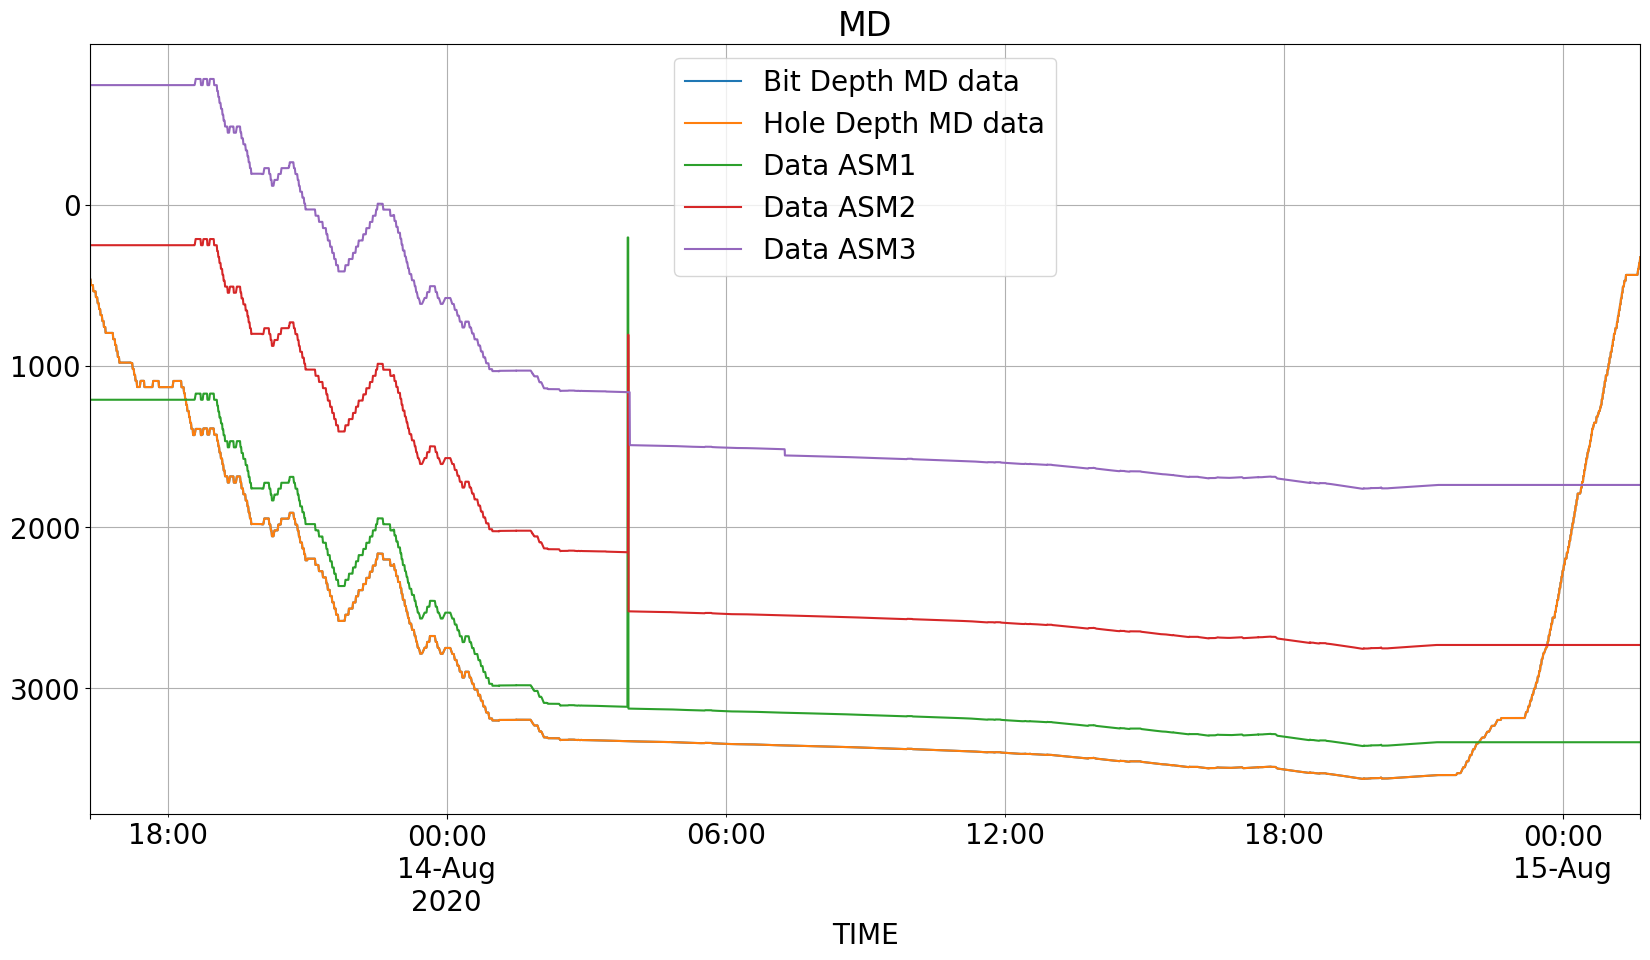

In [52]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='DEP',label='Bit Depth MD data',ax=ax)
data_df.plot(y='DEP',label='Hole Depth MD data',ax=ax)
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:-1],model_t_df_reinterp.mdBit.values[:],label='Bit depth HFM')
data_df.plot(y='ASMDEP1-T',label='Data ASM1',ax=ax)
data_df.plot(y='ASMDEP2-T',label='Data ASM2',ax=ax)
data_df.plot(y='ASMDEP3-T',label='Data ASM3',ax=ax)
#model_t_df_reinterp.plot(y='mdBit',label='Mod Bit',ax=ax)
#data_df.plot(y='ASMDEP2-T',label='Data ASM2',ax=ax)
#plt.plot(data_df.loc[::10].index.values,data_df.loc[::10].HDEP.values,label='Bit Depth MD data')
#plt.plot(data_df.index[510000:700000],data_df.DEP.values[510000:700000]-data_df.ASMDEP3_T.values[510000:700000],label='Hole Depth MD data')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:-1],model_t_df_reinterp.mdBit.values[:],label='Bit depth HFM')
#plt.plot(data_df.loc[::10].index.values,data_df.loc[::10].ASMDEP1_T.values,label='Data ASM1')
#plt.plot(data_df.loc[::10].index.values,data_df.loc[::10].ASMDEP2_T.values,label='Data ASM2')
#plt.plot(data_df.loc[::10].index.values,data_df.loc[::10].ASMDEP3_T.values,label='Data ASM3')
ax.legend()
#ax.set_ylim([0,6500])
ax.set_title('MD')
ax.grid(which='both')
ax.invert_yaxis()
#ax.set_xticks(data_df.index[6+360*5::360*12],pd.to_datetime(data_df.index[6+360*5::360*12],format='%h'))
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%D %H')) 


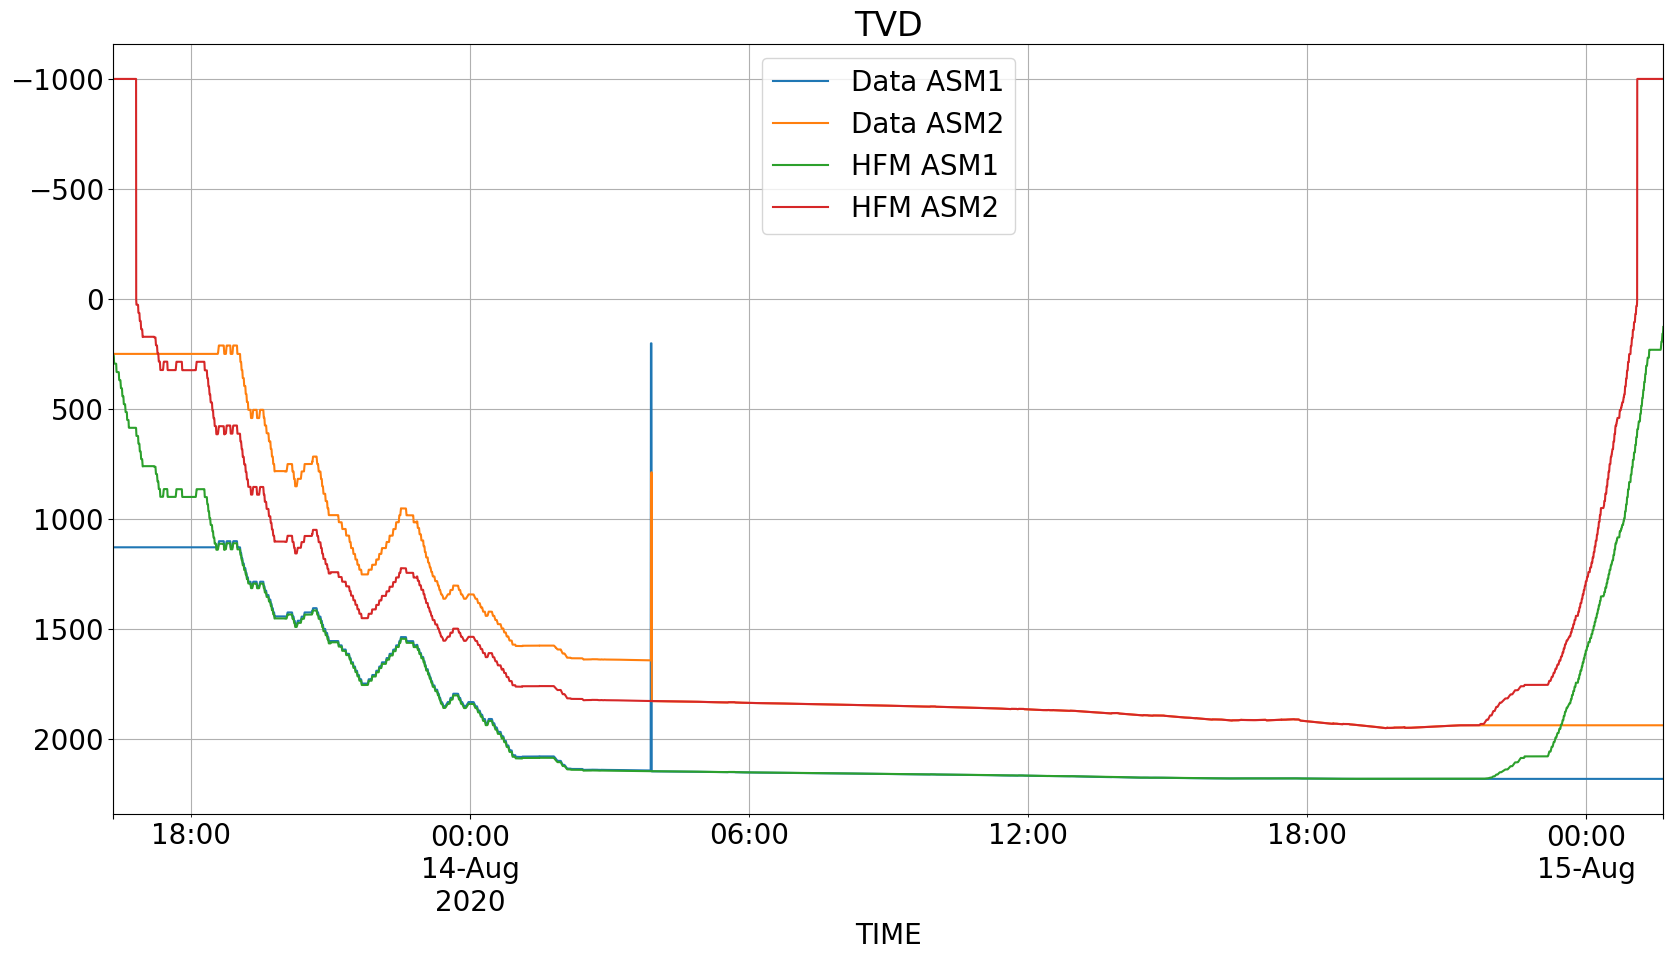

In [53]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})
#plt.plot(data_df['ASMTVD2-T']-model_t_obs_df_reinterp['TvdAtPpos2'])
data_df.plot(y='ASMTVD1-T',label='Data ASM1',ax=ax)
data_df.plot(y='ASMTVD2-T',label='Data ASM2',ax=ax)
model_t_obs_df_reinterp.plot(y='TvdAtPpos1',label='HFM ASM1',ax=ax)
model_t_obs_df_reinterp.plot(y='TvdAtPpos2',label='HFM ASM2',ax=ax)
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:-1],model_t_obs_df_reinterp.TvdAtPpos3.values[:],label='HFM ASM3')
ax.legend()
#ax.set_ylim([0,2300])

ax.set_title('TVD')
ax.grid(which='both')
ax.invert_yaxis()
#ax.set_xticks(data_df.index[6+360*5::360*12],pd.to_datetime(data_df.index[6+360*5::360*12],format='%h'))
#plt.gcf().autofmt_xdate()

#ax.set_ylim([-15,15])

###### Hole inclination

In [25]:
incl = np.arccos(model_t_obs_df_reinterp.TvdAtPpos1.diff()/model_t_df_reinterp.mdBit.diff())*180/np.pi
model_t_df_reinterp['incl']=incl

c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


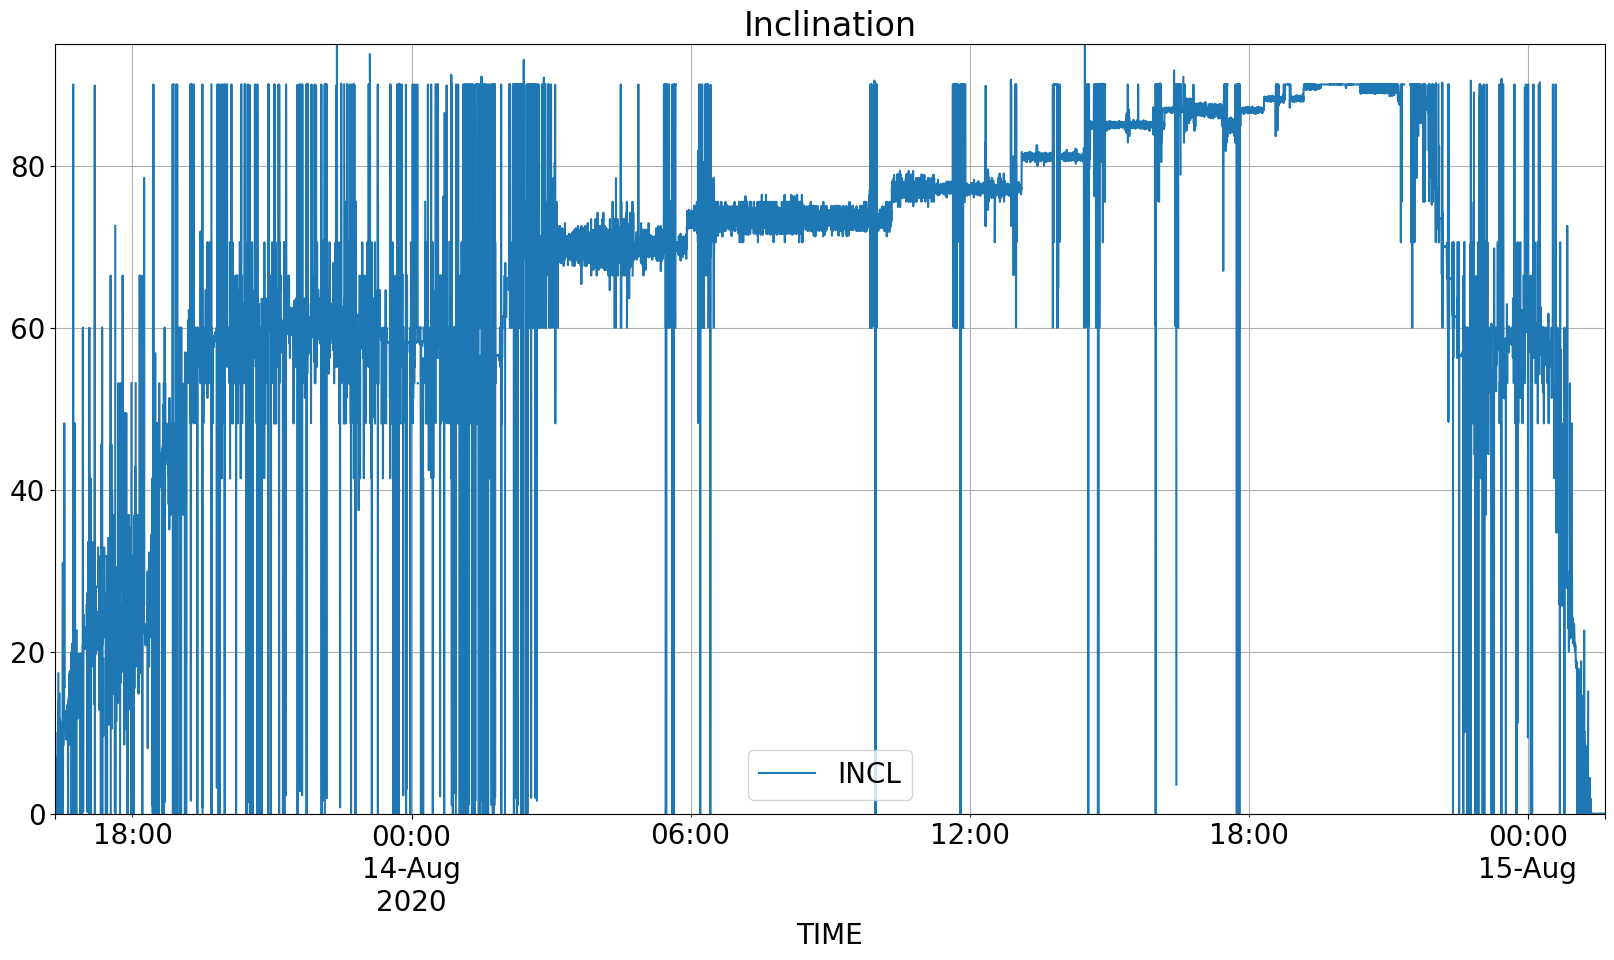

In [55]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='incl',label='INCL',ax=ax)
ax.legend()
ax.set_title('Inclination')
ax.set_ylim([0,95])
#ax.set_xticks(model_t_df_reinterp.index[6+360*5::360*12],pd.to_datetime(model_t_df_reinterp.index[6+360*5::360*12]))
#plt.gcf().autofmt_xdate()
ax.grid(which='both')
#ax.set_ylim([1.2,1.5])#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')


#### 2- RPM

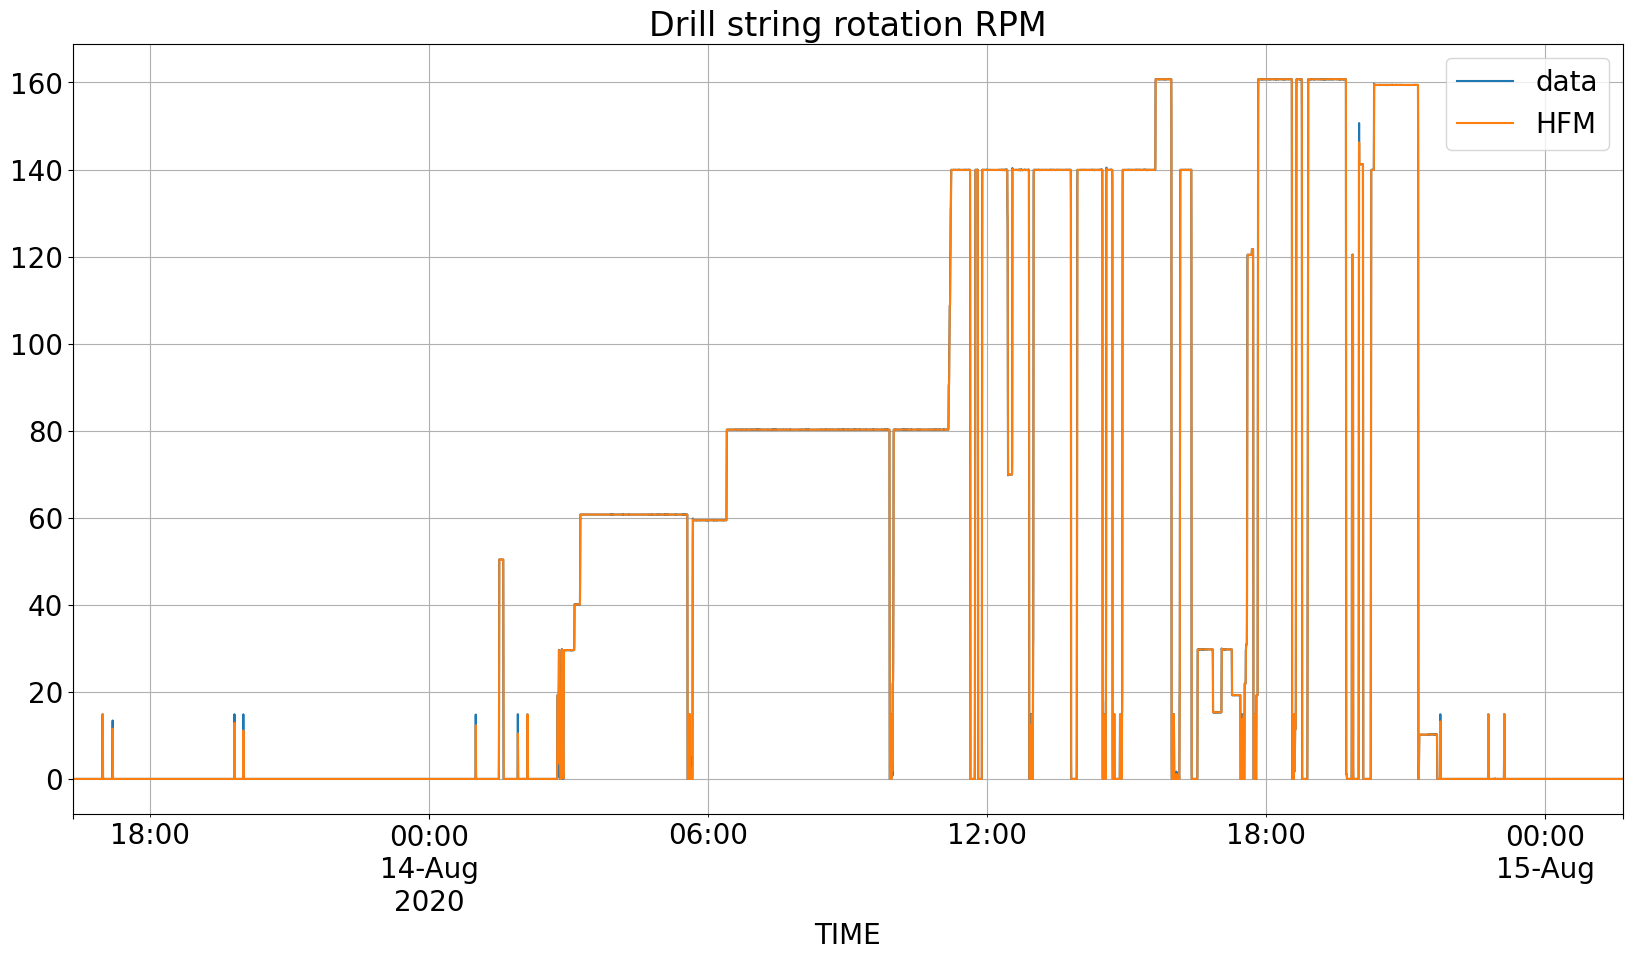

In [56]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='RPMSAVG',ax=ax,label='data')
model_t_df_reinterp.plot(y='dsRpm',ax=ax,label='HFM')
ax.legend()
ax.set_title('Drill string rotation RPM')
ax.grid(which='both')
#ax.set_ylim([3,4])


#### 3- Flow rate Mud In

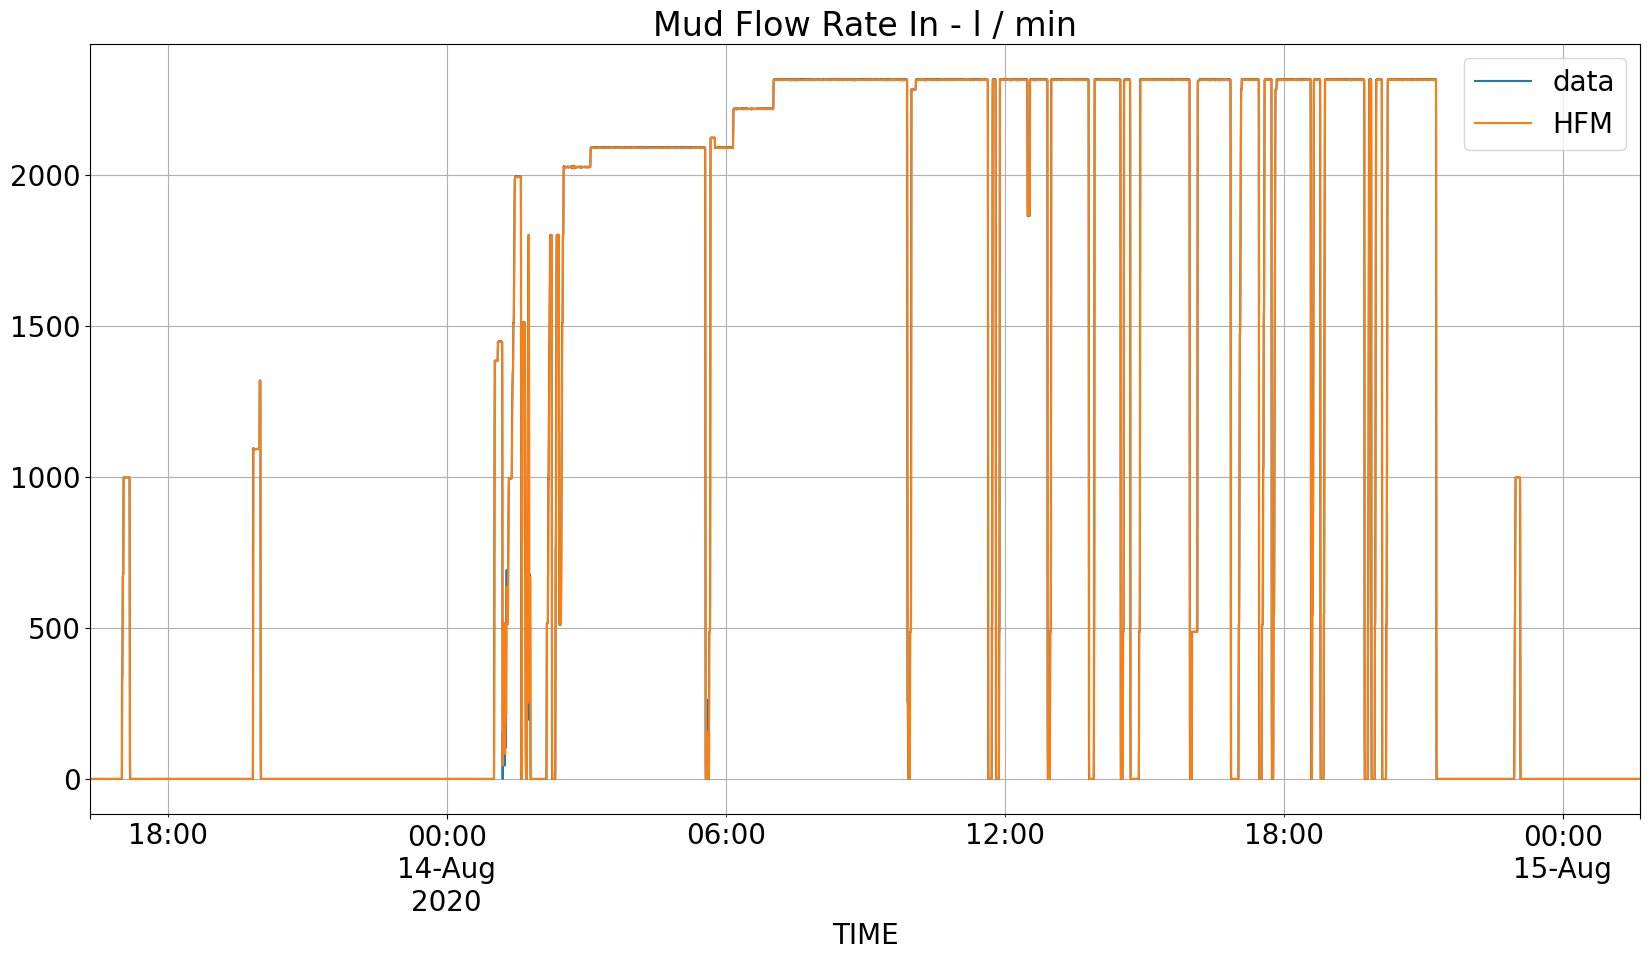

In [57]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='FLIAVG',ax=ax,label='data')
model_t_df_reinterp.plot(y='Rate_in',ax=ax,label='HFM')
ax.legend()
ax.set_title('Mud Flow Rate In - l / min')
ax.grid(which='both')
#ax.set_ylim([3,4])


#### 4- Density Mud In

(1100.0, 1600.0)

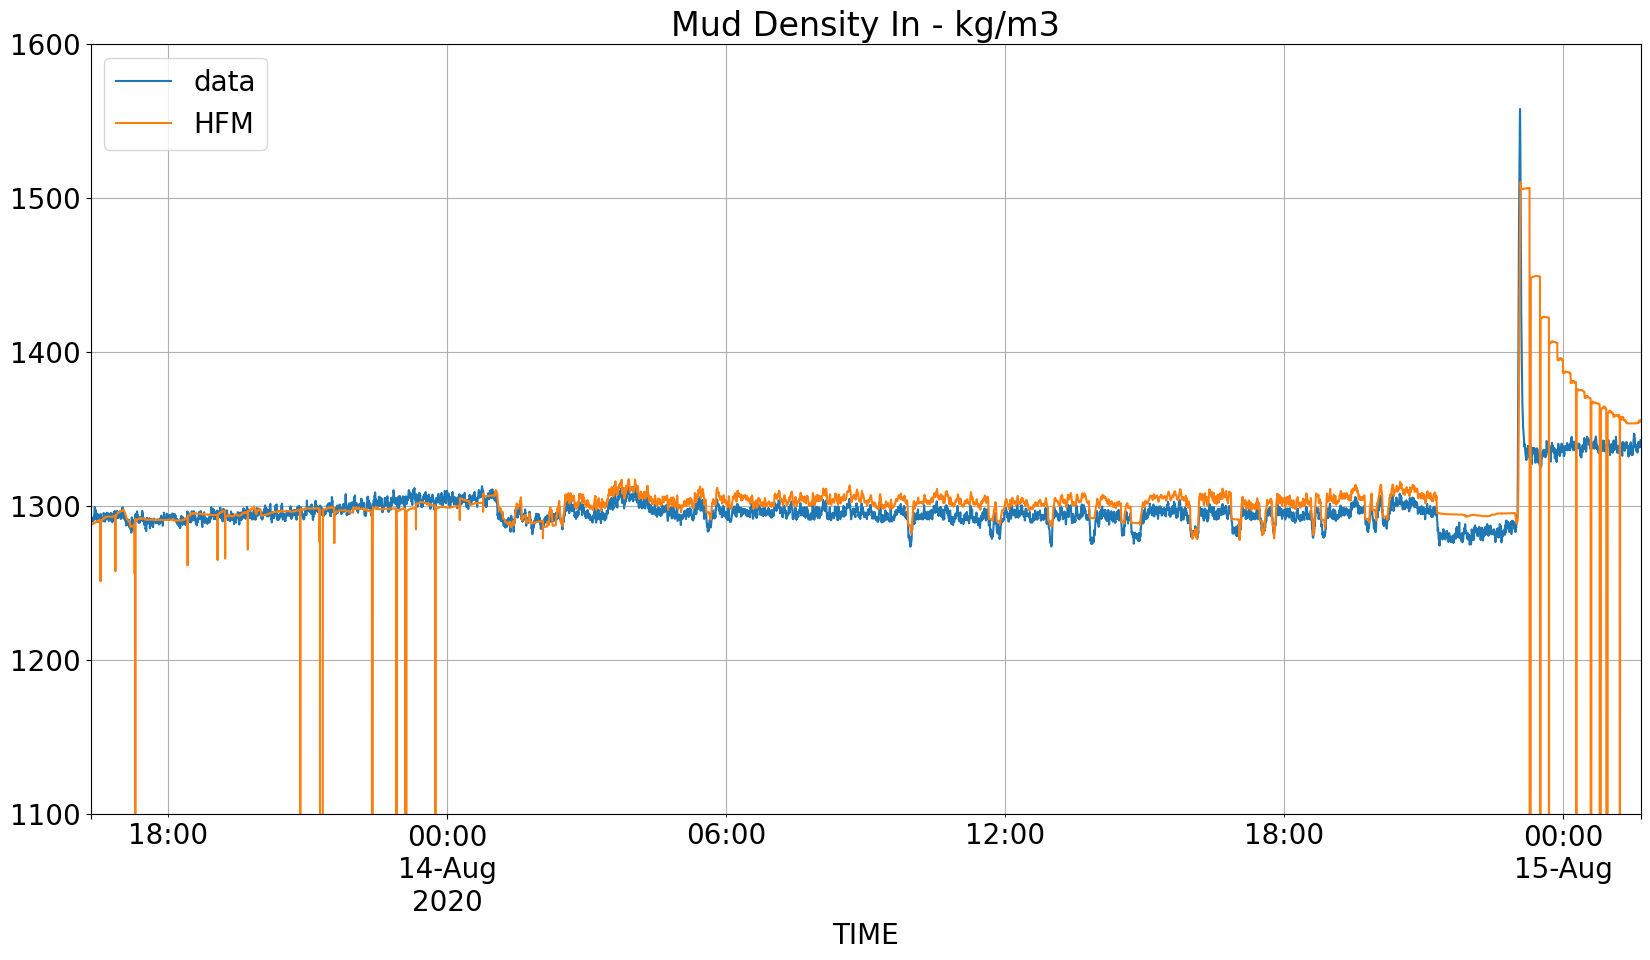

In [71]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='MUD_DENS_IN',ax=ax,label='data')
model_t_df_reinterp.plot(y='DensityIn',ax=ax,label='HFM')
ax.legend()
ax.set_title('Mud Density In - kg/m3')
ax.grid(which='both')
ax.set_ylim([1100,1600])
#ax.set_ylim([1280,1380])


#### 5- SPP



(-34.0, 348.0)

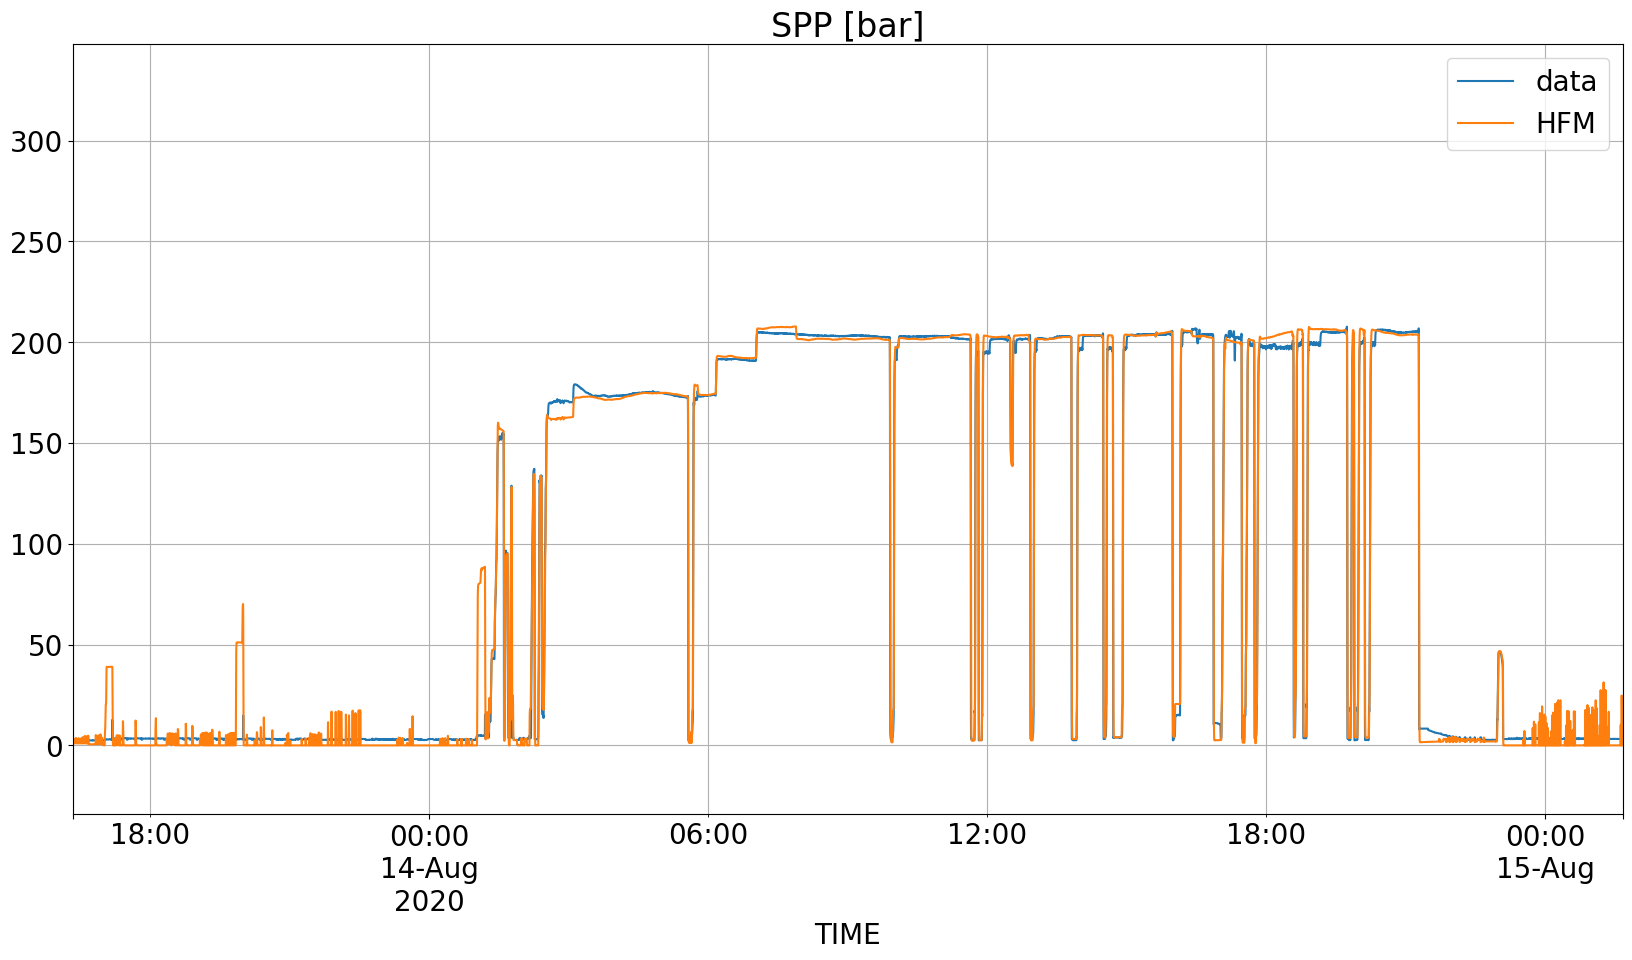

In [146]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})
data_df.plot(y='SPPAVG-T',label='data',ax=ax)
model_t_df_reinterp.iloc[:].plot(y='SPP',label='HFM',ax=ax)
ax.legend()
ax.set_title('SPP [bar]')
ax.grid(which='both')
#ax.set_ylim([-200,200])
ax.set_ylim([-34,348])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


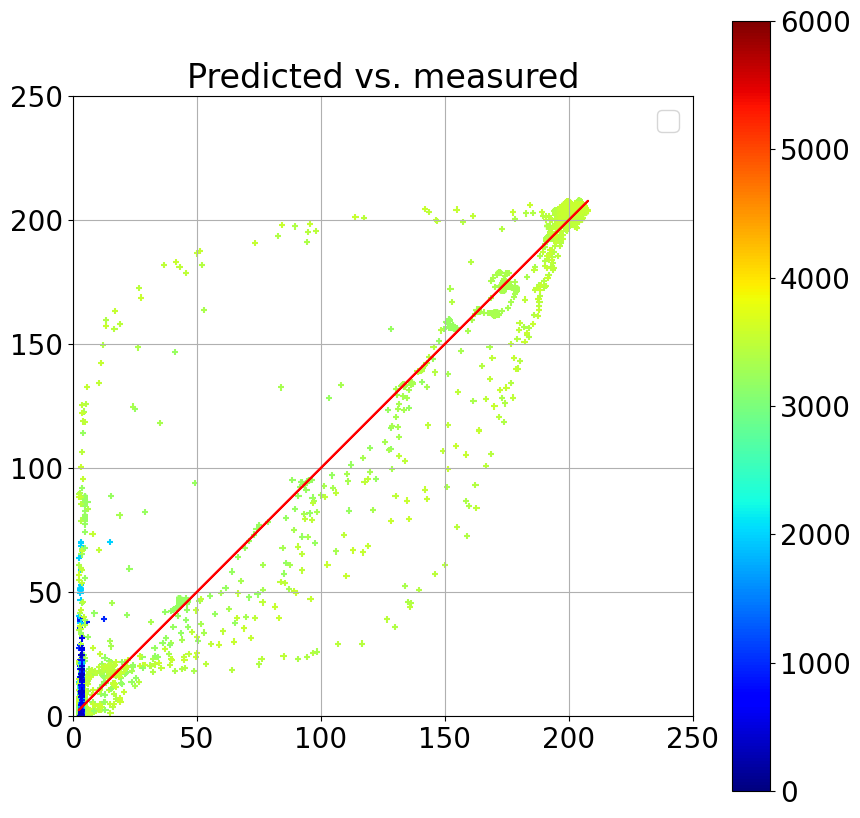

In [147]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

obj=plt.scatter(data_df.SPPAVG.values[1:],model_t_df_reinterp.SPP.values[:],20,marker='+',c=model_t_df_reinterp.mdBit.values[:],vmin=0,vmax=6000,cmap='jet')
plt.plot(data_df.SPPAVG,data_df.SPPAVG,c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('SPP Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([0,250])
ax.set_ylim([0,250])
fig.colorbar(obj,shrink=0.5)


#### 6- Density Mud Out

(1200.0, 1500.0)

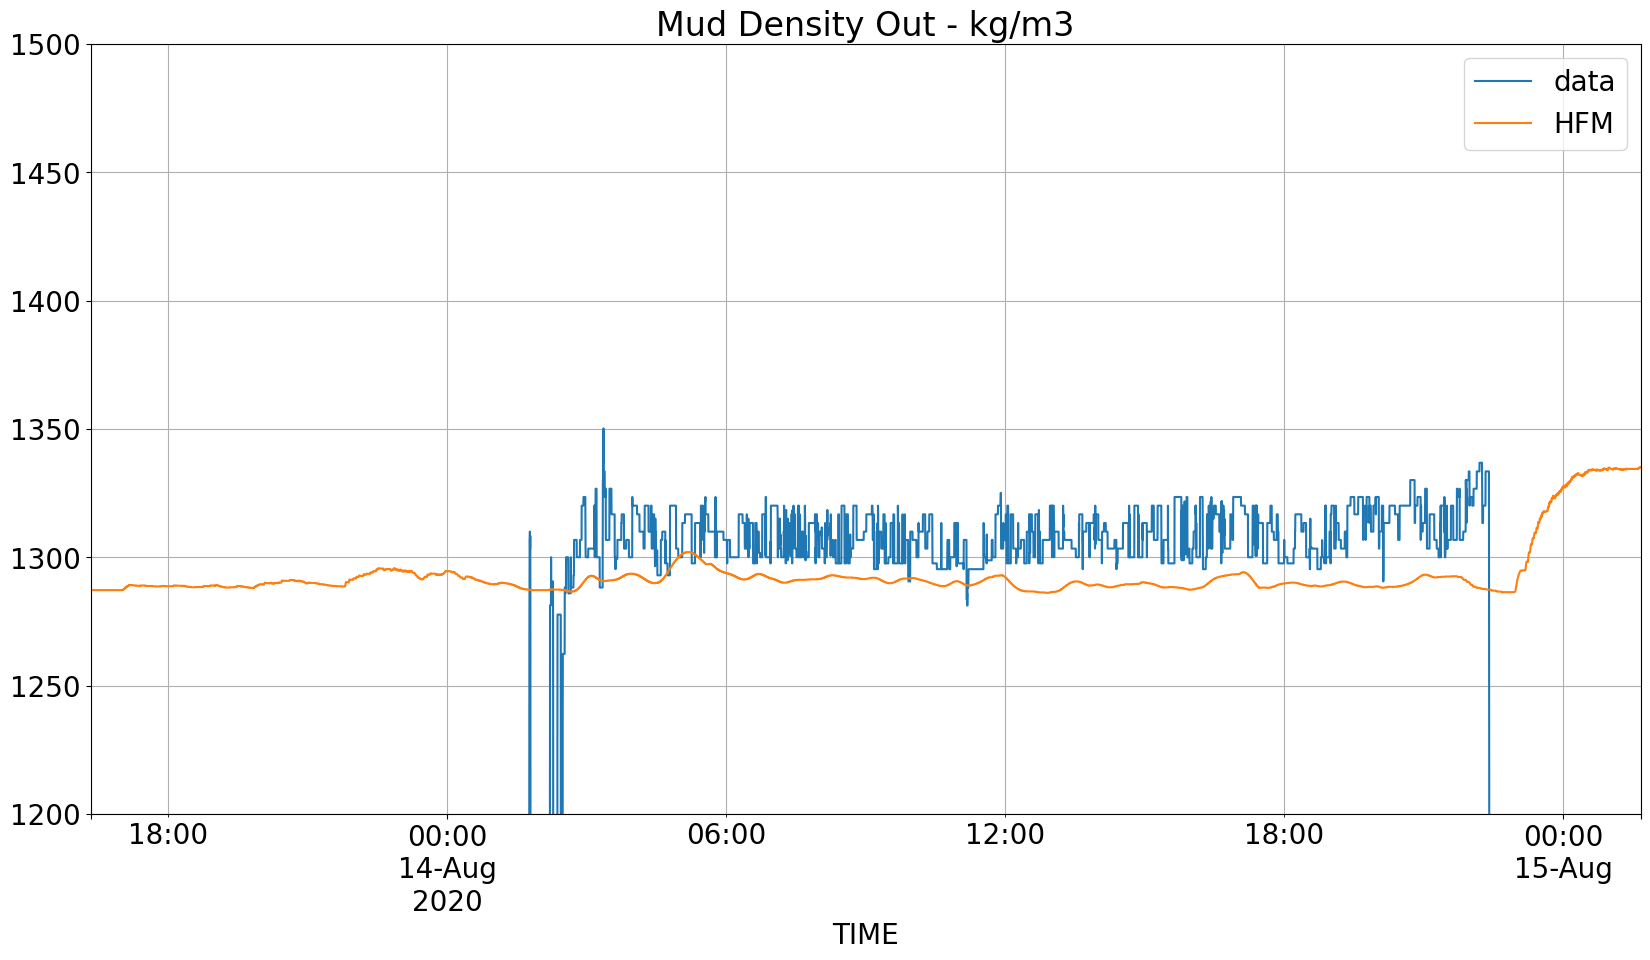

In [73]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='MUD_DENS_OUT',ax=ax,label='data')
model_t_df_reinterp.plot(y='DensityOut',ax=ax,label='HFM')
ax.legend()
ax.set_title('Mud Density Out - kg/m3')
ax.grid(which='both')
ax.set_ylim([1200,1500])
#ax.set_ylim([3,4])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


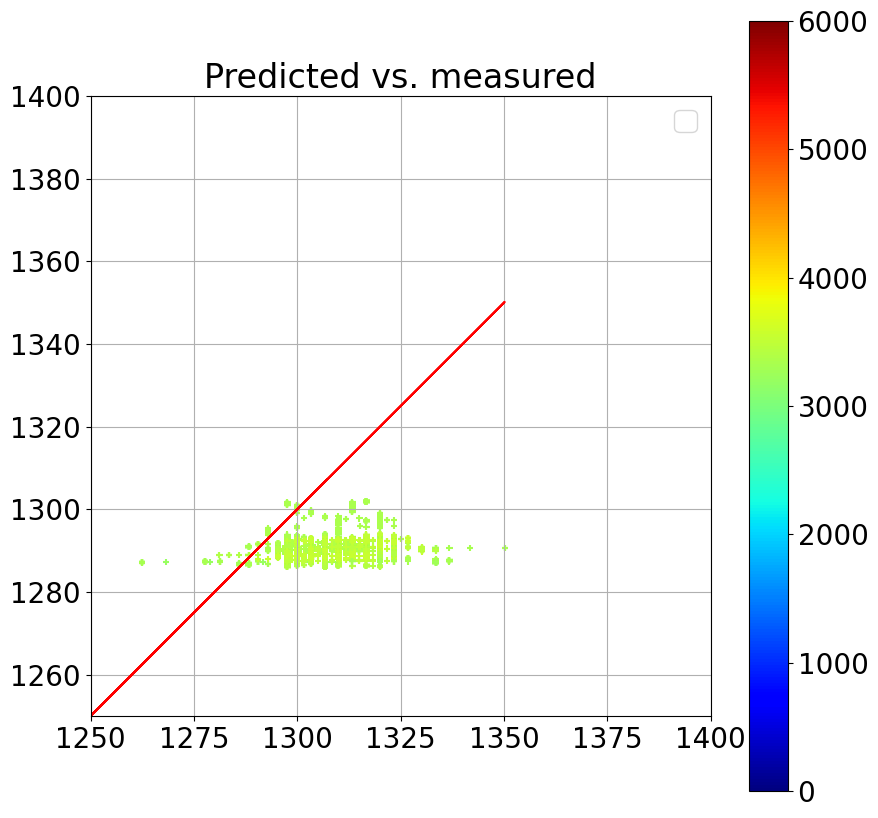

In [148]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

obj=plt.scatter(data_df.MUD_DENS_OUT.values[:-1],model_t_df_reinterp.DensityOut.values[:],20,marker='+',c=model_t_df_reinterp.mdBit.values[:],vmin=0,vmax=6000,cmap='jet')
plt.plot(data_df.loc[tstamp_min:tstamp_max:10].MUD_DENS_OUT.values[1:model_t_obs_df_reinterp.shape[0]+1],data_df.loc[tstamp_min:tstamp_max:10].MUD_DENS_OUT.values[1:model_t_obs_df_reinterp.shape[0]+1],c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([1250,1400])
ax.set_ylim([1250,1400])
fig.colorbar(obj,shrink=0.5)


#### 7 Temperature Mud Out

(0.0, 50.0)

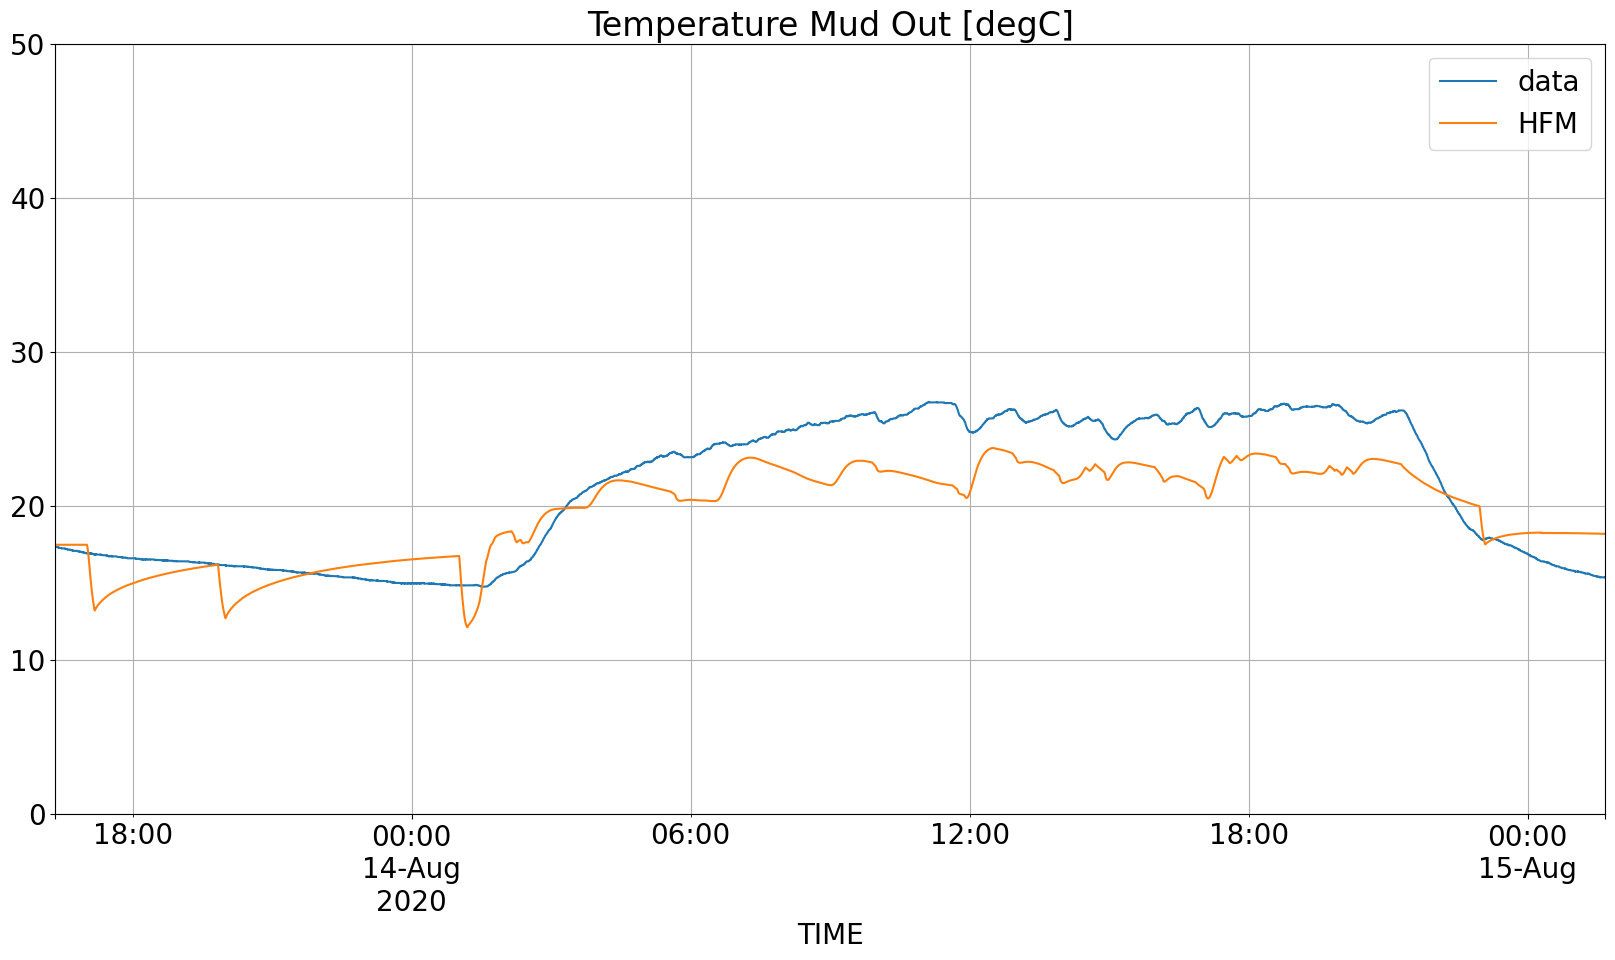

In [74]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

#data_df.plot(y='TMIAVG',ax=ax,label='data')
data_df.plot(y='TMOAVG',ax=ax,label='data')
model_t_df_reinterp.plot(y='T_top',ax=ax,label='HFM')
ax.legend()
ax.set_title('Temperature Mud Out [degC]')
ax.grid(which='both')
ax.set_ylim([0,50])
#ax.set_ylim([3,4])

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].TMOAVG.values,label='data')
#model_t_df_reinterp.plot(y='T_top', ax=ax,label='HFM Top')
data_df.plot(y='DHT001 Temp PCB Mean',ax=ax,label='data')
#plt.plot(model_t_df.T_bot.values[1:],label='HFM')
model_t_df_reinterp.plot(y='T_bot',ax=ax,label='HFM Bot')

ax.legend()
ax.set_title('Temperature Bottom [degC]')
ax.grid()
#ax.set_ylim([1200,1500])
#ax.set_ylim([3,4])

#### 8- ECD at BH / ASM

In [21]:
data_df['PRES1_ASM_recalc'] = (data_df['ASMECD1-T'])*(9.81*(data_df['ASMTVD1-T']))/100
data_df['PRES2_ASM_recalc'] = (data_df['ASMECD2-T'])*(9.81*(data_df['ASMTVD2-T']))/100


(1.2, 1.6)

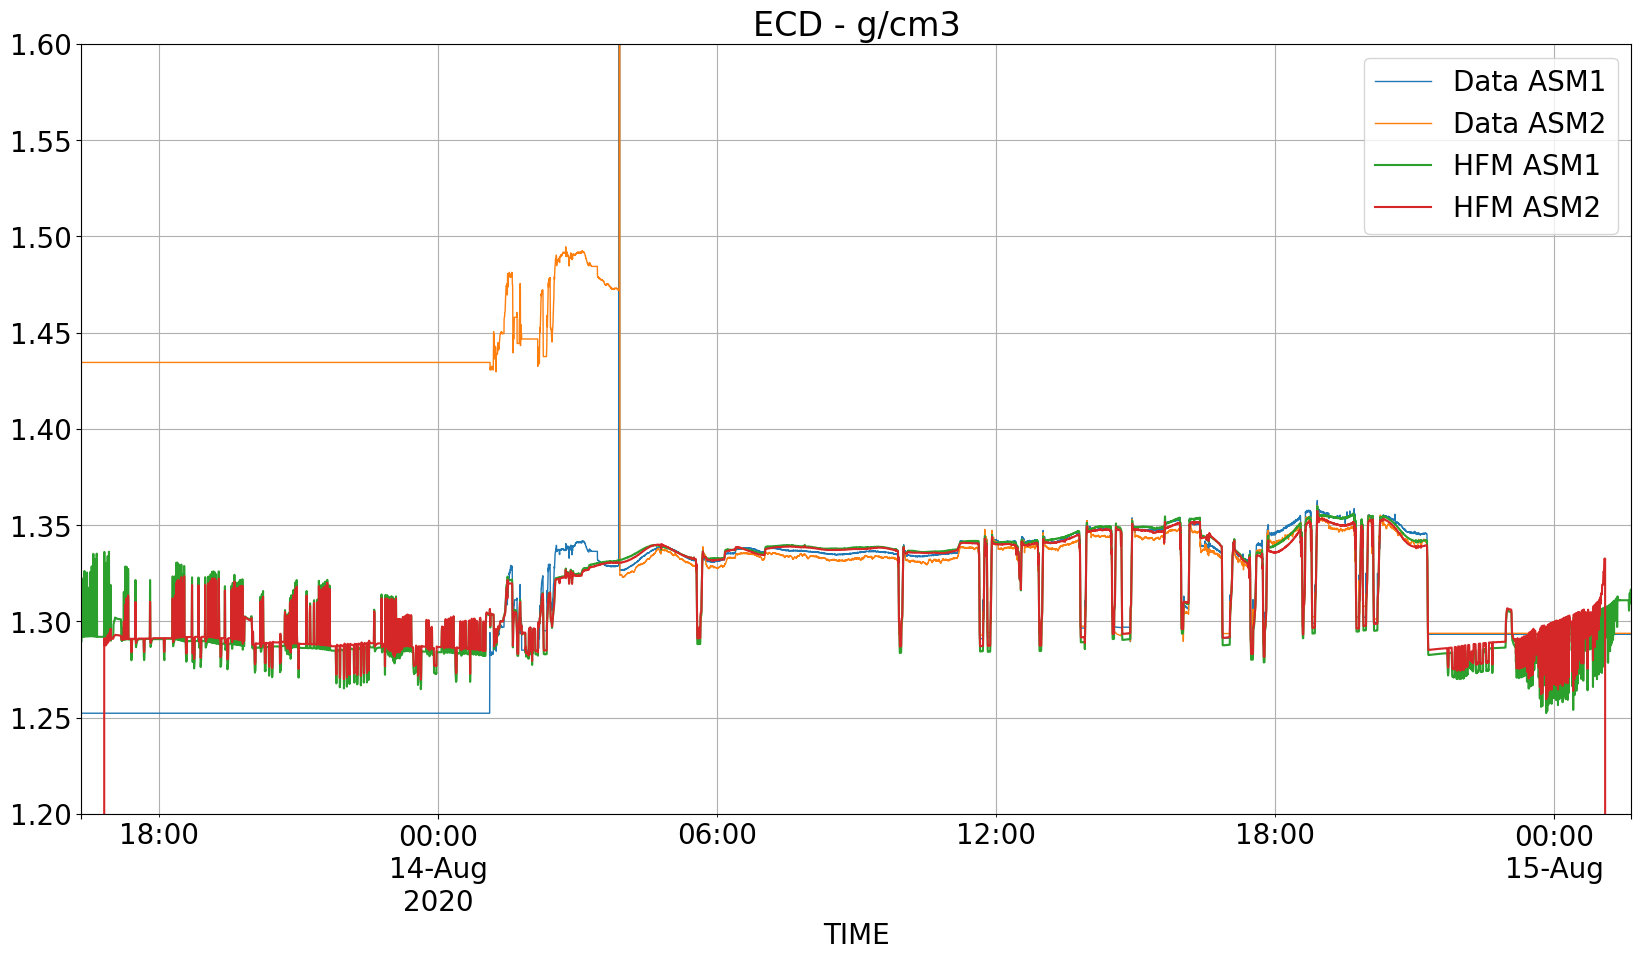

In [58]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
plt.rcParams.update({'font.size': 20})

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].DHT001_ECD.values,label='Data ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMECD2_T.values,label='Data ASM2')
data_df.plot(y='ASMECD1-T',label='Data ASM1',linewidth=1,ax=ax)
data_df.plot(y='ASMECD2-T',label='Data ASM2',linewidth=1,ax=ax)


#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMECD3_T.values,label='Data ASM3')
model_t_obs_df_reinterp.plot(y='ecdAtPos1',label='HFM ASM1',ax=ax)
model_t_obs_df_reinterp.iloc[:].plot(y='ecdAtPos2',label='HFM ASM2',ax=ax)
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:model_t_obs_df_reinterp.shape[0]+1],model_t_obs_df_reinterp.ecdAtPos3.values[:],label='HFM ASM2')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')
ax.grid(which='both')

plt.legend()
plt.title('ECD - g/cm3')
#plt.grid()
ax.set_ylim([1.2,1.6])

#Shortended based on data - not needed.
model_t_obs_df_reinterp_short=model_t_obs_df_reinterp.loc[pd.Timestamp('2020-08-14 06:00:20+00:00'):pd.Timestamp('2020-08-14 19:00:20+00:00')] #[model_t_obs_df_reinterp]
model_t_obs_df_reinterp_short['Time']=model_t_obs_df_reinterp_short.index
s1=model_t_obs_df_reinterp_short['Time']
model_t_obs_df_reinterp_short['minutes']= (s1-s1.iloc[0].normalize()).dt.total_seconds()/60
model_t_obs_df_reinterp_short['minutes']=model_t_obs_df_reinterp_short['minutes']-model_t_obs_df_reinterp_short['minutes'].min()

model_t_obs_df_reinterp_short['minutes'].describe()


In [26]:
#Change Time index to minutes column
model_t_obs_df_reinterp['Time']=model_t_obs_df_reinterp.index
s1=model_t_obs_df_reinterp['Time']
model_t_obs_df_reinterp['minutes']= (s1-s1.iloc[0].normalize()).dt.total_seconds()/60
model_t_obs_df_reinterp['minutes']=model_t_obs_df_reinterp['minutes']-model_t_obs_df_reinterp['minutes'].min()

model_t_obs_df_reinterp['minutes'].describe()


count    12000.000000
mean       999.916667
std        577.374325
min          0.000000
25%        499.958333
50%        999.916667
75%       1499.875000
max       1999.833333
Name: minutes, dtype: float64

In [27]:
#Convert to minutes - observation data
data_df['Time']=data_df.index
s=data_df['Time']
data_df['minutes']= (s-s.iloc[0].normalize()).dt.total_seconds()/60
data_df['minutes']=data_df['minutes']-data_df['minutes'].min()
data_df['minutes'].describe()

count    12001.000000
mean      1000.000000
std        577.422437
min          0.000000
25%        500.000000
50%       1000.000000
75%       1500.000000
max       2000.000000
Name: minutes, dtype: float64

Text(0, 0.5, 'Error ECD ASM2 Fortran')

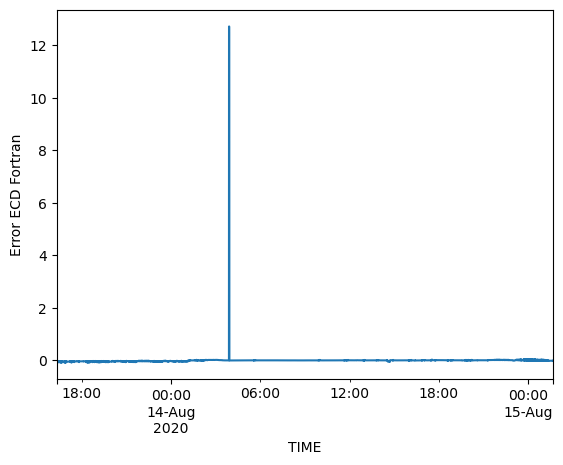

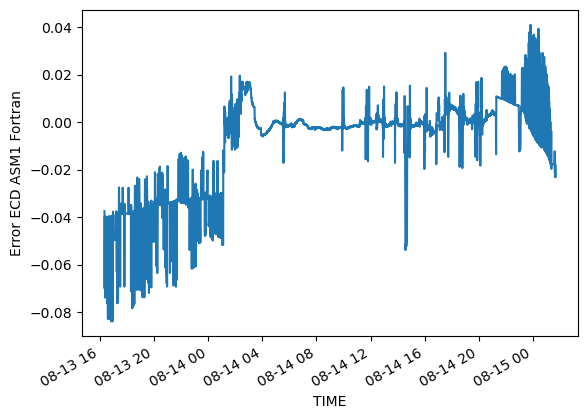

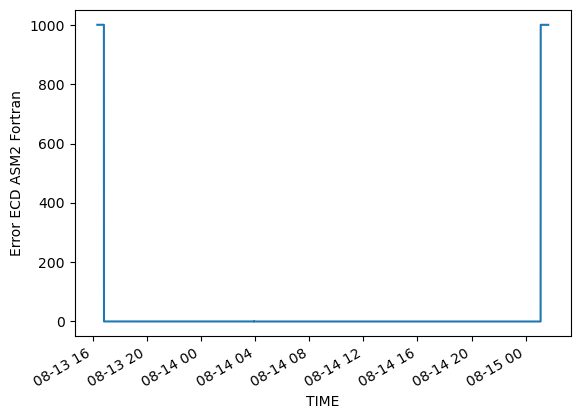

In [30]:
# Obtain Error by subtracting training and test dataset

#FORTRAN EXPERIMENT ERROR
#Syncing features of two dataset - 1. time-synced sampled experiments, and 2. fortran dataset - columns added.
df_fortran_experiment_synced = pd.concat([model_t_obs_df_reinterp.drop('minutes', axis=1),data_df[:-1].set_index(model_t_obs_df_reinterp.index)], axis=1)


#OBTAIN FORTRAN EXPERIMENT ERROR

select_column1=['minutes','ecdAtPos1','ASMECD1-T','DEP','ecdAtPos2','ASMECD2-T'] 
#select_column_fortran=['BHECD[sg]',] 


df_select_fortran1=df_fortran_experiment_synced[select_column1]

df_select_fortran_drop1=df_select_fortran1.dropna()

#eRROR=MEASUREMENT-FORTRAN. SO, WE ADD THIS ERROR TO FORTRAN OUTPUT.
df_select_fortran_drop1['Error']=df_select_fortran_drop1['ASMECD1-T']-df_select_fortran_drop1['ecdAtPos1']
df_select_fortran_drop1['Error-2']=df_select_fortran_drop1['ASMECD2-T']-df_select_fortran_drop1['ecdAtPos2']


ax1=df_select_fortran_drop1['Error'].plot()
#ax = df2.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Video streaming dropout by category')
ax1.set_ylabel("Error ECD Fortran")

df_select_fortran_drop1.drop(df_select_fortran_drop1[df_select_fortran_drop1.Error > 3].index, inplace=True)
df_select_fortran_drop1.describe()

plt.figure()
ax2=df_select_fortran_drop1['Error'].plot()
#ax = df2.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Video streaming dropout by category')
ax2.set_ylabel("Error ECD ASM1 Fortran")

plt.figure()
ax2=df_select_fortran_drop1['Error-2'].plot()
#ax = df2.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Video streaming dropout by category')
ax2.set_ylabel("Error ECD ASM2 Fortran")


In [38]:
df_select_fortran_drop1_short=df_select_fortran_drop1.loc[pd.Timestamp('2020-08-14 06:00:20+00:00'):pd.Timestamp('2020-08-14 19:00:20+00:00')] #[model_t_obs_df_reinterp]

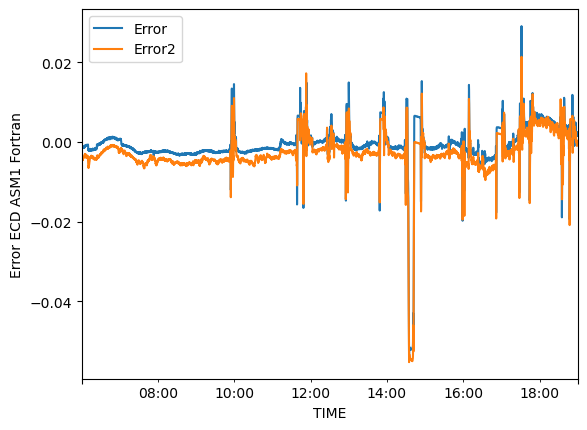

In [42]:
plt.figure()
ax2=df_select_fortran_drop1_short['Error'].plot()
ax2=df_select_fortran_drop1_short['Error-2'].plot(label='Error2 at ASM 2')
#ax = df2.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Video streaming dropout by category')
ax2.set_ylabel("Error ECD ASM1 Fortran")
ax2.legend()


In [37]:
df_select_fortran_drop1.index

DatetimeIndex(['2020-08-13 16:20:00+00:00', '2020-08-13 16:20:10+00:00',
               '2020-08-13 16:20:20+00:00', '2020-08-13 16:20:30+00:00',
               '2020-08-13 16:20:40+00:00', '2020-08-13 16:20:50+00:00',
               '2020-08-13 16:21:00+00:00', '2020-08-13 16:21:10+00:00',
               '2020-08-13 16:21:20+00:00', '2020-08-13 16:21:30+00:00',
               ...
               '2020-08-15 01:38:20+00:00', '2020-08-15 01:38:30+00:00',
               '2020-08-15 01:38:40+00:00', '2020-08-15 01:38:50+00:00',
               '2020-08-15 01:39:00+00:00', '2020-08-15 01:39:10+00:00',
               '2020-08-15 01:39:20+00:00', '2020-08-15 01:39:30+00:00',
               '2020-08-15 01:39:40+00:00', '2020-08-15 01:39:50+00:00'],
              dtype='datetime64[ns, UTC]', name='TIME', length=11993, freq=None)

In [44]:
df_select_fortran_drop1_short.columns

Index(['minutes', 'ecdAtPos1', 'ASMECD1-T', 'DEP', 'ecdAtPos2', 'ASMECD2-T',
       'Error', 'Error-2'],
      dtype='object')

1600.0
1600.1666666666665
<class 'pandas.core.series.Series'>
[1.3598988]
[1.26480018]
saved joblib for scaling function as %s  LSTM_Case102_scalingfunction.save


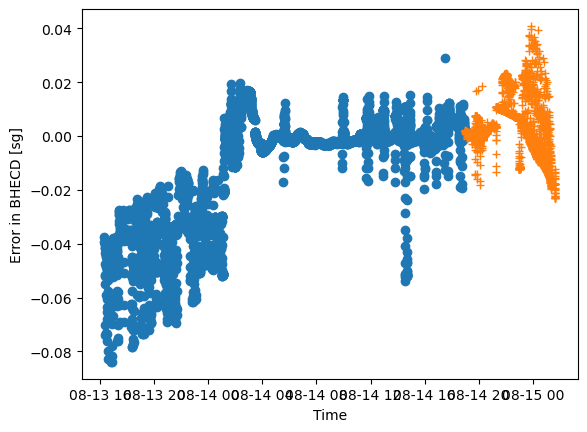

In [8]:

#
def split_timeseries(df,nfrac=0.8):
    nlen=df.shape[0]
    nrow=int(nfrac*nlen)
    train_dataset = df.iloc[:nrow, :]
    test_dataset = df.iloc[nrow:,:]
    return train_dataset,test_dataset

def split(df):
    train_dataset = df.sample(frac=0.8, random_state=0)
    test_dataset = df.drop(train_dataset.index)
    return train_dataset,test_dataset



train_dataset_measurement_fortran,test_dataset_measurement_fortran=split_timeseries(df_select_fortran_drop1)
#train_dataset_measurement_fortran_short,test_dataset_measurement_fortran_short=split_timeseries(df_select_fortran_drop1_short)

print(train_dataset_measurement_fortran.minutes.max())
print(test_dataset_measurement_fortran.minutes.min())

#Scale
#Normalize - Generate using training data always and apply same to test data later
#normalizer =    tf.keras.layers.experimental.preprocessing.Normalization(axis=-1) #tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features)) #fits the normalizer to training data. use this to transform training and test data
#print(normalizer.mean.numpy())
def scale_ANN(train_features,test_features,filename_4_scalingfunction):
    normalizer = MinMaxScaler(feature_range=(-1,1))
    print(type(train_features))
    if isinstance(train_features,pd.core.series.Series):
        normalizer_fit = normalizer.fit(train_features.values.reshape(-1,1))
        norm_train_features=normalizer_fit.transform(train_features.values.reshape(-1,1))
        norm_test_features=normalizer_fit.transform(test_features.values.reshape(-1,1))
    else:
        normalizer_fit = normalizer.fit(train_features.values)
        norm_train_features=normalizer_fit.transform(train_features.values)
        norm_test_features=normalizer_fit.transform(test_features.values)
    
    
    print(normalizer_fit.data_max_)
    print(normalizer_fit.data_min_)
    
    
    joblib.dump(normalizer_fit,filename_4_scalingfunction)
    print('saved joblib for scaling function as %s ', filename_4_scalingfunction)
    return norm_train_features,norm_test_features,normalizer_fit 
#scaled_errortraintarget=scalerIn3_errortraintarget.transform(error_train_target.reshape(-1,1)).reshape(error_train_target.shape[0],error_train_target.shape[1],error_train_target.shape[2])
#print('scaled error train target',scaled_errortraintarget.shape)


 
#filename = 'LSTM Models/NIROM_output_scaler_drilling.save'
#joblib.dump(scalerOut3,filename) 


#label test train for matlab-measurement
label_train_measurement_fortran=train_dataset_measurement_fortran['Error'] # .iloc[:,-1] # error in sg unit for BHECD
label_test_measurement_fortran=test_dataset_measurement_fortran['Error'] #.iloc[:,-1] # error in sg unit for BHECD

#label_train_measurement_fortran_short=train_dataset_measurement_fortran_short['Error2'] # .iloc[:,-1] # error in sg unit for BHECD
#label_test_measurement_fortran_short=test_dataset_measurement_fortran_short['Error2']

#feature time in minutes and BHECD from matlab
training_features_measurement_fortran=train_dataset_measurement_fortran['ecdAtPos1'] # Scaled as per simulation dataset values and not as per. .iloc[:,1] # :3 has time in minutes,BHECD from fortran in sg,depth in m, Error in sg
testing_features_measurement_fortran=test_dataset_measurement_fortran['ecdAtPos1']

#training_features_measurement_fortran_short=train_dataset_measurement_fortran_short['ecdAtPos2'] # Scaled as per simulation dataset values and not as per. .iloc[:,1] # :3 has time in minutes,BHECD from fortran in sg,depth in m, Error in sg
#testing_features_measurement_fortran_short=test_dataset_measurement_fortran_short['ecdAtPos2']
#print(label_train_measurement_matlab.shape)
#print(label_test_measurement_matlab.shape)
#print(training_features_measurement_matlab.shape)
#print(testing_features_measurement_matlab.shape)

#Scale the trainind dataset for ANN
filename_4_scalingfunction = 'LSTM_Case102_scalingfunction.save'

#Error - https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
norm_train_features_fortran_measurement,norm_test_features_fortran_measurement,normalizer_fit=scale_ANN(training_features_measurement_fortran,testing_features_measurement_fortran,filename_4_scalingfunction)     
#(training_features_measurement_fortran.values,testing_features_measurement_fortran.values,filename_4_scalingfunction)
#.reshape(-1, 1)

#Use

plt.figure()
plt.plot(label_train_measurement_fortran,'o')
plt.plot(label_test_measurement_fortran,'+')
plt.ylabel('Error in BHECD [sg]')
plt.xlabel('Time')
plt.savefig('LSTM_training_testing_data.png')
#plt.plot(training_features_measurement_fortran.DEP,'go')
#plt.plot(testing_features_measurement_fortran.DEP,'b+')

#plt.plot(label_train_measurement_matlab,'o')

#plt.plot(norm_train_features_matlab_measurement)
#plt.plot(norm_test_features_matlab_measurement,'o')



In [12]:
label_train_measurement_fortran.values

array([-0.03749187, -0.03949187, -0.04149187, ...,  0.00187702,
        0.00169143,  0.00162603])

In [4]:
dirFile='LSTM_Case102_220823'

cwd = os.getcwd()    
path2=os.path.join(cwd,dirFile)
isExist = os.path.exists(path2)
if not isExist:  
  
  # Create a new directory because it does not exist 
    os.makedirs(path2)
    print("The new directory is created!")

#plt.savefig(os.path.abspath(dirFile+'/'+'Case2a1_lstm_full_figure_new.png'))


In [81]:
#Save all datasets
df_fortran_experiment_synced.to_pickle(dirFile+'/'+'df_fortran_experiment_synced.pkl')
df_select_fortran_drop1.to_pickle(dirFile+'/'+'df_select_fortran_drop1.pkl')

train_dataset_measurement_fortran.to_pickle(dirFile+'/'+'Clean_Case102_train_dataset_measurement_fortran.pkl')
test_dataset_measurement_fortran.to_pickle(dirFile+'/'+'Clean_Case102_test_dataset_measurement_fortran.pkl')

joblib.dump(normalizer_fit,os.path.abspath(dirFile+'/'+filename_4_scalingfunction))


In [83]:
np.save(os.path.abspath(dirFile+'/'+'norm_train_features_fortran_measurement.npy'),norm_train_features_fortran_measurement)

np.save(os.path.abspath(dirFile+'/'+'norm_test_features_fortran_measurement.npy'),norm_test_features_fortran_measurement)



In [43]:
# Load all saved dataset 
dirFile='LSTM_Case102_220823'
filename_4_scalingfunction = 'LSTM_Case102_scalingfunction.save'
df_fortran_experiment_synced=pd.read_pickle(dirFile+'/'+'df_fortran_experiment_synced.pkl')
df_select_fortran_drop1=pd.read_pickle(dirFile+'/'+'df_select_fortran_drop1.pkl')
df_fortran_experiment_synced = pd.read_pickle(dirFile+'/'+'df_fortran_experiment_synced.pkl')
norm_train_features_fortran_measurement=np.load(os.path.abspath(dirFile+'/'+'norm_train_features_fortran_measurement.npy'))
norm_test_features_fortran_measurement=np.load(os.path.abspath(dirFile+'/'+'norm_test_features_fortran_measurement.npy'))

train_dataset_measurement_fortran=pd.read_pickle(dirFile+'/'+'Clean_Case102_train_dataset_measurement_fortran.pkl')
test_dataset_measurement_fortran=pd.read_pickle(dirFile+'/'+'Clean_Case102_test_dataset_measurement_fortran.pkl')

normalizer_fit=joblib.load(os.path.abspath(dirFile+'/'+filename_4_scalingfunction))  #Same for both rolling and non-rolling LSTM.

In [17]:
for i in range(2,5): # Range does not include the last stop. Here range is (lb-1,m) for "error" training - because we select the last index in the sample which starts from lb-1 and ends at m-1.
    print(i)

for j in range(3): # 5-3+1 , Range does not include the last stop.  Here num of samples in xtrain is (m-lb+1). So for m=5,lb=3 -there are 3 samples. "j" is start of index for each sample. So 0 considering 0 indexing. The index needed to  first sample is 0,1,2.
    print(j)    

2
3
4
0
1
2


In [6]:
def create_training_data_lstm_4drilling1(training_set, lookback,errortraining=None): #Include Errortraining here.
  
    #Input shape of training set and error training is 2D ns by Q    
    print('training_shape',training_set.shape)
    m=training_set.shape[0]     
    Q=training_set.shape[1]
    Q1=errortraining.shape[1]
    training_set=training_set.to_numpy()
    print('sample',m,'Q_train',Q,'Q1_test',Q1)
    if errortraining is not None :
        print('error_training_shape',errortraining.shape)
        ytrain = [errortraining.iloc[i,:Q1] for i in range(lookback-1,m)] # errortraining.iloc[i,:Q1] , Remember zero-indexing so error corresponding to index i , i starts from lookback-1 and ends at m-1. select column error by selecting 0 (:1). Appends the list using list comprehension - Extract Q modes each time for m-lookback number of times
        #ytrain = [errortraining.iloc[i,:Q1] for i in range(m)]  #works for lookback equal to 1 and check for lookback>1
        
        ytrain = np.array(ytrain) #"2D array of size sample (m-lookback) x Grid size
        
        print('YTRAIN_SHAPE',ytrain.shape)        
        
    else:
        ytrain=None
               
    xtrain = np.zeros((m-lookback+1,lookback,Q))
    xtrain_we = np.zeros((m-lookback+1,lookback,Q))
    
    #print(ytrain)
    for i in range(m-lookback+1): #(m-lookback): #number of samples is "m-lookback + 1", and for each sample/time index i (row of xtrain)
        #print(i)
        a = training_set[i,:Q] #if Q+1 then obtain variable values for features Q+1 for time index i (Q is grids, Q+1 for parameter value - time step here.)

        for j in range(1,lookback): # Obtain coefficients for time index i+j for look-back times foe each sample.
            #print(i,j)
            a = np.vstack((a,training_set[i+j,:Q])) # Add to row. concatenate in loop all feature Q values for different time steps,see the beautiful use of vstack to create for a given sample i, a 2D array of coefficients with lookback rows x Q mode columns 
               
        xtrain[i,:,:] = a  # 
        xtrain_we[i,:,:]=a
        if i>0:
            A3=normalizer_fit.inverse_transform(xtrain_we[i,lookback-2,:].reshape(-1, 1))+ytrain[i-1,:] #y - error is not scaled, but feature values in xtrain_we is scaled. so we unscale it to add. 
            print(A3,'A3shape')             
            A2=normalizer_fit.transform(A3)
            print(A2,'A2shape')
            xtrain_we[i,lookback-2,:]=A2
    print('YTRAIN_SHAPE',ytrain.shape)         
    print('XTRAIN_SHAPE',xtrain.shape)   
    print('XTRAINWE_SHAPE',xtrain_we.shape)       
    return xtrain,ytrain,xtrain_we  #,xtrain_3D,ytrain_1D #3D shape ns,lookback,1        


# 

In [7]:
lookback=3
xtrain,ytrain,xtrain_we=create_training_data_lstm_4drilling1(pd.DataFrame(norm_train_features_fortran_measurement), lookback,pd.DataFrame(label_train_measurement_fortran))
print(xtrain.shape)
print(ytrain.shape)

NameError: name 'label_train_measurement_fortran' is not defined

In [21]:
xtest,ytest,xtest_we=create_training_data_lstm_4drilling1(pd.DataFrame(norm_test_features_fortran_measurement), lookback,pd.DataFrame(label_test_measurement_fortran))
print(xtest.shape)
print(ytest.shape)

training_shape (2399, 1)
sample 2399 Q_train 1 Q1_test 1
error_training_shape (2399, 1)
YTRAIN_SHAPE (2397, 1)
[[1.35698671]] A3shape
[[0.93875637]] A2shape
[[1.35681404]] A3shape
[[0.93512498]] A2shape
[[1.35715279]] A3shape
[[0.94224916]] A2shape
[[1.35695608]] A3shape
[[0.93811219]] A2shape
[[1.35651406]] A3shape
[[0.92881621]] A2shape
[[1.35672231]] A3shape
[[0.93319583]] A2shape
[[1.35672094]] A3shape
[[0.933167]] A2shape
[[1.35685115]] A3shape
[[0.93590552]] A2shape
[[1.35643405]] A3shape
[[0.92713343]] A2shape
[[1.35673371]] A3shape
[[0.93343557]] A2shape
[[1.35643077]] A3shape
[[0.92706449]] A2shape
[[1.35680645]] A3shape
[[0.93496533]] A2shape
[[1.35643403]] A3shape
[[0.92713301]] A2shape
[[1.35695794]] A3shape
[[0.93815136]] A2shape
[[1.35647754]] A3shape
[[0.9280482]] A2shape
[[1.35668914]] A3shape
[[0.93249814]] A2shape
[[1.35623172]] A3shape
[[0.9228784]] A2shape
[[1.35630784]] A3shape
[[0.92447928]] A2shape
[[1.35637045]] A3shape
[[0.92579591]] A2shape
[[1.35601328]] A3sh

In [22]:
np.save(os.path.abspath(dirFile+'/'+'xtrain_Case102'),xtrain)
np.save(os.path.abspath(dirFile+'/'+'xtrain_WERolling_Case102'),xtrain_we)
np.save(os.path.abspath(dirFile+'/'+'ytrain_Case102'),ytrain)

np.save(os.path.abspath(dirFile+'/'+'xtest_Case102'),xtest)
np.save(os.path.abspath(dirFile+'/'+'xtest_WERolling_Case102'),xtest_we)
np.save(os.path.abspath(dirFile+'/'+'ytest_Case102'),ytest)
#train_dataset_measurement_fortran.to_pickle(dirFile+'/'+'Clean_Case2B_train_dataset_measurement_fortran.pkl')
#test_dataset_measurement_fortran.to_pickle(dirFile+'/'+'Clean_Case2B_test_dataset_measurement_fortran.pkl')




# Non-Rolling LSTM :  Train LSTM for non-rolling LSTM. Input is not corrected. 

In [25]:

Q=xtrain.shape[2] #check - what is Q? It is number of features. Should be 1 in this case.

lookback=3
epochs=150
batch_size=30
n_neurons=80 #trial.suggest_int('n_neurons',85,125, step=20)

%run LSTM/utility_LSTM-Drilling.ipynb
lstmtype=2
activation = "tanh" #trial.suggest_categorical("activation", ["relu", "tanh"])

dropout=0

Ngrid=False #used in case we have training data at all grid points.
if Ngrid:
    Ng=ncolumn
else:
    Ng=1
    
if lstmtype==2: 
    model3 = Sequential()
    model3.add(LSTM(n_neurons, input_shape=(lookback, Q), return_sequences=True, activation=activation)) # 
    model3.add(LSTM(n_neurons,  return_sequences=True, activation=activation,dropout=dropout)) # dropout=dropout 'tanh'
    #model3.add(LSTM(n_neurons,  activation='tanh',dropout=dropout)) #should give a vector with 60 elements.
    model3.add(LSTM(n_neurons,  activation=activation,dropout=dropout))
    model3.add(Dense(Ng,activation='linear')) #gives Q output values 
elif lstmtype==3: #Stateful LSTM (Avoid)
    #https://stackoverflow.com/questions/64309194/invalidargumenterror-specified-a-list-with-shape-60-9-from-a-tensor-with-shap
    model3 = Sequential() 
    bs=40
    model3.add(LSTM(n_neurons,batch_input_shape=(bs,lookback,Q+1), activation='tanh',stateful=True,return_sequences=True)) # return_sequences=True, 
    #model3.add(LSTM(n_neurons,return_sequences=True, activation='tanh',dropout=dropout,stateful=True)) # dropout=dropout
    model3.add(LSTM(n_neurons, activation='tanh',dropout=dropout,stateful=False)) #should give a vector with 60 elements.
    model3.add(Dense(Ng)) #gives Q output values
else: #SimpleLSTM
    model3 = Sequential()
    model3.add(LSTM(n_neurons, input_shape=(lookback, Q), return_sequences=False, activation='tanh')) # 
    #model3.add(LSTM(n_neurons, input_shape=(lookback, Q+1), return_sequences=True, activation='tanh',dropout=dropout)) # dropout=dropout
    #model3.add(LSTM(n_neurons, input_shape=(lookback, Q+1), activation='tanh',dropout=dropout)) #should give a vector with 60 elements.
    model3.add(Dense(Ng))

# compile model
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = keras.callbacks.ModelCheckpoint('best_model_lstm_case102.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=40, min_lr=0.0001)
#callbacks=[es,mc,reduce_lr]

# Shuffling data
#perm = np.random.permutation(Training_xtrain_set.shape[0])
#xtrain = Training_xtrain_set[perm,:,:]
#ytrain = Training_ytrain_set[perm,:]


2.6.0
1.0.2


In [26]:
 #Nonrolling LSTM: Run the model
history = model3.fit(xtrain,ytrain, epochs=epochs, batch_size=batch_size, validation_split=0.1,\
                     callbacks=[es,mc,reduce_lr])

# Evaluate the model 
loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/150
288/288 [==============================] - 18s 19ms/step - loss: 2.3418e-04 - mse: 2.3418e-04 - val_loss: 2.4131e-04 - val_mse: 2.4131e-04

Epoch 00001: val_loss improved from inf to 0.00024, saving model to best_model_lstm_case102.h5
Epoch 2/150
288/288 [==============================] - 4s 15ms/step - loss: 2.2891e-04 - mse: 2.2891e-04 - val_loss: 1.6620e-04 - val_mse: 1.6620e-04

Epoch 00002: val_loss improved from 0.00024 to 0.00017, saving model to best_model_lstm_case102.h5
Epoch 3/150
288/288 [==============================] - 4s 14ms/step - loss: 2.2832e-04 - mse: 2.2832e-04 - val_loss: 2.2936e-04 - val_mse: 2.2936e-04

Epoch 00003: val_loss did not improve from 0.00017
Epoch 4/150
288/288 [==============================] - 4s 13ms/step - loss: 2.2710e-04 - mse: 2.2710e-04 - val_loss: 1.6524e-04 - val_mse: 1.6524e-04

Epoch 00004: val_loss improved from 0.00017 to 0.00017, saving model to best_model_lstm_case102.h5
Epoch 5/150
288/288 [==============================

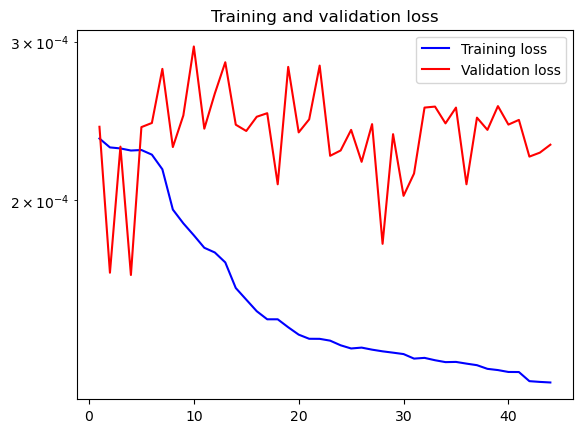

xtrain shape for fit (9592, 3, 1)
ytrain shape for fit (9592, 1)
mse: 0.01%
xtrain shape for fit (9592, 3, 1)
ytrain shape for fit (9592, 1)
mse: 0.013551%
mse: 0.087313%


In [27]:
plt.figure()
epochs = range(1, len(loss) + 1)
plt.semilogy(epochs, loss, 'b', label='Training loss')
plt.semilogy(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
filename = 'Case102_loss_NonRollingHAM_lstm.png'
plt.savefig(os.path.abspath(dirFile+'/'+filename), dpi = 200)
plt.show()

# Save the model=
model_name='Case102_NonRolling_LSTMDrilling.h5'
model3.save(os.path.abspath(dirFile+'/'+model_name))

# Save the scales
#filename = 'LSTM Models/NIROM_input_scaler_drilling1.save'
#joblib.dump(scalerIn3,filename) 
#filename = 'LSTM Models/NIROM_output_scaler_drilling1.save'
#joblib.dump(scalerOut3,filename) 
#print ("VALIDATION LOSS", val_loss[-1])
print('xtrain shape for fit',xtrain.shape)
print('ytrain shape for fit',ytrain.shape)
scores = model3.evaluate(xtrain, ytrain, verbose=0)
print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))


print('xtrain shape for fit',xtrain.shape)
print('ytrain shape for fit',ytrain.shape)
scores = model3.evaluate(xtrain, ytrain, verbose=0)
print("%s: %.6f%%" % (model3.metrics_names[1], scores[1]*100))

scores = model3.evaluate(xtest, ytest, verbose=0)
print("%s: %.6f%%" % (model3.metrics_names[1], scores[1]*100))

# xtest.shape



In [28]:
print(xtest.shape)

(2397, 3, 1)


In [29]:
addcorrection=model3.predict(xtest)

In [30]:
addcorrection.shape

(2397, 1)

In [34]:
model3.predict(xtrain).shape

(9592, 1)

In [33]:
print(train_dataset_measurement_fortran.iloc[2:,].shape)

test_dataset_measurement_fortran.shape

(9592, 5)


(2399, 5)

In [37]:
train_dataset_measurement_fortran.columns

Index(['minutes', 'ecdAtPos1', 'ASMECD1-T', 'DEP', 'Error'], dtype='object')

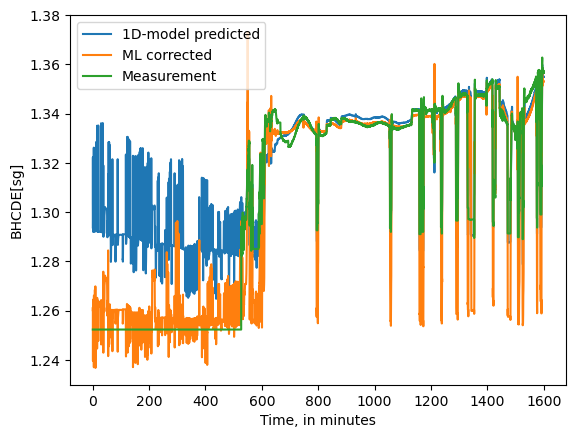

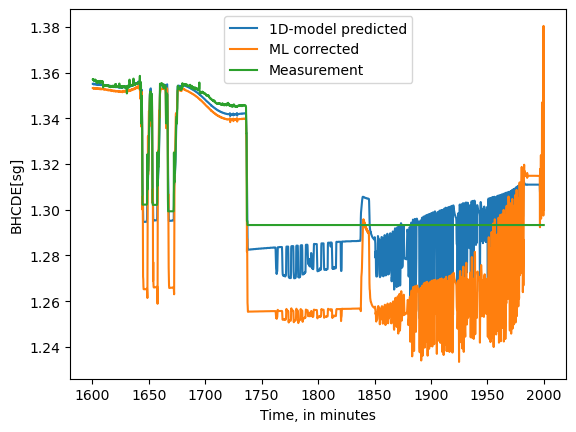

In [40]:
#filename_4_scalingfunction = 'LSTM_Case2A1_Full_Measurement_Fortran_scalingfunction.save'
#normalizer_fit=joblib.load(filename_4_scalingfunction) 
corrected_xtest=normalizer_fit.inverse_transform(xtest[:,-1,:])+addcorrection #[:,:]
corrected_xtrain=normalizer_fit.inverse_transform(xtrain[:,-1,:])+model3.predict(xtrain)

train_measurement=train_dataset_measurement_fortran['ASMECD1-T'].iloc[2:,] #starts from 2 - because error is obained for 3 sample which is index=2.
test_measurement=test_dataset_measurement_fortran['ASMECD1-T'].iloc[2:,]

time_xaxis_in_minutes_train=train_dataset_measurement_fortran['minutes'].iloc[2:,]
time_xaxis_in_minutes_TEST=test_dataset_measurement_fortran['minutes'].iloc[2:,]

plt.figure()
plt.plot(time_xaxis_in_minutes_train,normalizer_fit.inverse_transform(xtrain[:,-1,:]),label='1D-model predicted')
plt.plot(time_xaxis_in_minutes_train,corrected_xtrain,label='ML corrected')
plt.plot(time_xaxis_in_minutes_train,train_measurement,label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_Traindata.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_Traindata.pdf'))

plt.figure()
plt.plot(time_xaxis_in_minutes_TEST,normalizer_fit.inverse_transform(xtest[:,-1,:]),label='1D-model predicted')
plt.plot(time_xaxis_in_minutes_TEST,corrected_xtest,label='ML corrected')
plt.plot(time_xaxis_in_minutes_TEST,test_measurement,label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_TEST_data.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_TEST_data.pdf'))


In [49]:
# (Non Rolling):Test generalization at different locations results_z 
#At each depth, convert the time_series to the form of xtrain_we.
#Apply model.predict over the whole xtrain_we
def testing_lstm_4drilling_nonrolling(training_set,lookback):      
    #Input shape of training set and error training is 2D ns by Q
    print('training_shape',training_set.shape)
    m=training_set.shape[0]     
    Q=training_set.shape[1] 
    # training_set=training_set.to_numpy() not needed for ndarrat 
    print('Sample',m ,' Input Feature shape ',Q)     
               
    # Below: Obtain both predictions from model and create subsequent training data in Rolling LSTM format and Non-Rolling form.
          
    # Non-Rolling involves not correcting the input. Using uncorrected input for the next sample.
    
    xtrain = np.zeros((m-lookback+1,lookback,Q))
    # xtrain_we = np.zeros((m-lookback+1,lookback,Q))
    # ycorrect = np.zeros((m-lookback+1))
       
    for i in range(m-lookback+1): #(m-lookback): #number of samples is "m-lookback + 1", and for each sample/time index i (row of xtrain). On range the loop starts from 0 and ends at m-lookback.
        a = training_set[i,:Q] #if Q+1 then obtain variable values for features Q+1 for time index i (Q is grids, Q+1 for parameter value - time step here.)

        for j in range(1,lookback): # Obtain coefficients for time index i+j for look-back times foe each sample.
            #print(i,j)
            a = np.vstack((a,training_set[i+j,:Q])) # Add to row. concatenate in loop all feature Q values for different time steps,see the beautiful use of vstack to create for a given sample i, a 2D array of coefficients with lookback rows x Q mode columns 

        
        xtrain[i,:,:] = a  # 
        # xtrain_we[i,:,:]=a #i=0, 0,1,2 #i=1, 1,2,3. To add to the middle one.
        #print('XTRAIN_SHAPE',xtrain_we[i,:,:].shape)
        #print('XTRAIN_SHAPE',xtrain.shape)
        
           
    print('XTRAIN_j_SHAPE',xtrain.shape)       
                
    return xtrain  #,xtrain_3D,ytrain_1D #3D shape ns,lookback,1       



In [50]:
df_select_fortran_drop1_short.columns

Index(['minutes', 'ecdAtPos1', 'ASMECD1-T', 'DEP', 'ecdAtPos2', 'ASMECD2-T',
       'Error', 'Error-2'],
      dtype='object')

In [58]:
corrected_xtrain_asm2=normalizer_fit.inverse_transform(xtrain_asm2[:,-1,:])[:,0]+model3_Case102_nonrolling.predict(xtrain_asm2)[:,0]

In [59]:
corrected_xtrain_asm2.shape

(4679,)

In [62]:
ASM2_xtrain_ECD_simulation.shape

(4679, 1)

# Location-specific generalization 

-0.6466863639765812
0.947423002855615
training_shape (4681, 1)
Sample 4681  Input Feature shape  1
XTRAIN_j_SHAPE (4679, 3, 1)
(4679, 3, 1)
measurement_asm2 (4679,)


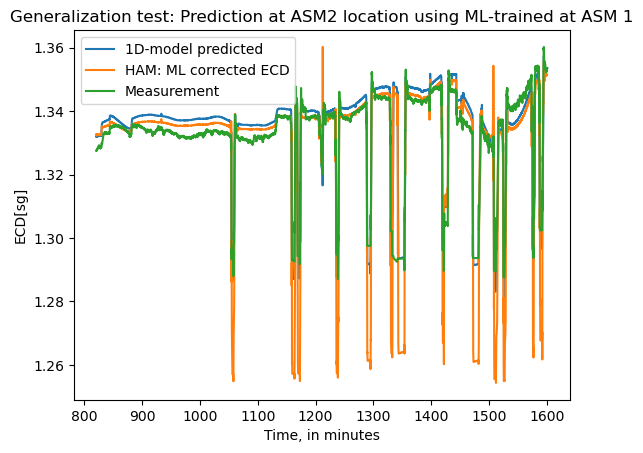

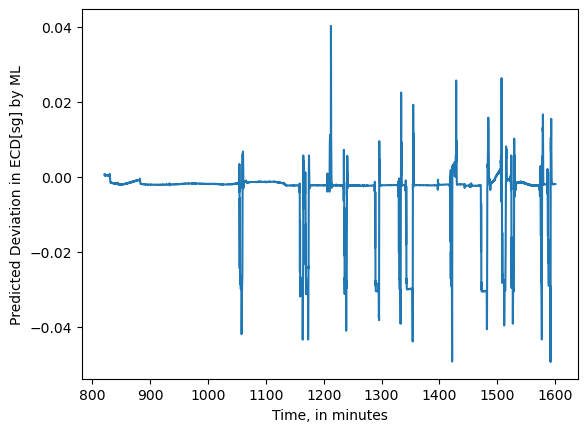

In [66]:
# ASM 2: TEST HAM FOR DIFFERENT ASM LOCATION THAN THE ASM LOCATION WHERE THE MODEL IS TRAINED.
model_name='Case102_NonRolling_LSTMDrilling.h5'
model3_Case102_nonrolling=load_model(os.path.abspath(dirFile+'/'+model_name))
training_features_measurement_fortran_short=df_select_fortran_drop1_short['ecdAtPos2'] 

norm_train_features_asm2=normalizer_fit.transform(df_select_fortran_drop1_short['ecdAtPos2'].values.reshape(-1,1))
print(norm_train_features_asm2.min())
print(norm_train_features_asm2.max())

lookback=3
xtrain_asm2=testing_lstm_4drilling_nonrolling(norm_train_features_asm2,lookback)
# xtrain_asm2,ycorrect_asm2,xtrain_we_asm2=testing_lstm_4drilling_asm2(pd.DataFrame(norm_train_features_asm2),lookback,model3_Case102_nonrolling)
print(xtrain_asm2.shape)
#print(ycorrect_asm2.shape)

ASM2_xtrain_ECD_simulation=normalizer_fit.inverse_transform(xtrain_asm2[:,-1,:])
corrected_xtrain_asm2=normalizer_fit.inverse_transform(xtrain_asm2[:,-1,:])[:,0]+model3_Case102_nonrolling.predict(xtrain_asm2)[:,0]

measurement_asm2=df_select_fortran_drop1_short['ASMECD2-T'].iloc[2:,]
print('measurement_asm2',measurement_asm2.shape)

time_asm2=df_select_fortran_drop1_short['minutes'].iloc[2:,]

plt.plot(time_asm2,ASM2_xtrain_ECD_simulation,label='1D-model predicted')
plt.plot(time_asm2,corrected_xtrain_asm2,label='HAM: ML corrected ECD')
plt.plot(time_asm2,measurement_asm2,label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('ECD[sg]')
plt.title('Generalization test: Prediction at ASM2 location using ML-trained at ASM 1')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'Generalize_test_ASM2_ECD_NonRolling_Case102.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Generalize_test_ASM2_ECD_NonRolling_Case102.pdf'))

plt.figure()
plt.plot(time_asm2,model3_Case102_nonrolling.predict(xtrain_asm2))
plt.xlabel('Time, in minutes')
plt.ylabel('Predicted Deviation in ECD[sg] by ML')
plt.savefig(os.path.abspath(dirFile+'/'+'Generalize_test_ASM2_ERROR_NonRolling_Case102.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Generalize_test_ASM2_ERROR_NonRolling_Case102.pdf'))



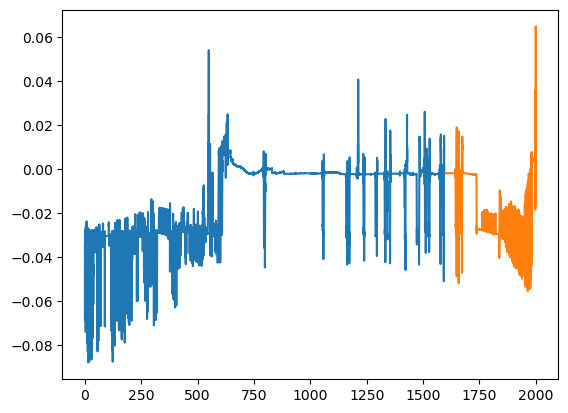

In [45]:
plt.plot(time_xaxis_in_minutes_train,model3.predict(xtrain))
plt.plot(time_xaxis_in_minutes_TEST,model3.predict(xtest))

In [29]:
#ECD
results_z[5,:,:] 

array([[1.2871457 , 1.28743709, 1.28769635, ...,        nan,        nan,
               nan],
       [1.28714574, 1.28743712, 1.28769639, ...,        nan,        nan,
               nan],
       [1.28915928, 1.28937781, 1.28962847, ...,        nan,        nan,
               nan],
       ...,
       [1.33430362, 1.33321093, 1.33202188, ..., 1.2715    , 1.2715    ,
        1.2715    ],
       [1.33413696, 1.33304426, 1.33185521, ..., 1.27125   , 1.27125   ,
        1.27125   ],
       [1.33427029, 1.33317759, 1.33202066, ..., 1.27116667, 1.27116667,
        1.27116667]])

In [33]:
ECD_Correction_z=np.zeros((1,results_z.shape[1],results_z.shape[2]))
HAM_ECD_Prediction_z=np.zeros((1,results_z.shape[1],results_z.shape[2]))
ECD_Correction_z.shape

(1, 11999, 356)

In [67]:
np.argwhere(np.isnan(results_z[5,:,:]))[0]

array([  0, 332], dtype=int64)

#### How it treats the NAN values. 
norm_train_features1=normalizer_fit.transform(results_z[5,:,:][0,330:333].reshape(-1,1))
xtrain_j=testing_lstm_4drilling_nonrolling(norm_train_features1,lookback)
#xtrain_j
ycorrect_j=model3_Case102_nonrolling.predict(xtrain_j)
print('a',3.0+ycorrect_j)
print(ycorrect_j)

for j in range(results_z.shape[2])[:1]: # Loop through depth
    #results_z[5,:,j]  #ECD value at all times at depth location j
    #Next scale the ECD value  at all times
    print('depth index',j)
    #print('time shape for results_z[5,:,j].shape) 
    norm_train_features1=normalizer_fit.transform(results_z[5,:,j].reshape(-1,1))
    #Arrange in LSTM format and use model.predict
    if (norm_train_features.min()<-1) or (norm_train_features.max()>1):
        count_scale_break=count_scale_break+1      
    
    xtrain_j=testing_lstm_4drilling_nonrolling(norm_train_features,lookback)     
    ycorrect_j=model3_Case102_nonrolling.predict(xtrain_j)

In [ ]:
model_name='Case102_NonRolling_LSTMDrilling.h5'
model3_Case102_nonrolling=load_model(os.path.abspath(dirFile+'/'+model_name))
count_scale_break=0

for j in range(results_z.shape[2]): # Loop through depth
    #results_z[5,:,j]  #ECD value at all times at depth location j
    #Next scale the ECD value  at all times
    print('depth index',j)
    #print('time shape for results_z[5,:,j].shape) 
    norm_train_features=normalizer_fit.transform(results_z[5,:,j].reshape(-1,1))
    #Arrange in LSTM format and use model.predict
    if (norm_train_features.min()<-1) or (norm_train_features.max()>1):
        count_scale_break=count_scale_break+1      
    
    xtrain_j=testing_lstm_4drilling_nonrolling(norm_train_features,lookback)     
    ycorrect_j=model3_Case102_nonrolling.predict(xtrain_j)
    print(ycorrect_j.reshape(-1).shape,xtrain_j[:,-1,:][:,0].shape)
    ECD_Correction_z[0,lookback-1:,j]=ycorrect_j.reshape(-1)
    
    HAM_ECD_Prediction_z[0,lookback-1:,j]=normalizer_fit.inverse_transform(xtrain_j[:,-1,:])[:,0]+ycorrect_j.reshape(-1)  #If you use -1, then you correct it. normalizer_fit_Case2B.inverse_transform(xtrain_we[1:,lookback-2,:].reshape(-1, 1))    #ycorrect+results_z[4,lookback-1:,depth_index]
    del xtrain_j
np.save(os.path.abspath(dirFile+'/'+'ECD_Correction_z_nonrolling.npy'),ECD_Correction_z)
np.save(os.path.abspath(dirFile+'/'+'HAM_ECD_Prediction_z_nonrolling.npy'),HAM_ECD_Prediction_z)
#np.save(os.path.abspath(dirFile+'/'+'ycorrect_resultsz.npy'),ycorrect_resultsz)
# Train the model over the whole time-step by using less validation 


# Non-Rolling : Visualization of Generalization of Results. 

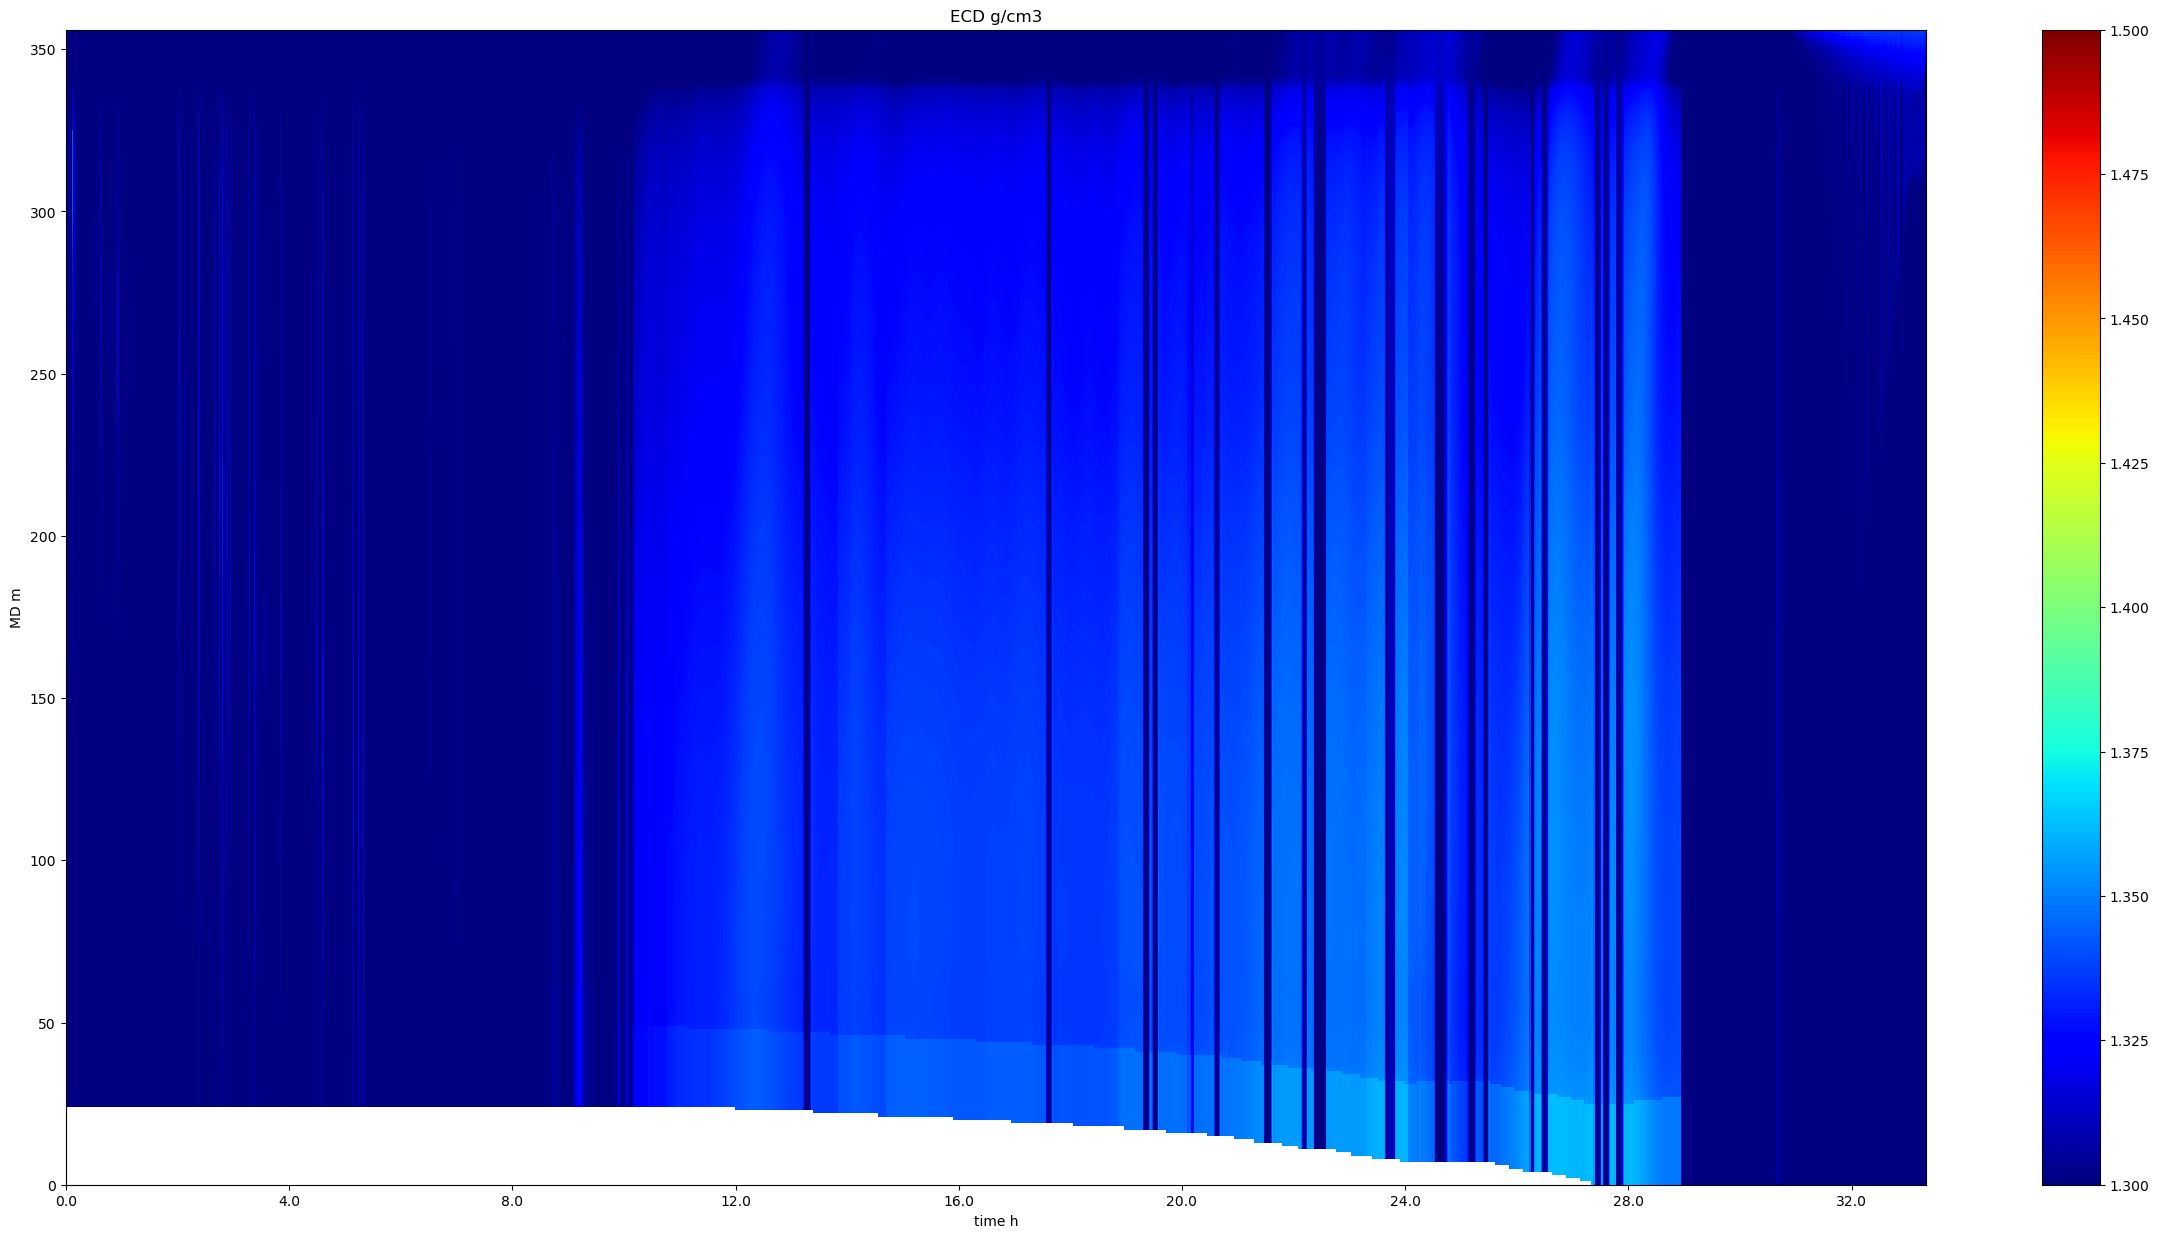

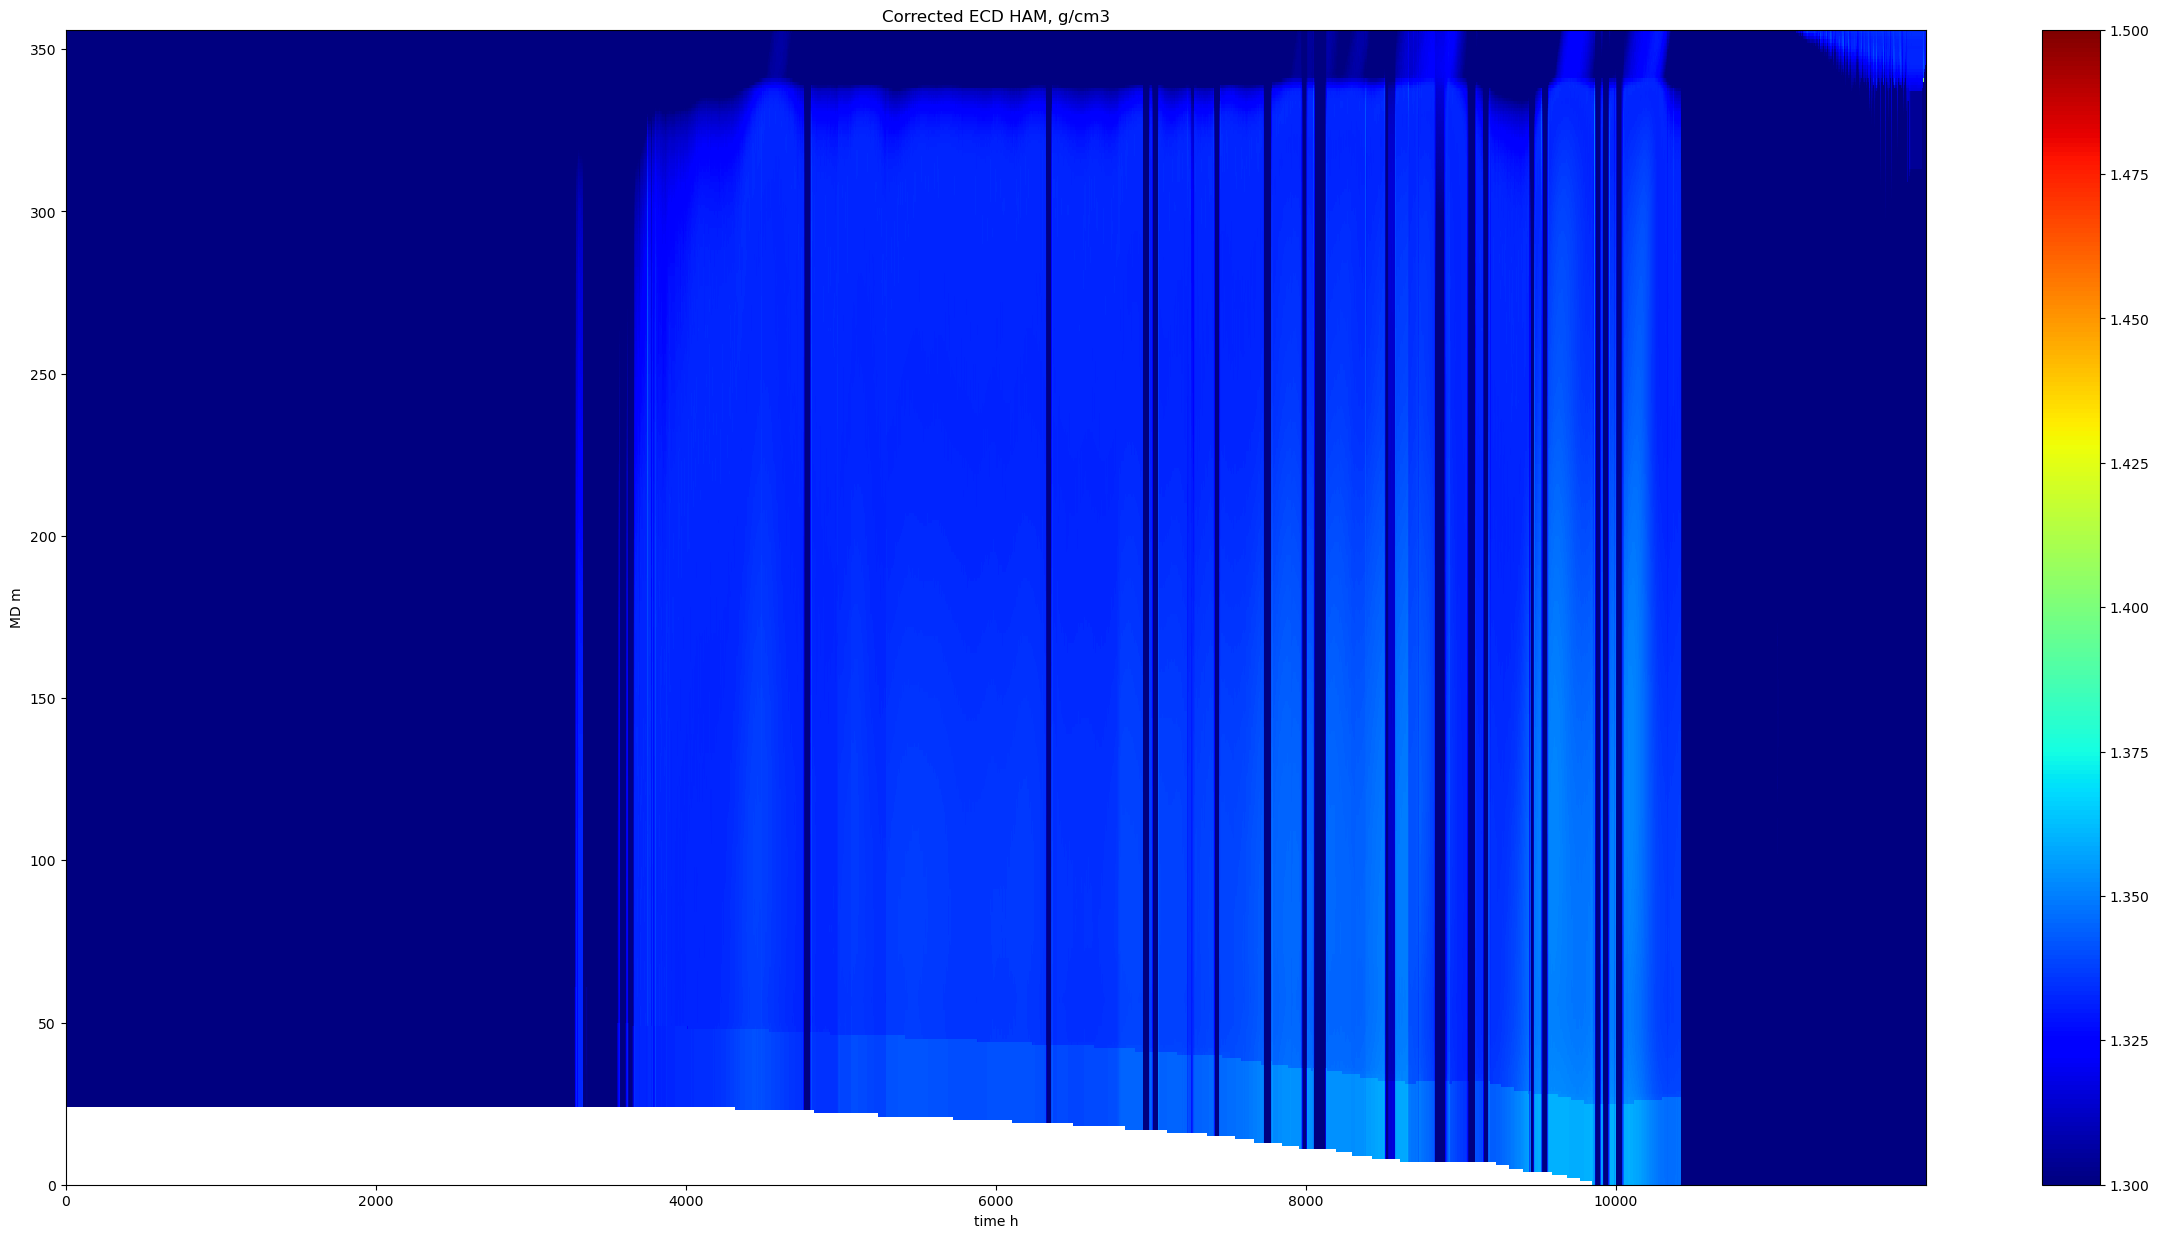

In [90]:
fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[5,:,::-1].T,cmap='jet',vmin = 1.3,vmax=1.5)
#ax.set_yticks(np.arange(6,357,10))
#ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('ECD g/cm3')
plt.colorbar(obj,ax=ax)

import numpy.ma as ma

fig,ax = plt.subplots(figsize=(30,15))
Zm = ma.masked_where(np.isnan(HAM_ECD_Prediction_z[0,:,::-1].T),HAM_ECD_Prediction_z[0,:,::-1].T)
obj =ax.pcolormesh(Zm,cmap='jet',vmin=1.3,vmax=1.5) #with transpose depth on row,time on column.
#obj =ax.pcolormesh(HAM_ECD_Prediction_z[0,:,::-1].T,cmap='jet',vmin=1.3,vmax=1.5) #with transpose depth on row,time on column.
#ax.set_yticks(np.arange(6,342,10))
# ax.set_yticklabels(np.arange(3300,-100,-100))
ax.set_ylabel('MD m')
#ax.set_xticks(np.arange(0,42468,1440))
#ax.set_xticklabels(np.arange(0,42468/360,4))
ax.set_xlabel('time h')
ax.set_title('Corrected ECD HAM, g/cm3')
plt.colorbar(obj,ax=ax) 
plt.savefig('Nonrolling_Generalization_102_Predicted_ECD_HAM.png')


In [ ]:
# (Non Rolling):Test generalization at different ASM location. ASM2.
# Obtain Error.
# Scale it
# Arrange it in 

In [91]:
np.isnan(HAM_ECD_Prediction_z[0,:,::-1].T)

array([[False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

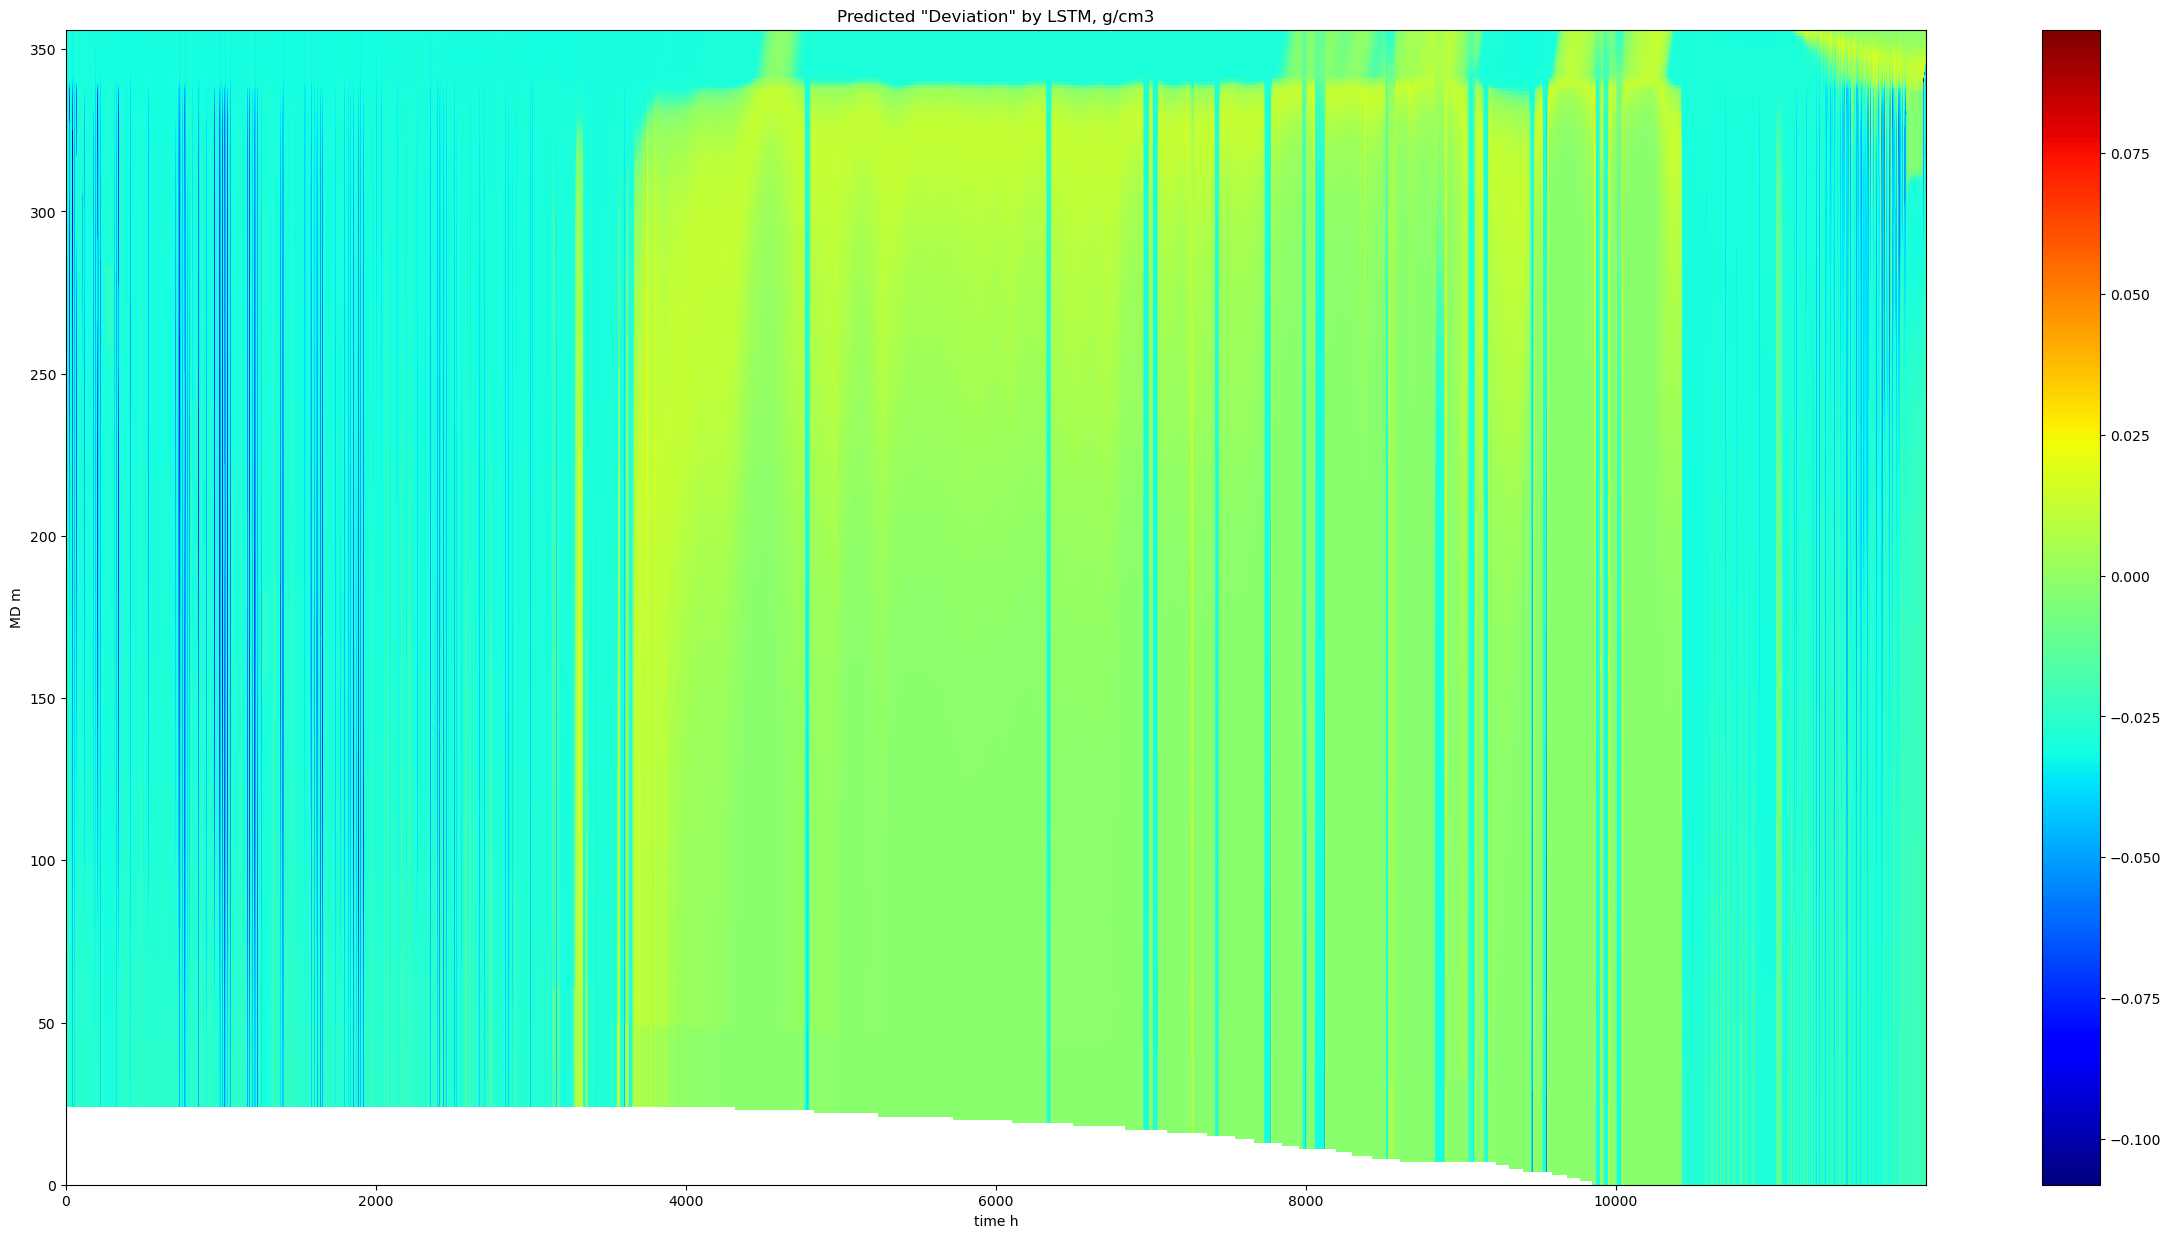

In [46]:
fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(ECD_Correction_z[0,:,::-1].T,cmap='jet')
#ax.set_yticks(np.arange(6,342,10))
# ax.set_yticklabels(np.arange(3300,-100,-100))
ax.set_ylabel('MD m')
#ax.set_xticks(np.arange(0,42468,1440))
#ax.set_xticklabels(np.arange(0,42468/360,4))
ax.set_xlabel('time h')
ax.set_title('Predicted "Deviation" by LSTM, g/cm3')
plt.colorbar(obj,ax=ax) 
plt.savefig('Nonrolling_Generalization_102_Predicted_Deviation.png')
 


# STOP NEXT SECTION 

# Rolling LSTM :  Train LSTM for Rolling LSTM. that is input is corrected. 

In [46]:
#xtrain_we=np.load('xtrain_we.npy')
#ytrain=np.load('ytrain.npy')
#xtrain=xtrain_we
Q=xtrain_we.shape[2] #check - what is Q? It is number of features. Should be 1 in this case.

lookback=3
epochs=150
batch_size=30
n_neurons=30 #trial.suggest_int('n_neurons',85,125, step=20)

%run LSTM/utility_LSTM-Drilling.ipynb
lstmtype=2
activation = "tanh" #trial.suggest_categorical("activation", ["relu", "tanh"])

dropout=0

Ngrid=False
if Ngrid:
    Ng=ncolumn
else:
    Ng=1
    
if lstmtype==2: 
    model3 = Sequential()
    model3.add(LSTM(n_neurons, input_shape=(lookback, Q), return_sequences=True, activation=activation)) # 
    model3.add(LSTM(n_neurons,  return_sequences=True, activation=activation,dropout=dropout)) # dropout=dropout 'tanh'
    #model3.add(LSTM(n_neurons,  activation='tanh',dropout=dropout)) #should give a vector with 60 elements.
    model3.add(LSTM(n_neurons,  activation=activation,dropout=dropout))
    model3.add(Dense(Ng,activation='linear')) #gives Q output values 
elif lstmtype==3: #Stateful LSTM (Avoid)
    #https://stackoverflow.com/questions/64309194/invalidargumenterror-specified-a-list-with-shape-60-9-from-a-tensor-with-shap
    model3 = Sequential() 
    bs=40
    model3.add(LSTM(n_neurons,batch_input_shape=(bs,lookback,Q+1), activation='tanh',stateful=True,return_sequences=True)) # return_sequences=True, 
    #model3.add(LSTM(n_neurons,return_sequences=True, activation='tanh',dropout=dropout,stateful=True)) # dropout=dropout
    model3.add(LSTM(n_neurons, activation='tanh',dropout=dropout,stateful=False)) #should give a vector with 60 elements.
    model3.add(Dense(Ng)) #gives Q output values
else: #SimpleLSTM
    model3 = Sequential()
    model3.add(LSTM(n_neurons, input_shape=(lookback, Q), return_sequences=False, activation='tanh')) # 
    #model3.add(LSTM(n_neurons, input_shape=(lookback, Q+1), return_sequences=True, activation='tanh',dropout=dropout)) # dropout=dropout
    #model3.add(LSTM(n_neurons, input_shape=(lookback, Q+1), activation='tanh',dropout=dropout)) #should give a vector with 60 elements.
    model3.add(Dense(Ng))

# compile model
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = keras.callbacks.ModelCheckpoint('best_model_rllinglstm_case2a1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=40, min_lr=0.0001)
callbacks=[es,mc,reduce_lr]

# Shuffling data
#perm = np.random.permutation(Training_xtrain_set.shape[0])
#xtrain = Training_xtrain_set[perm,:,:]
#ytrain = Training_ytrain_set[perm,:]
 #run the model


2.6.0
1.0.2


Epoch 1/150
288/288 [==============================] - 16s 19ms/step - loss: 1.4917e-04 - mse: 1.4917e-04 - val_loss: 8.9845e-05 - val_mse: 8.9845e-05

Epoch 00001: val_loss improved from inf to 0.00009, saving model to best_model_rllinglstm_case2a1.h5
Epoch 2/150
288/288 [==============================] - 4s 13ms/step - loss: 9.0733e-05 - mse: 9.0733e-05 - val_loss: 4.0156e-05 - val_mse: 4.0156e-05

Epoch 00002: val_loss improved from 0.00009 to 0.00004, saving model to best_model_rllinglstm_case2a1.h5
Epoch 3/150
288/288 [==============================] - 3s 12ms/step - loss: 5.7813e-05 - mse: 5.7813e-05 - val_loss: 2.5235e-05 - val_mse: 2.5235e-05

Epoch 00003: val_loss improved from 0.00004 to 0.00003, saving model to best_model_rllinglstm_case2a1.h5
Epoch 4/150
288/288 [==============================] - 3s 11ms/step - loss: 4.2718e-05 - mse: 4.2718e-05 - val_loss: 2.4924e-05 - val_mse: 2.4924e-05

Epoch 00004: val_loss improved from 0.00003 to 0.00002, saving model to best_model_r

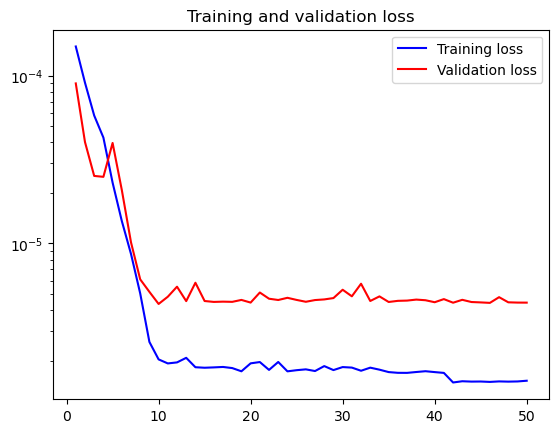

xtrain shape for fit (9592, 3, 1)
ytrain shape for fit (9592, 1)
mse: 0.00%


In [47]:
#Rolling : Check for xtrain_we and xtest_we. That is for Rolling.
# Shuffling data
#perm = np.random.permutation(Training_xtrain_set.shape[0])
#xtrain = Training_xtrain_set[perm,:,:]
#ytrain = Training_ytrain_set[perm,:]

#Run the model
history = model3.fit(xtrain_we,ytrain, epochs=epochs, batch_size=batch_size, validation_split=0.1,\
                     callbacks=[es,mc,reduce_lr])

#Evaluate the model 
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure()
epochs = range(1, len(loss) + 1)
plt.semilogy(epochs, loss, 'b', label='Training loss')
plt.semilogy(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
filename = 'Case102_Rolling_loss_lstm.png'
plt.savefig(os.path.abspath(dirFile+'/'+filename), dpi = 200)
plt.show()

# Save the model=
model_name='Case102_Rolling_LSTM_error.h5'
model3.save(os.path.abspath(dirFile+'/'+model_name))

# Save the scales
#filename = 'LSTM Models/NIROM_input_scaler_drilling1.save'
#joblib.dump(scalerIn3,filename) 
#filename = 'LSTM Models/NIROM_output_scaler_drilling1.save'
#joblib.dump(scalerOut3,filename) 
#print ("VALIDATION LOSS", val_loss[-1])
print('xtrain shape for fit',xtrain_we.shape)
print('ytrain shape for fit',ytrain.shape)
scores = model3.evaluate(xtrain_we, ytrain, verbose=0)
print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

In [ ]:
#For testing - you need to use model.predict after every and add that
# Test it ahead of time at same location.
    # If physics changes then may not work. Continuouse learning. 
    
# Test it at different location. 

In [14]:
def testing_lstm_4drilling_drill2(training_set,lookback,model3,normalizer_fit_Case2B,results_z=None,depth_index=None):      
    #Input shape of training set and error training is 2D ns by Q
    print('training_shape',training_set.shape)
    m=training_set.shape[0]     
    Q=training_set.shape[1] 
    # training_set=training_set.to_numpy() not needed for ndarrat 
    print('Sample',m ,' Input Feature shape ',Q)     
               
    # Below: Obtain both predictions from model and create subsequent training data in Rolling LSTM format and Non-Rolling form.

    # Rolling format : Below it is "xtrain_we" dataset. It involves correcting the input using output error for the next time.
    
    # Non-Rolling involves not correcting the input. Using uncorrected input for the next sample.
    
    xtrain = np.zeros((m-lookback+1,lookback,Q))
    xtrain_we = np.zeros((m-lookback+1,lookback,Q))
    ycorrect = np.zeros((m-lookback+1))
       
    for i in range(m-lookback+1): #(m-lookback): #number of samples is "m-lookback + 1", and for each sample/time index i (row of xtrain). On range the loop starts from 0 and ends at m-lookback.
        if(i % 5 == 0): 
          print('sample',i)
        a = training_set[i,:Q] #if Q+1 then obtain variable values for features Q+1 for time index i (Q is grids, Q+1 for parameter value - time step here.)

        for j in range(1,lookback): # Obtain coefficients for time index i+j for look-back times foe each sample.
            #print(i,j)
            a = np.vstack((a,training_set[i+j,:Q])) # Add to row. concatenate in loop all feature Q values for different time steps,see the beautiful use of vstack to create for a given sample i, a 2D array of coefficients with lookback rows x Q mode columns 

        
        # xtrain[i,:,:] = a  # 
        xtrain_we[i,:,:]=a #i=0, 0,1,2 #i=1, 1,2,3. To add to the middle one.
        #print('XTRAIN_SHAPE',xtrain_we[i,:,:].shape)
        #print('XTRAIN_SHAPE',xtrain.shape)
        if i==0:
          laxtemp=xtrain_we[i,:,:]
          laxtemp=laxtemp[np.newaxis,:,:]
          ycorrect[i]=model3.predict(laxtemp)  #Error evaluated at sample i first
        
        if i>0:
              A3=normalizer_fit_Case2B.inverse_transform(xtrain_we[i,lookback-2,:].reshape(-1, 1))+ycorrect[i-1]
              #
              #print(A3,'A3shape')
              #A2=(()
              #print(A2.shape,'A2shape')
              A2=normalizer_fit_Case2B.transform(A3) #xtrain_we[i,lookback-2,:]+ycorrect[i-1] #correct the input at the next sample using previous i-1 error.
              #print(A2,'A1shape')
              xtrain_we[i,lookback-2,:]=  A2 #normalizer_fit_Case2B.transform((normalizer_fit_Case2B.inverse_transform(xtrain_we[i,lookback-2,:])+ycorrect[i-1]).reshape(-1,1)) #xtrain_we[i,lookback-2,:]+ycorrect[i-1] #correct the input at the next sample using previous i-1 error.
              ycorrect[i]=model3.predict(xtrain_we[i,:,:].reshape(1,lookback,Q)) 
              
        
    print('Ycorrect_SHAPE',ycorrect.shape)         
    #print('XTRAIN_SHAPE',xtrain.shape)   
    print('XTRAINWE_SHAPE',xtrain_we.shape)   
    #xtrain is 3D array: samples x lookback x feature Q (number of grids)
    #ytrain is 2D array: samples x features.
    #findshape=xtrain_we[1:,lookback-2,:]
    #print('findshape',findshape.shape)
    
    if results_z is not None:
            results_z[5,lookback-1:,depth_index]=ycorrect #zero indexing so it calls the lookbackth element.
            results_z[6,lookback-1:,depth_index]=normalizer_fit_Case2B.inverse_transform(xtrain_we[:,-1,:])[:,0]+ycorrect  #If you use -1, then you correct it. normalizer_fit_Case2B.inverse_transform(xtrain_we[1:,lookback-2,:].reshape(-1, 1))    #ycorrect+results_z[4,lookback-1:,depth_index]
            print('depth_index',depth_index)
    else: 
            results_z=[]
                 
    return ycorrect,xtrain_we,results_z  #,xtrain_3D,ytrain_1D #3D shape ns,lookback,1       



In [13]:
model_name='Case102_Rolling_LSTM_error.h5'
model3_Case102=load_model(os.path.abspath(dirFile+'/'+model_name))

xtrain,ycorrect,xtrain_we,results_z=testing_lstm_4drilling_drill2(norm_train_features_fortran_measurement, lookback,model3_Case102,normalizer_fit)

In [10]:
ycorrect_test,xtest_weA,results_zA=testing_lstm_4drilling_drill2(norm_test_features_fortran_measurement, lookback,model3_Case102,normalizer_fit)

training_shape (2399, 1)
Sample 2399  Input Feature shape  1
Ycorrect_SHAPE (2397,)
XTRAINWE_SHAPE (2397, 3, 1)


In [12]:
xtrain=np.load(os.path.abspath(dirFile+'/'+'xtrain_Case102.npy'))
xtrain_we=np.load(os.path.abspath(dirFile+'/'+'xtrain_WERolling_Case102.npy'))
ytrain=np.load(os.path.abspath(dirFile+'/'+'ytrain_Case102.npy')) 

In [20]:
normalizer_fit.inverse_transform(xtest_weA[:,-1,:])[:,0].shape

(2397,)

In [17]:
ycorrect_test.shape

(2397,)

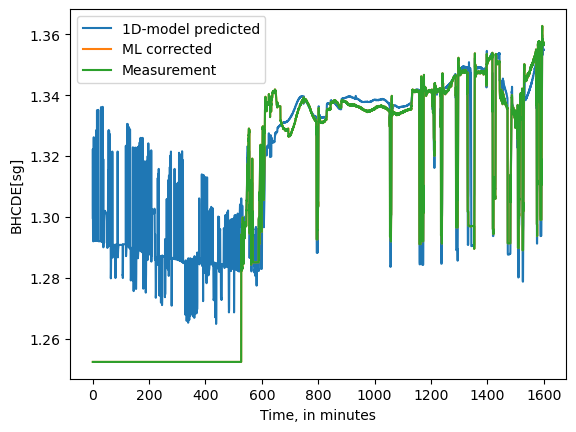

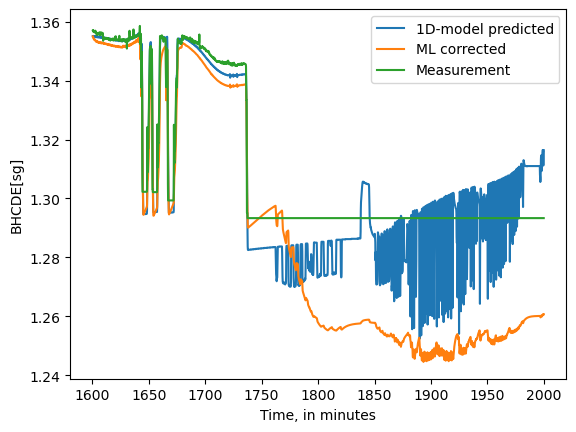

In [24]:
addcorrection_test=ycorrect_test #model3.predict(xtest_we)
 
corrected_xtest_we=normalizer_fit.inverse_transform(xtest_weA[:,-1,:])[:,0]+addcorrection_test #added only to last column
corrected_xtrain_we=normalizer_fit.inverse_transform(xtrain_we[1:,-2,:]) #normalizer_fit.inverse_transform(xtrain_we[:,-2,:])+ycorrect

train_measurement=train_dataset_measurement_fortran['ASMECD1-T'].iloc[3:,] #starts from 2 - because error is obained for 3 sample which is index=2.
test_measurement=test_dataset_measurement_fortran['ASMECD1-T'].iloc[2:,]

time_xaxis_in_minutes_train=train_dataset_measurement_fortran['minutes'].iloc[3:,]
time_xaxis_in_minutes_TEST=test_dataset_measurement_fortran['minutes'].iloc[2:,]

plt.figure()
plt.plot(time_xaxis_in_minutes_train,normalizer_fit.inverse_transform(xtrain_we[1:,-1,:]),label='1D-model predicted')
plt.plot(time_xaxis_in_minutes_train,corrected_xtrain_we,label='ML corrected')
plt.plot(time_xaxis_in_minutes_train,train_measurement,label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Rolling_LSTM_Corrected_BHECD_Traindata.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Rolling_LSTM_Corrected_BHECD_Traindata.pdf'))

plt.figure()
plt.plot(time_xaxis_in_minutes_TEST,normalizer_fit.inverse_transform(xtest_weA[:,-1,:]),label='1D-model predicted')
plt.plot(time_xaxis_in_minutes_TEST,corrected_xtest_we,label='ML corrected')
plt.plot(time_xaxis_in_minutes_TEST,test_measurement,label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_TEST_data.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Case102_Nonrolling_LSTM_Corrected_BHECD_TEST_data.pdf'))



In [ ]:
#Testing space-wise 
ycorrect_test,xtest_weA,results_zA=testing_lstm_4drilling_drill2(norm_test_features_fortran_measurement, lookback,model3_Case102,normalizer_fit) 

In [9]:
results_z.shape

(14, 11999, 356)

In [16]:
# Predict ECD at all time steps and depths using ROLLING LSTM model
# Scale it and arrange the data in the LSTM format by 1130.
count_scale_break=0
lookback=3
for j in range(results_z.shape[2])[:100]: # Loop through depth
    #results_z[4,:,j]  #ECD value at all times at depth location j
    #Next scale the ECD value  at all times
    print(j)
    norm_train_features=normalizer_fit.transform(results_z[4,:,j].reshape(-1,1))
    #Arrange in LSTM format and use model.predict
    if (norm_train_features.min()<-1) or (norm_train_features.max()>1):
        count_scale_break=count_scale_break+1
    
    
    ycorrect_resultsz,xtest_resultsz,results_z=testing_lstm_4drilling_drill2(norm_train_features,lookback,model3_Case102,normalizer_fit,results_z,j)
np.save(os.path.abspath(dirFile+'/'+'results_z_modified.npy'),results_z)
np.save(os.path.abspath(dirFile+'/'+'xtest_resultsz.npy'),xtest_resultsz)
np.save(os.path.abspath(dirFile+'/'+'ycorrect_resultsz.npy'),ycorrect_resultsz)

training_shape (11999, 1)
Sample 11999  Input Feature shape  1
sample 0
sample 5
sample 10
sample 15
sample 20
sample 25
sample 30
sample 35
sample 40
sample 45
sample 50
sample 55
sample 60
sample 65
sample 70
sample 75
sample 80
sample 85
sample 90
sample 95
sample 100
sample 105
sample 110
sample 115
sample 120
sample 125
sample 130
sample 135
sample 140
sample 145
sample 150
sample 155
sample 160
sample 165
sample 170
sample 175
sample 180
sample 185
sample 190
sample 195
sample 200
sample 205
sample 210
sample 215
sample 220
sample 225
sample 230
sample 235


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[5,:,::-1].T,cmap='jet')
#ax.set_yticks(np.arange(6,342,10))
# ax.set_yticklabels(np.arange(3300,-100,-100))
ax.set_ylabel('MD m')
#ax.set_xticks(np.arange(0,42468,1440))
#ax.set_xticklabels(np.arange(0,42468/360,4))
ax.set_xlabel('time h')
ax.set_title('Predicted "Deviation" by LSTM, g/cm3')
plt.colorbar(obj,ax=ax) 
plt.savefig('Predicted_Deviation.png')
 

In [ ]:
fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[6,:,::-1].T,cmap='jet',vmin=1.35)
#ax.set_yticks(np.arange(6,342,10))
# ax.set_yticklabels(np.arange(3300,-100,-100))
ax.set_ylabel('MD m')
#ax.set_xticks(np.arange(0,42468,1440))
#ax.set_xticklabels(np.arange(0,42468/360,4))
ax.set_xlabel('time h')
ax.set_title('Corrected ECD HAM, g/cm3')
plt.colorbar(obj,ax=ax) 
plt.savefig('Predicted_ECD_HAM.png')

# STOP HERE - TESTS COMPLETED BELOW ARE JUST PLOTS

history = model3.fit(xtrain_we,ytrain, epochs=epochs, batch_size=batch_size, validation_split=0.1,\
                     callbacks=[es,mc,reduce_lr])

# evaluate the model


loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure()
epochs = range(1, len(loss) + 1)
plt.semilogy(epochs, loss, 'b', label='Training loss')
plt.semilogy(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
filename = 'Case2A1_Rollingloss_fortran_measurement_error.png'
plt.savefig(os.path.abspath(dirFile+'/'+filename, dpi = 200))
plt.show()

# Save the model=
model_name='Case2A1_RollingLSTMDrilling_fortran_measurement_error.h5'
model3.save(os.path.abspath(dirFile+'/'+model_name))

# Save the scales
#filename = 'LSTM Models/NIROM_input_scaler_drilling1.save'
#joblib.dump(scalerIn3,filename) 
#filename = 'LSTM Models/NIROM_output_scaler_drilling1.save'
#joblib.dump(scalerOut3,filename) 
#print ("VALIDATION LOSS", val_loss[-1])
print('xtrain shape for fit',xtrain_we.shape)
print('ytrain shape for fit',ytrain.shape)
scores = model3.evaluate(xtrain_we, ytrain, verbose=0)
print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))


train_dataset_measurement_fortran.columns = ['minutes', 'minutes1', 'ECD_bot', 'ASMECD1_T', 'DEP', 'Error']
test_dataset_measurement_fortran.columns = ['minutes', 'minutes1', 'ECD_bot', 'ASMECD1_T', 'DEP', 'Error']

#filename_4_scalingfunction = 'Case2A1_LSTM_Case2B1_Full_Measurement_Fortran_scalingfunction.save'
#normalizer_fit=joblib.load(filename_4_scalingfunction) 
#filename_4_scalingfunction = 'AD_Rolling_LSTM_Case2B1_Full_Measurement_Fortran_scalingfunction.save'
#normalizer_fit=joblib.load(filename_4_scalingfunction) 



corrected_xtrain_we=normalizer_fit_fortran_measurement.inverse_transform(xtrain_we[1:,-1,:])+model3.predict(xtrain_we[1:,:]) #CORRECT THIS.predict computes the correction.
corrected_xtest_we=normalizer_fit_fortran_measurement.inverse_transform(xtest_we[:,-1,:])+model3.predict(xtest_we) #CORRECT THIS.
measurement=test_dataset_measurement_fortran_withmeasurement_Case2A['ASMECD1_T'].iloc[:-1,]

plt.plot(train_dataset_measurement_fortran_Case2A['minutes'].iloc[2:-1,],normalizer_fit_fortran_measurement.inverse_transform(xtrain_we[1:,-1,:]),label='1D-model predicted')
plt.plot(train_dataset_measurement_fortran_Case2A['minutes'].iloc[2:-1,],corrected_xtrain_we,label='ML corrected')
plt.plot(train_dataset_measurement_fortran_withmeasurement_Case2A['minutes'].iloc[2:-1,],train_dataset_measurement_fortran_withmeasurement_Case2A['ASMECD1_T'].iloc[2:-1,],label='Measurement')
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()

plt.savefig(os.path.abspath(dirFile+'/'+'Rolling_LSTM_Case2B_Corrected_BHECD_traindata.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'Rolling_LSTM_Case2B_Corrected_BHECD_traindata.pdf'))

plt.figure()
plt.plot(test_dataset_measurement_fortran_Case2A['minutes'].iloc[1:-1,],normalizer_fit_fortran_measurement.inverse_transform(xtest_we[:,-1,:]),label='1D-model predicted')#'b--',
plt.plot(test_dataset_measurement_fortran_Case2A['minutes'].iloc[1:-1,],corrected_xtest_we,label='ML corrected') #'o--',
plt.plot(test_dataset_measurement_fortran_withmeasurement_Case2A['minutes'].iloc[:-1,],measurement,label='Measurement') #'g--',
plt.xlabel('Time, in minutes')
plt.ylabel('BHCDE[sg]')
plt.legend()
plt.savefig(os.path.abspath(dirFile+'/'+'RollingLSTM_Case2A_Corrected_BHECD_TEST_datainfuture.png'))
plt.savefig(os.path.abspath(dirFile+'/'+'RollingLSTM_Case2A_Corrected_BHECD_TEST_datainfuture.pdf'))



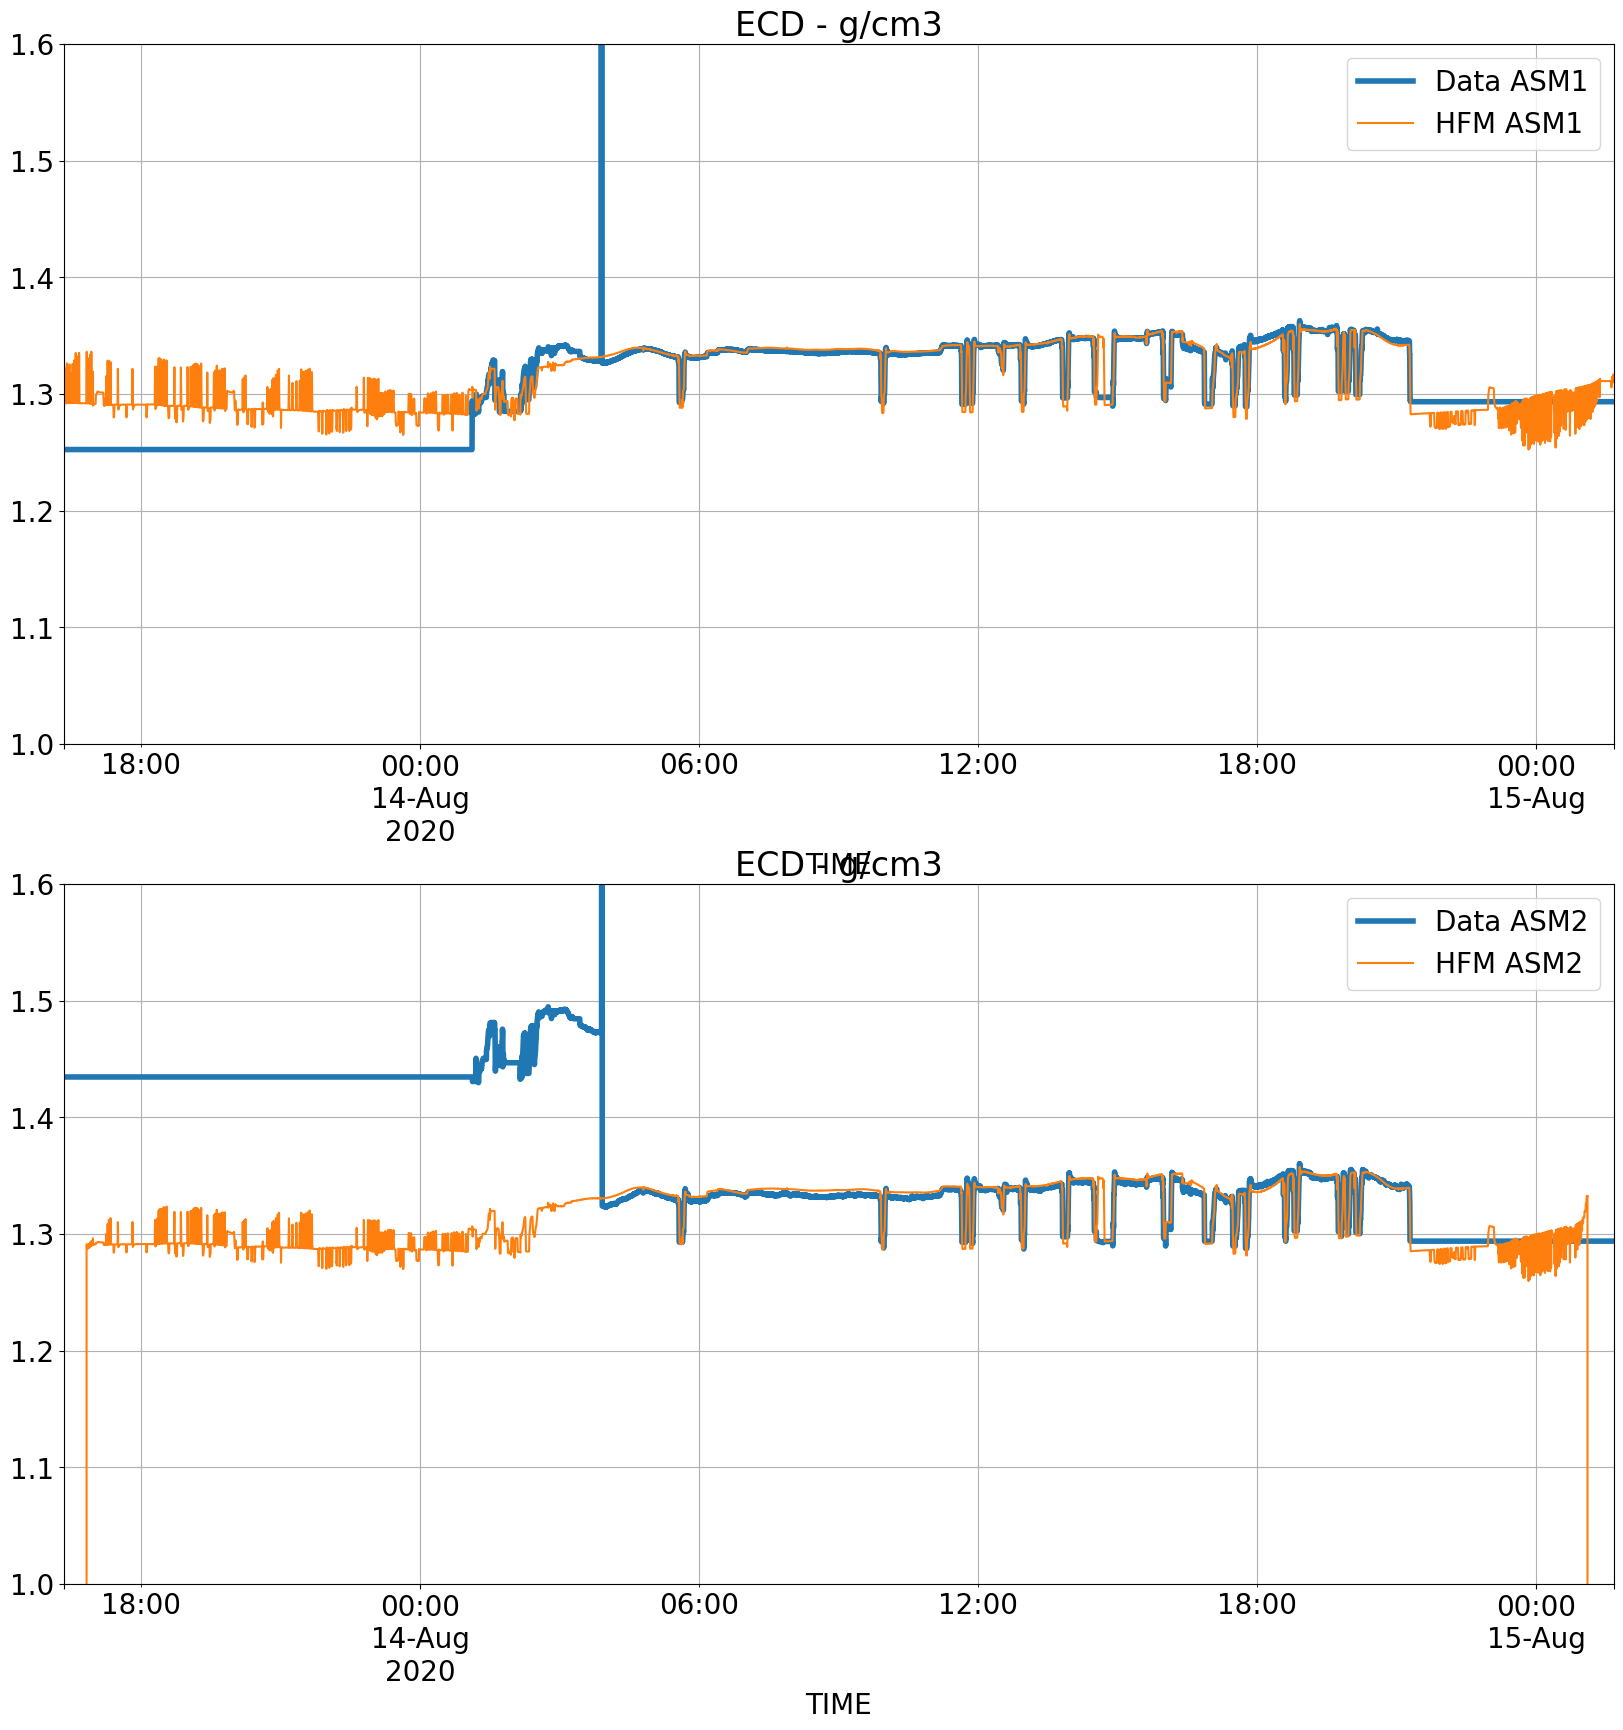

In [23]:
#Plot ECD

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,20))
plt.rcParams.update({'font.size': 20})

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].DHT001_ECD.values,label='Data ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMECD2_T.values,label='Data ASM2')
#ax[0].plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ECD1_ASM_recalc.values,label='Data ASM1b',linewidth=4)
data_df.plot(y='ASMECD1-T',ax=ax[0],label='Data ASM1',linewidth=4)
data_df.plot(y='ASMECD2-T',ax=ax[1],label='Data ASM2',linewidth=4)


#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMECD3_T.values,label='Data ASM3')
#ax[0].plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:model_t_obs_df_reinterp.shape[0]+1][:],model_t_obs_df_reinterp.ecdAtPos1.values[:],label='HFM ASM1')
model_t_obs_df_reinterp.iloc[:].plot(y='ecdAtPos1',ax=ax[0],label='HFM ASM1')
model_t_obs_df_reinterp.plot(y='ecdAtPos2',ax=ax[1],label='HFM ASM2')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values[1:model_t_obs_df_reinterp.shape[0]+1],model_t_obs_df_reinterp.ecdAtPos3.values[:],label='HFM ASM2')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

for i in range(2):
    ax[i].legend()
    ax[i].set_title('ECD - g/cm3')
    ax[i].grid(which='both')
    ax[i].set_ylim([1.,1.6])

In [ ]:
# Testing with dataset from results_z . Use TestGeneralize_2

In [155]:
data_df.columns

Index(['ASMATN1_T', 'ASMDEP1_T', 'ASMDEP2_T', 'ASMDEP3_T', 'ASMECD1_T',
       'ASMECD2_T', 'ASMMALM1_T', 'ASMPAM1_T', 'ASMPAM2_T', 'ASMPAM3_T',
       'ASMPIM1_T', 'ASMRGM1_T', 'ASMTVD1_T', 'ASMTVD2_T', 'ASMTVD3_T',
       'ASMAAM1_T', 'ASMAAZM1_T', 'BDTV', 'BPOS', 'BSZ', 'CSTK', 'CTDA',
       'CTDI', 'DEP', 'DHT001_DEPTH', 'DHT001_ECD', 'DHT001_EMW', 'DHT001_ESD',
       'DHT001_NOV_TVD', 'DHT001_PRESS_ANN_MEAN', 'DHT001_PRESS_INT_MEAN',
       'DHT001_ROT_GYRO_MEAN', 'DHT001_TEMP_PCB_MEAN__DOWNHOLE_TIME',
       'DHT001_TEMP_PCB_MEAN__ASM_TIME', 'DMIAVG', 'DMOAVG', 'FLIAVG',
       'FLOAVG', 'GDSS_T', 'GDTVSS_T', 'GHCAVG', 'GHCMAX', 'HDEP', 'HDTV',
       'HKLDAV', 'IBARDENS', 'IBARDENST', 'IBARRHEOT', 'IBARVIS100',
       'IBARVIS200', 'IBARVIS3', 'IBARVIS300', 'IBARVIS6', 'IBARVIS600',
       'ISLS', 'LAGDEP', 'LAGTIM', 'PIP_T', 'PITC', 'PITT', 'PWEA_T', 'PWPA_T',
       'PWTA_T', 'RISFLO', 'ROPA', 'ROPI', 'RPMBAVG', 'RPMSAVG', 'RPOS',
       'RSPD', 'RT_DEPTH_RETURNS_T', 'SPPAVG

(1.25, 1.45)

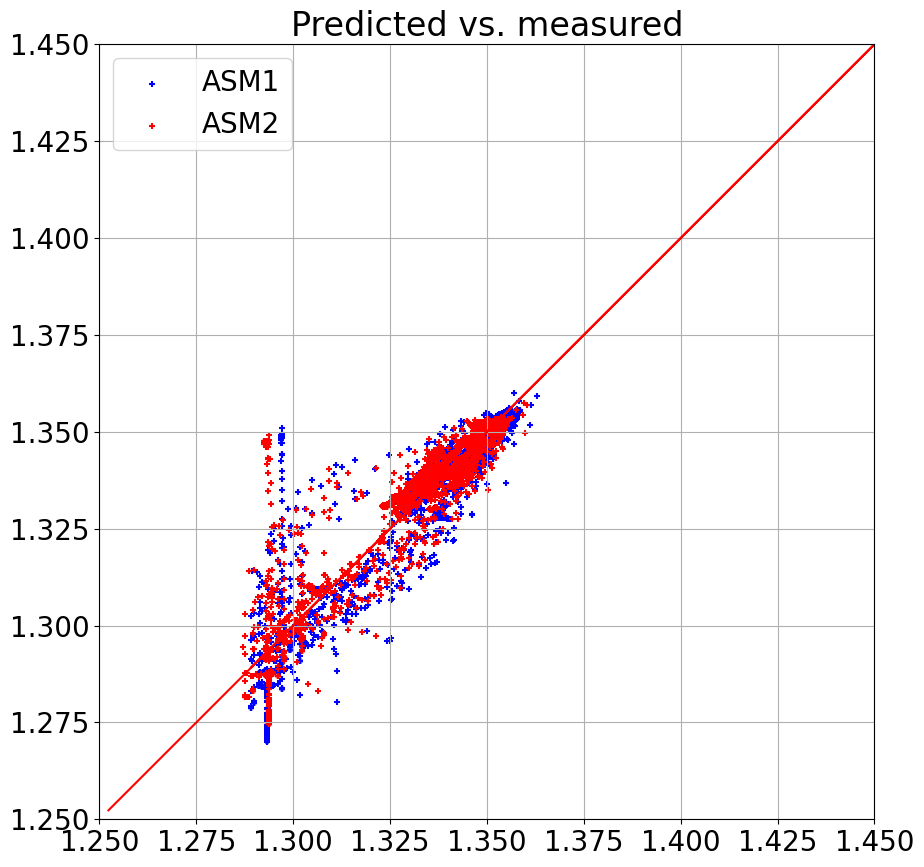

In [151]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

sel14 = model_t_df_reinterp.mdBit.values >= 3321
obj=plt.scatter(data_df['ASMECD1-T'].iloc[1:][sel14],model_t_obs_df_reinterp.ecdAtPos1.values[sel14],20,marker='+',c='b',label='ASM1')
obj2=plt.scatter(data_df['ASMECD2-T'].iloc[1:][sel14],model_t_obs_df_reinterp.ecdAtPos2.values[sel14],20,marker='+',c='r',label='ASM2')
plt.plot(data_df['ASMECD1-T'].iloc[:-61],data_df['ASMECD1-T'].iloc[:-61],c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('ECD Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([1.25,1.45])
ax.set_ylim([1.25,1.45])


NameError: name 'data_df' is not defined

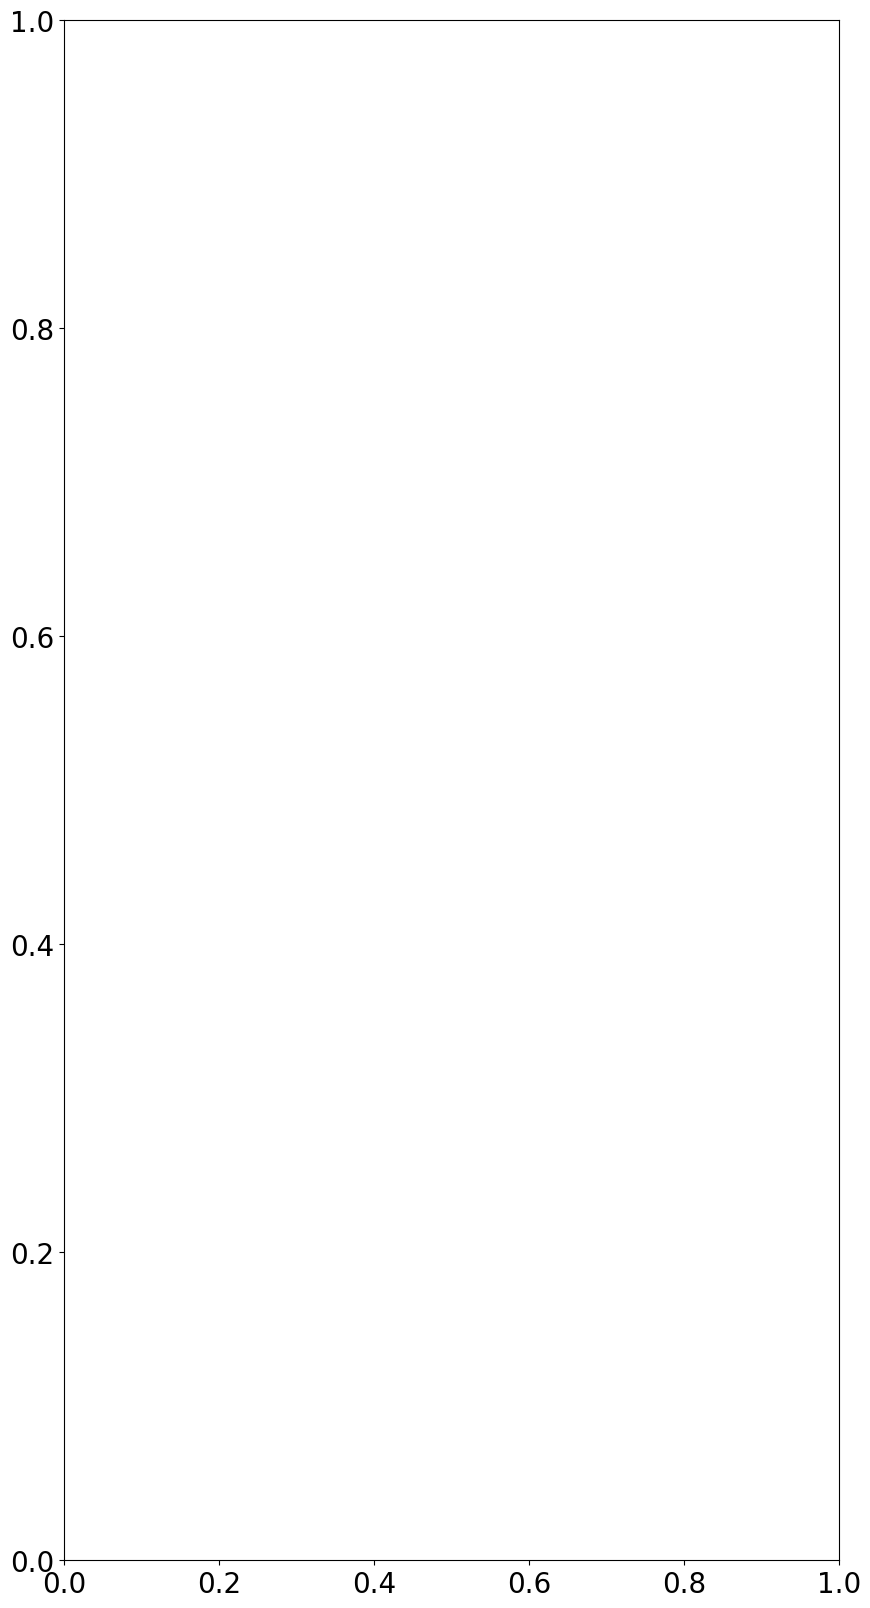

In [9]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

sel14 = model_t_df_reinterp.mdBit.values <= 3402
obj=plt.scatter(data_df['ASMECD1-T'].iloc[1:][sel14],model_t_obs_df_reinterp.ecdAtPos1.values[sel14],20,marker='+',c='b',label='ASM1')
obj2=plt.scatter(data_df['ASMECD2-T'].iloc[1:][sel14],model_t_obs_df_reinterp.ecdAtPos2.values[sel14],20,marker='+',c='r',label='ASM2')
plt.plot(data_df['ASMECD1-T'].iloc[:-61],data_df['ASMECD1-T'].iloc[:-61],c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('ECD Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([1.25,1.45])
ax.set_ylim([1.25,1.45])


#### 9- Pressure at ASM

(0.0, 350.0)

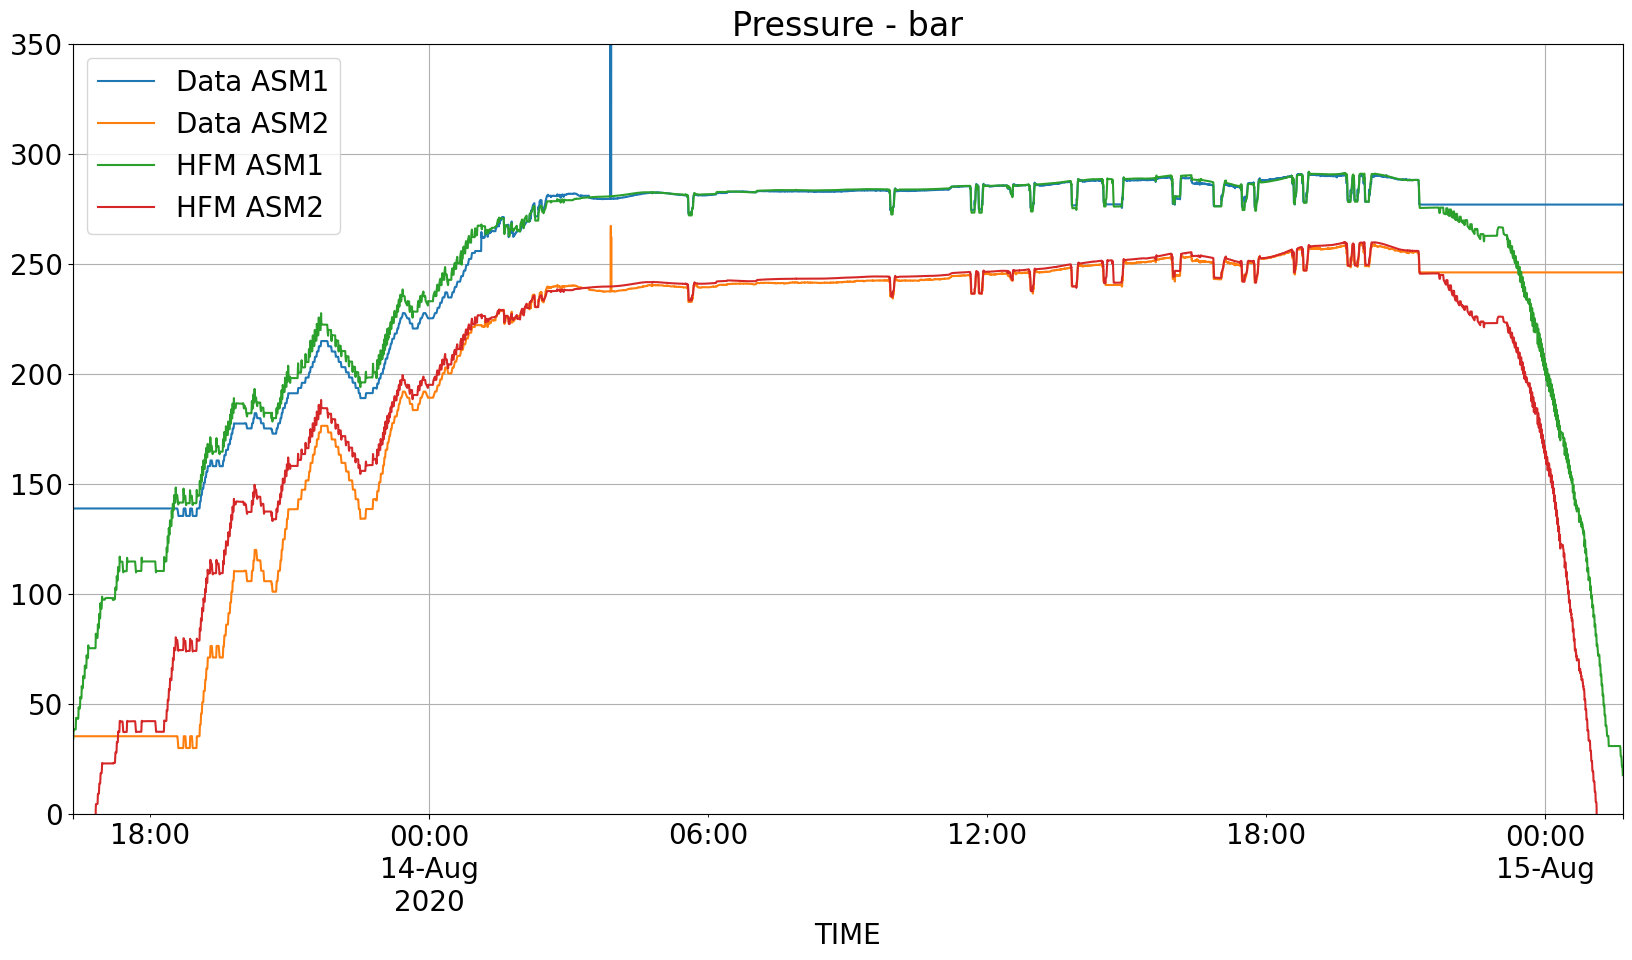

In [153]:
fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

data_df.plot(y='PRES1_ASM_recalc',ax=ax,label='Data ASM1')
data_df.plot(y='PRES2_ASM_recalc',ax=ax,label='Data ASM2')
model_t_obs_df_reinterp.plot(y='pAtPos1',ax=ax,label='HFM ASM1')
model_t_obs_df_reinterp.plot(y='pAtPos2',ax=ax,label='HFM ASM2')
ax.legend()
ax.set_title('Pressure - bar')
ax.grid()
ax.set_ylim([0,350])

(0.0, 350.0)

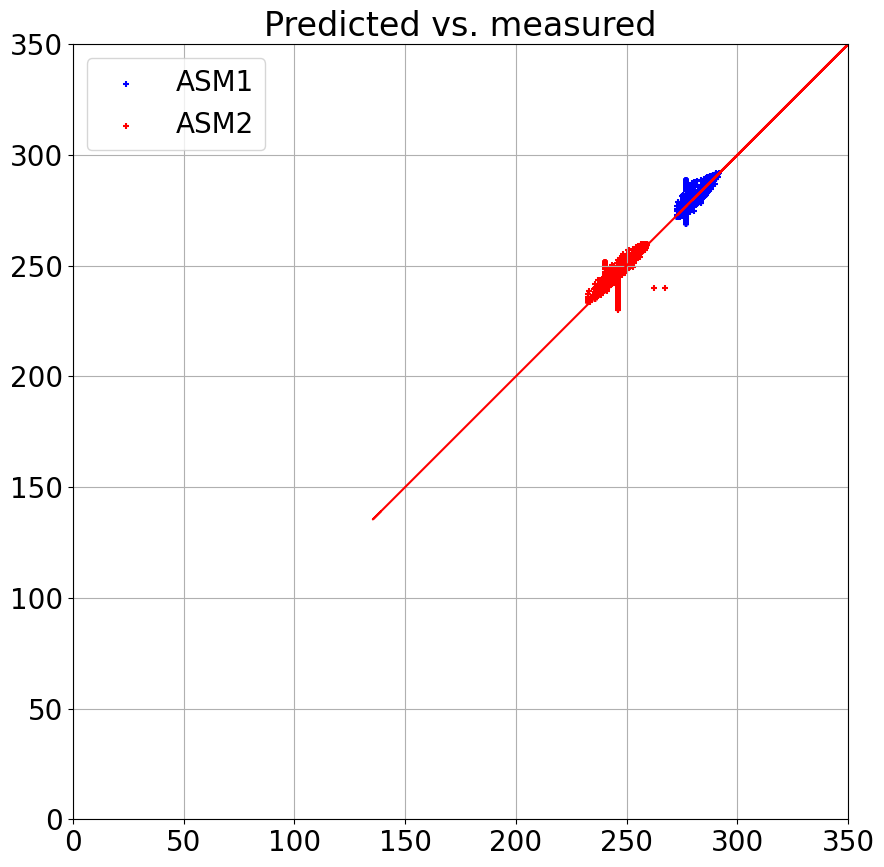

In [154]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

sel9_5 = model_t_df_reinterp.mdBit.values >= 3321

obj=plt.scatter(data_df['PRES1_ASM_recalc'].iloc[1:][sel14],model_t_obs_df_reinterp.pAtPos1.values[sel14],20,marker='+',c='b',label='ASM1')
obj2=plt.scatter(data_df['PRES2_ASM_recalc'].iloc[1:][sel14],model_t_obs_df_reinterp.pAtPos2.values[sel14],20,marker='+',c='r',label='ASM2')
plt.plot(data_df['PRES1_ASM_recalc'].iloc[:-61],data_df['PRES1_ASM_recalc'].iloc[:-61],c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('Pressure - bar Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([0,350])
ax.set_ylim([0,350])
#fig.colorbar(obj,shrink=0.5)

(0.0, 350.0)

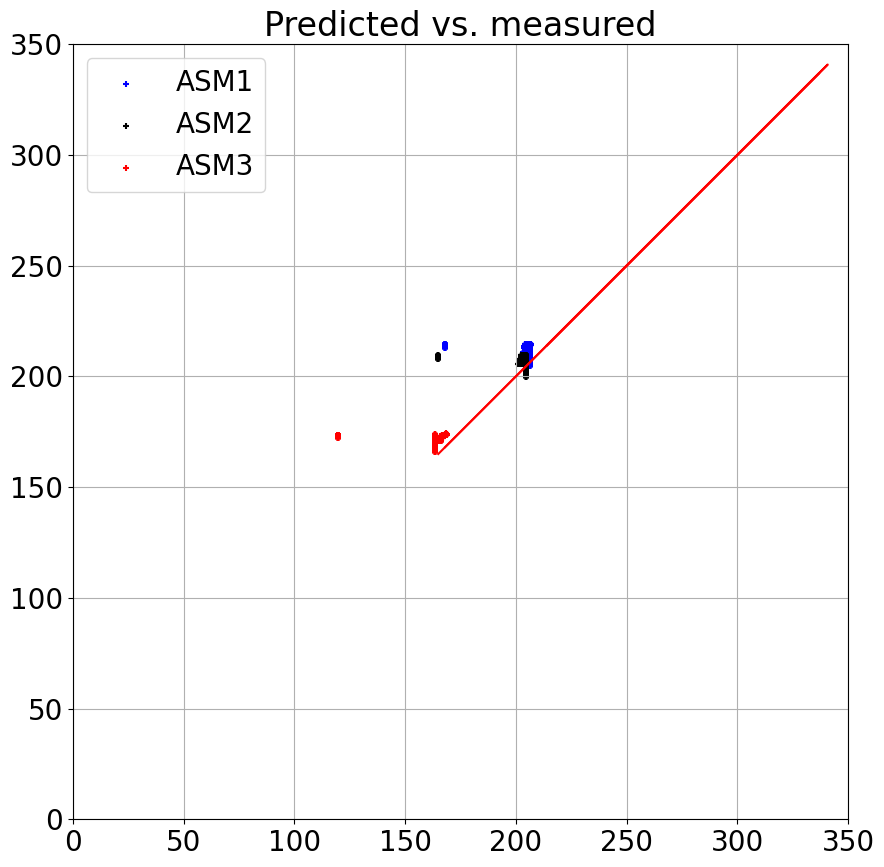

In [144]:
fig,ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 20})

sel16 = model_t_df_reinterp.mdBit.values < 3404
obj2=plt.scatter(data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values[1:model_t_obs_df_reinterp.shape[0]+1][sel16],model_t_obs_df_reinterp.pAtPos1.values[sel16],20,marker='+',c='b',label='ASM1')
obj=plt.scatter(data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values[1:model_t_obs_df_reinterp.shape[0]+1][sel16],model_t_obs_df_reinterp.pAtPos2.values[sel16],20,marker='+',c='k',label='ASM2')
obj=plt.scatter(data_df.loc[tstamp_min:tstamp_max:10].ASMPAM3_T.values[1:model_t_obs_df_reinterp.shape[0]+1][sel16],model_t_obs_df_reinterp.pAtPos3.values[sel16],20,marker='+',c='r',label='ASM3')
plt.plot(data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values[1:model_t_obs_df_reinterp.shape[0]+1],data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values[1:model_t_obs_df_reinterp.shape[0]+1],c='r')
plt.plot(data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values[1:model_t_obs_df_reinterp.shape[0]+1],data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values[1:model_t_obs_df_reinterp.shape[0]+1],c='r')

#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM1_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD1_T.values,label='Data ASM1 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,data_df.loc[tstamp_min:tstamp_max:10].ASMPAM2_T.values/.0981/data_df.loc[tstamp_min:tstamp_max:10].ASMTVD2_T.values,label='Data ASM2 fm pres')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos1.values[1:]/.0983/model_t_obs_df.TvdAtPpos1.values[1:],label='HFM ASM1')
#plt.plot(data_df.loc[tstamp_min:tstamp_max:10].index.values,model_t_obs_df.pAtPos2.values[1:]/.0983/model_t_obs_df.TvdAtPpos2.values[1:],label='HFM ASM2')

ax.legend()
ax.set_title('Pressure - bar Predicted vs. measured')
ax.grid()
ax.set_aspect('equal')
ax.set_xlim([0,350])
ax.set_ylim([0,350])
#fig.colorbar(obj,shrink=0.5)

fig,ax = plt.subplots(figsize=(20,2))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='DSXFactor',ax=ax,label='DS XFactor')
model_t_df_reinterp.plot(y='XFactor',ax=ax,label='XFactor')
ax.legend()
#ax.set_title('Friction Factors')
ax.grid(which='both')
ax.set_ylim([0.9,2.1])

#### 10- Reynolds Numbers

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='ReynBHA',ax=ax,label='Reynolds BHA')
model_t_df_reinterp.plot(y='ReynAnn',ax=ax,label='Reynolds Ann')
model_t_df_reinterp.plot(y='ReynRiser',ax=ax,label='Reynolds Riser')
ax.legend()
ax.set_title('Reynolds')
ax.grid(which='both')
ax.set_ylim([0,4000])

#### 11- Taylor

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='TaylBHA',ax=ax,label='Taylor BHA')
model_t_df_reinterp.plot(y='TaylAnn',ax=ax,label='Taylor Ann')
model_t_df_reinterp.plot(y='TaylRiser',ax=ax,label='Taylor Riser')
ax.legend()
ax.set_title('Taylor Number')
ax.grid(which='both')
ax.set_ylim([0,2500])

#### 12- Rouse

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='RouseBHA',ax=ax,label='Rouse BHA')
model_t_df_reinterp.plot(y='RouseAnn',ax=ax,label='Rouse Ann')
model_t_df_reinterp.plot(y='RouseRiser',ax=ax,label='Rouse Riser')
ax.legend()
ax.set_title('Rouse Number')
ax.grid(which='both')
ax.set_ylim([0,2.5])

#### 13- Shields

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

model_t_df_reinterp.plot(y='ShieldBHA',ax=ax,label='Shield BHA')
model_t_df_reinterp.plot(y='ShieldAnn',ax=ax,label='Shield Ann')
model_t_df_reinterp.plot(y='ShieldRiser',ax=ax,label='Shield Riser')
ax.legend()
ax.set_title('Shields Number')
ax.grid(which='both')
ax.set_ylim([-0.2,0.5])

#### 14- Some crossplots

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

plt.scatter(model_t_df_reinterp.ReynBHA.values,model_t_df_reinterp.ShieldBHA.values,label='BHA')
plt.scatter(model_t_df_reinterp.ReynAnn.values,model_t_df_reinterp.ShieldAnn.values,label='Annulus')
plt.scatter(model_t_df_reinterp.ReynRiser.values,model_t_df_reinterp.ShieldRiser.values,label='Riser')
ax.legend()
ax.set_title('Reynolds vs Shields')
ax.grid()

ax.set_xlim([0,4000])
ax.set_ylim([-0.2,0.5])

fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

plt.scatter(model_t_df_reinterp.ShieldBHA.values[1:],model_t_df_reinterp.RouseBHA.values[1:],label='BHA')
plt.scatter(model_t_df_reinterp.ShieldAnn.values[1:],model_t_df_reinterp.RouseAnn.values[1:],label='Annulus')
plt.scatter(model_t_df_reinterp.ShieldRiser.values[1:],model_t_df_reinterp.RouseRiser.values[1:],label='Riser')
ax.legend()
ax.set_title('Shields vs Rouse')
ax.grid()
ax.set_xlim([-0.2,0.5])
ax.set_ylim([0,2.5])


fig,ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 20})

plt.scatter(model_t_df_reinterp.TaylBHA.values[1:],model_t_df_reinterp.ShieldBHA.values[1:],label='BHA')
plt.scatter(model_t_df_reinterp.TaylAnn.values[1:],model_t_df_reinterp.ShieldAnn.values[1:],label='Annulus')
plt.scatter(model_t_df_reinterp.TaylRiser.values[1:],model_t_df_reinterp.ShieldRiser.values[1:],label='Riser')
ax.legend()
ax.set_title('Taylor vs Shields')
ax.grid()
#ax.set_xlim([0,0.5])
ax.set_ylim([-0.2,0.5])
ax.set_xlim([0,1800])

#### 15- Some Maps t-z

Here we rescale data to their original values to be able to run properly the flagging routine

a- pOut/pBar

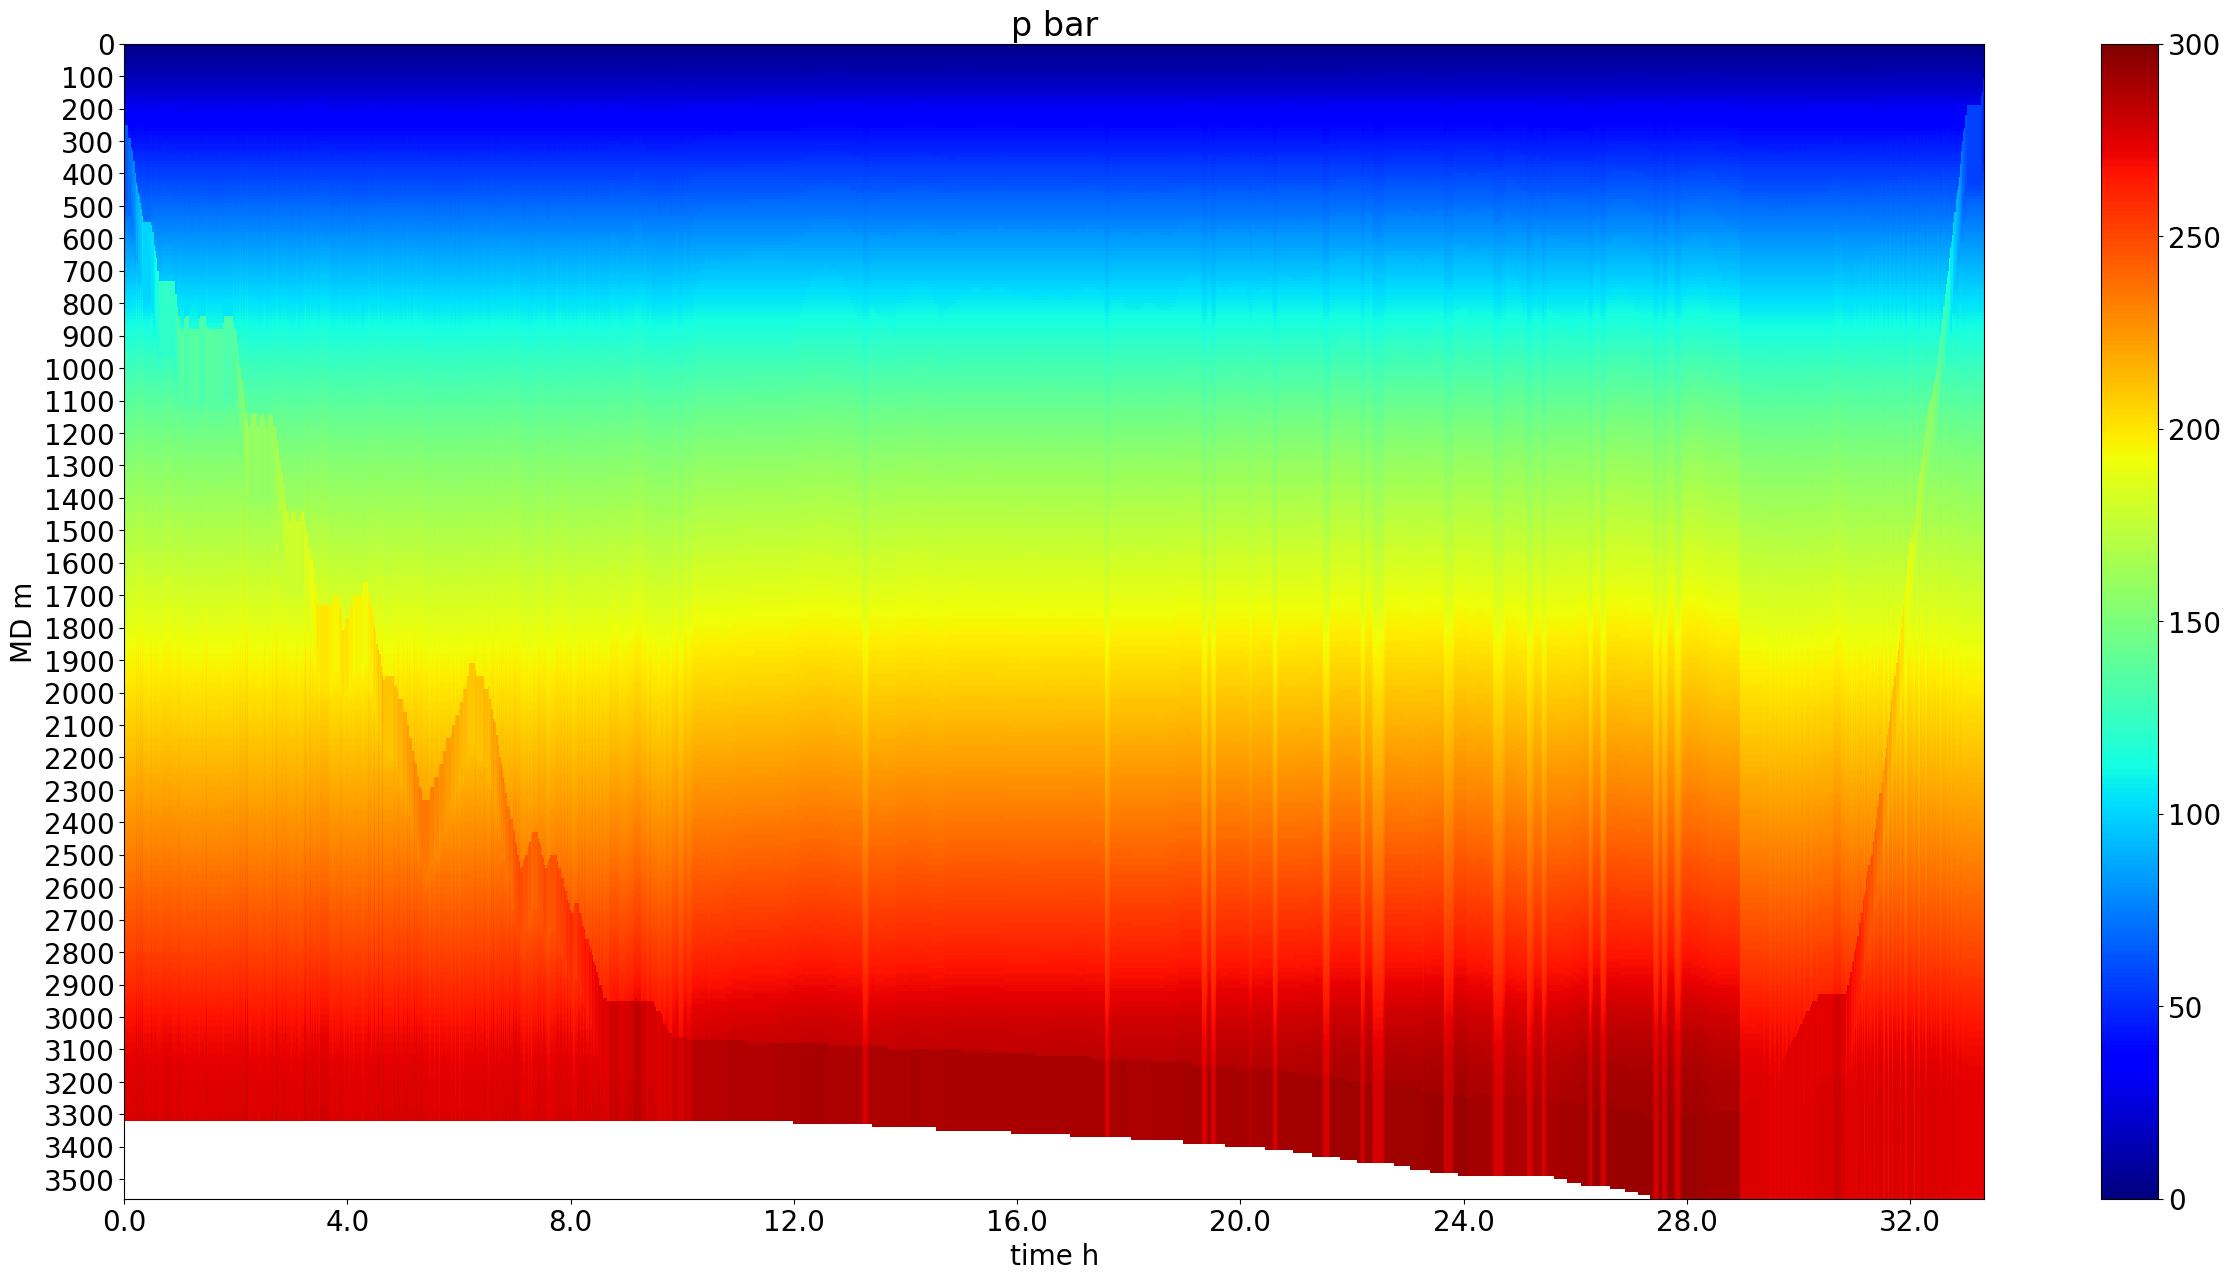

In [167]:


fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[4,:,::-1].T,cmap='jet',vmin=0,vmax=300)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('p bar')
plt.colorbar(obj,ax=ax)


b- ecd

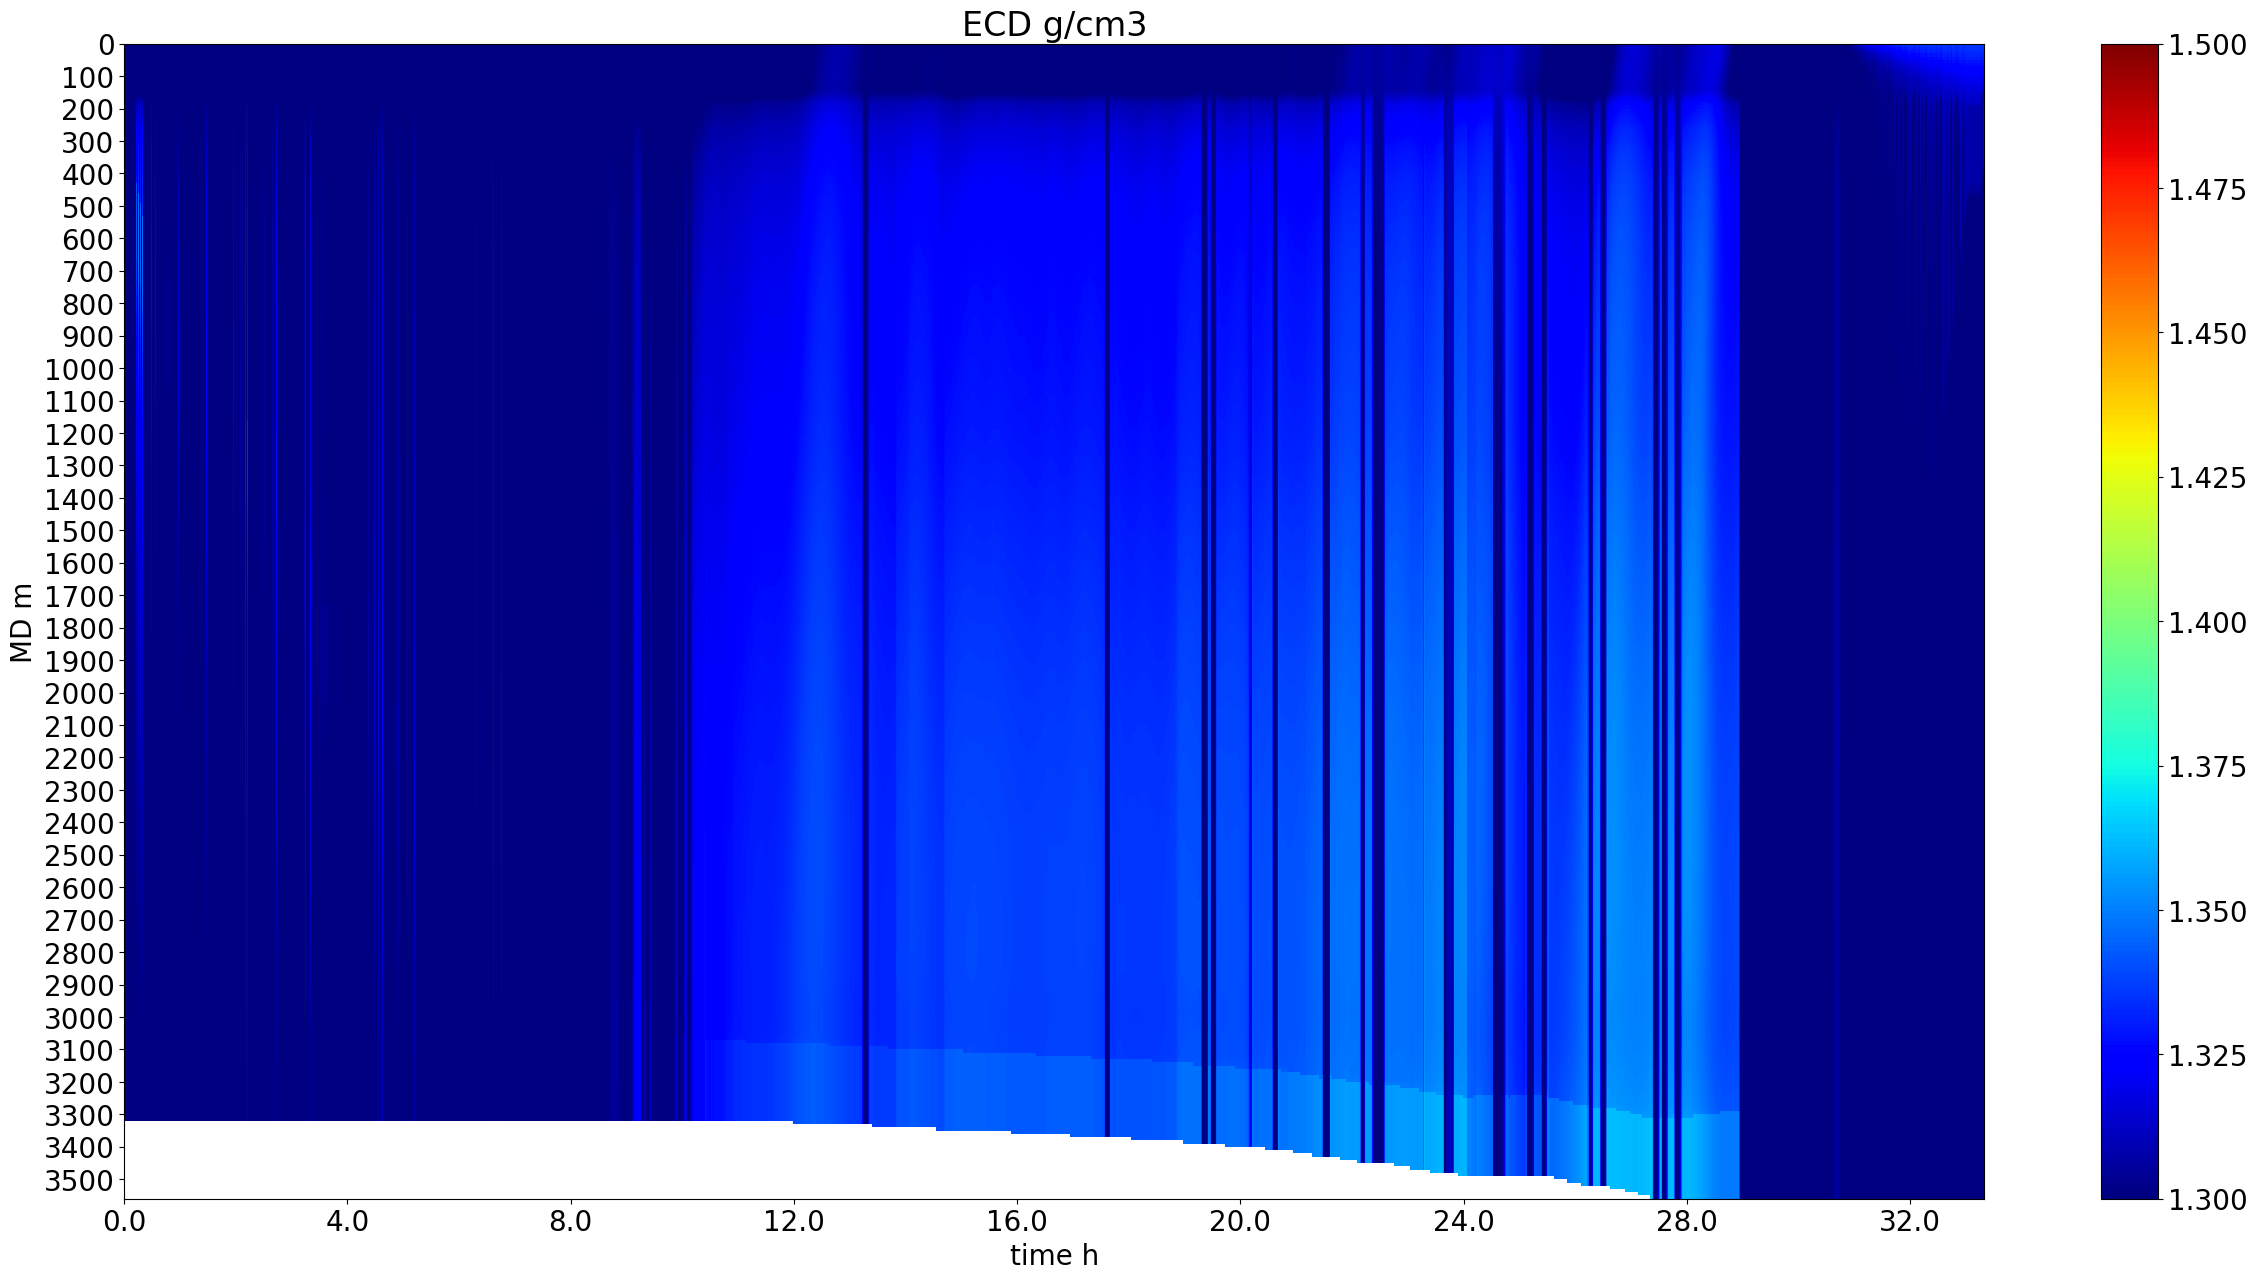

In [168]:


fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[5,:,::-1].T,cmap='jet',vmin = 1.3,vmax=1.5)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('ECD g/cm3')
plt.colorbar(obj,ax=ax)

c- dpf



fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[6,:,::-1].T,cmap='jet',vmin=0,vmax=2000)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('dpf Pa')
plt.colorbar(obj,ax=ax)

d- Reynolds number



fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[7,:,::-1].T,cmap='jet',vmin=0,vmax=4000)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('Reynolds number')
plt.colorbar(obj,ax=ax)


e- Taylor Number



fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[8,:,::-1].T,cmap='jet',vmin=0,vmax=2000)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('Taylor number')
plt.colorbar(obj,ax=ax)



f- Shields number



fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[9,:,::-1].T,cmap='jet',vmin=0,vmax=0.3)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('Shields number')
plt.colorbar(obj,ax=ax)


g- Rouse number


fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[10,:,::-1].T,cmap='jet',vmin=0,vmax=2.5)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('Rouse number')
plt.colorbar(obj,ax=ax)


i- avg density



fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(results_z[11,:,::-1].T,cmap='jet',vmin=1100,vmax=1500)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('avg density')
plt.colorbar(obj,ax=ax)


j- cutting conc

fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(conc_val_cutting,cmap='jet',vmin=0,vmax=0.05)
ax.set_yticks(np.arange(6,357,10))
ax.set_yticklabels(np.arange(3500,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,12000,1440))
ax.set_xticklabels(np.arange(0,12000/360,4))
ax.set_xlabel('time h')
ax.set_title('cutting concentration')
plt.colorbar(obj,ax=ax)



Export